Getting SPI time series and adding to the predictor files. 

Author: Kathleen Shalini Rome

Date: 25 Aug 2022

Source of SPI: https://github.com/e-baumer/standard_precip 
Source of Example: https://github.com/e-baumer/standard_precip/blob/master/examples/example_use.ipynb 

In [ ]:
import pandas as pd
from standard_precip.spi import SPI
from standard_precip.utils import plot_index

# Rainfall data: 
# Data format: date - yyyy-mm-mm, TotalPrecipitation - 0.00
# My format: Location, Year_Month - yyyy-mm, Rainfall
rainfall_data = pd.read_csv('All_Location_Rainfall_test2022_07_29_21_32.csv')


In [11]:
rainfall_data

,Unnamed: 0,Location,Year_Month,Rainfall
0,0,Cobar,2000-01,5.101562
1,1,Cobar,2000-02,124.703125
2,2,Cobar,2000-03,64.601562
3,3,Cobar,2000-04,76.203125
4,4,Cobar,2000-05,90.500000
...,...,...,...,...
21889,262,Inglewood,2021-11,197.000000
21890,263,Inglewood,2021-12,141.898438
21891,264,Inglewood,2022-01,69.703125
21892,265,Inglewood,2022-02,113.500000


In [17]:
# So I dont think it depends on location at all but date and precipitation. 
rainfall_data.drop(['Unnamed: 0','Location'],axis = 1,inplace = True)
rainfall_data.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
rainfall_data

,date,precip
0,2000-01,5.101562
1,2000-02,124.703125
2,2000-03,64.601562
3,2000-04,76.203125
4,2000-05,90.500000
...,...,...
21889,2021-11,197.000000
21890,2021-12,141.898438
21891,2022-01,69.703125
21892,2022-02,113.500000


In [7]:
# Creating SPI Instance
spi_rain = SPI()


In [20]:
spi_monthly = spi_rain.calculate(rainfall_data, 'date', 'precip', freq="M", scale=1, 
                                 fit_type="lmom", dist_type="gam")
spi_monthly

Found duplicate dates in dataframe. Removing duplicates and using first date found


,date,precip,precip_calculated_index
0,2000-01-01,5.101562,-0.706878
1,2000-02-01,124.703125,1.292019
2,2000-03-01,64.601562,1.127415
3,2000-04-01,76.203125,1.569564
4,2000-05-01,90.500000,1.912947
...,...,...,...
262,2021-11-01,107.601562,1.299706
263,2021-12-01,28.601562,0.267703
264,2022-01-01,39.101562,0.584986
265,2022-02-01,52.000000,0.264457


Thus that means we need to calculate SPI for each location file. This may take a while. I will need to loop it like I did to combine all files but instead calculate SPI for all of them. 

In [2]:
import pandas as pd
from datetime import datetime
import os
from standard_precip.spi import SPI
from standard_precip.utils import plot_index

# Setting rainfall name variable
climate_var_name = 'Rainfall' #What is the climate_var name used in other function

# Get locations list:
df_prac = pd.read_csv('Drought_Impact_Database_28July2022_.csv', encoding = 'unicode_escape')
df_prac.drop_duplicates(subset = ["Location"],inplace = True)
list_of_locations = df_prac['Location'].tolist()
# Setting it for the below function.
locations = list_of_locations #List of locations



In [32]:
# Creating an empty dictionary for dataframes:
di = {} #dictionary

# Loop
for name in locations:
    #Read in csv
    csv_rain = pd.read_csv(climate_var_name + '_' + name + '_' + '2000Jan_2022Mar_28July2022.csv', encoding = 'unicode_escape')
    #Rename first col to Date_Time
    csv_rain.rename(columns = {'Unnamed: 0':'Date_Time'},inplace=True)
    # Creating a new column with Year and Month only
    csv_rain['Year_Month'] = pd.to_datetime(csv_rain['Date_Time'],infer_datetime_format=True).dt.to_period('M')
    # Remove date_time col
    csv_rain.drop('Date_Time', axis = 1, inplace = True)
    # Switch col location
    csv_rain2 = csv_rain[['Year_Month', climate_var_name]]

    # Change year_month data type form yyyy-mm to yyyy-mm-dd (The SPI function needs this)
    # Source: https://stackoverflow.com/questions/59316865/typeerror-passing-perioddtype-data-is-invalid-use-data-to-timestamp-instea
    csv_rain2['Year_Month'] = csv_rain2['Year_Month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

    # Calculate SPI here: 
    csv_rain2.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
    spi_rain = SPI()
    spi_monthly = spi_rain.calculate(csv_rain2, 'date', 'precip', freq="M", scale=1, 
                                    fit_type="lmom", dist_type="gam")
    
    # Add column with location name
    spi_monthly.insert(0,'Location', name)

    di[name] = spi_monthly
    
# Combine all dataframes in the dictionary
combined_SPI_data = pd.concat(di.values(),axis = 0)

# Save to csv
combined_SPI_data.to_csv('All_Location'+ '_' + climate_var_name + '_SPI_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv')

I used the below to make sure I was getting the right outputs for the loop. I also checked afterwards that a random name had the same data as the combined SPI data file. 

In [33]:
csv_rain = pd.read_csv(climate_var_name + '_' + 'Canowindra' + '_' + '2000Jan_2022Mar_28July2022.csv', encoding = 'unicode_escape')
#Rename first col to Date_Time
csv_rain.rename(columns = {'Unnamed: 0':'Date_Time'},inplace=True)
# Creating a new column with Year and Month only
csv_rain['Year_Month'] = pd.to_datetime(csv_rain['Date_Time'],infer_datetime_format=True).dt.to_period('M')
# Remove date_time col
csv_rain.drop('Date_Time', axis = 1, inplace = True)
# Switch col location
csv_rain = csv_rain[['Year_Month', climate_var_name]]

# Change year_month data type form yyyy-mm to yyyy-mm-dd (The SPI function needs this)
# Source: https://stackoverflow.com/questions/59316865/typeerror-passing-perioddtype-data-is-invalid-use-data-to-timestamp-instea
csv_rain['Year_Month'] = csv_rain['Year_Month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

# Calculate SPI here: 
csv_rain.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
spi_rain = SPI()
spi_monthly = spi_rain.calculate(csv_rain, 'date', 'precip', freq="M", scale=1, 
                                fit_type="lmom", dist_type="gam")
spi_monthly

,date,precip,precip_calculated_index
0,2000-01-01,13.296875,-1.418338
1,2000-02-01,11.898438,-1.132683
2,2000-03-01,77.601562,0.743458
3,2000-04-01,49.500000,0.803092
4,2000-05-01,45.101562,0.797336
...,...,...,...
262,2021-11-01,168.898438,1.829708
263,2021-12-01,35.703125,-0.265079
264,2022-01-01,126.898438,2.018995
265,2022-02-01,15.500000,-0.925021


I manually changed the format of date in excel to be yyyy-mm. Maybe I could use the code I used above though. Will do that later. 

Calculating the 3 monthly and 2 monthly SPI as well

In [36]:
# Creating an empty dictionary for dataframes:
di = {} #dictionary

# Loop
for name in locations:
    #Read in csv
    csv_rain = pd.read_csv(climate_var_name + '_' + name + '_' + '2000Jan_2022Mar_28July2022.csv', encoding = 'unicode_escape')
    #Rename first col to Date_Time
    csv_rain.rename(columns = {'Unnamed: 0':'Date_Time'},inplace=True)
    # Creating a new column with Year and Month only
    csv_rain['Year_Month'] = pd.to_datetime(csv_rain['Date_Time'],infer_datetime_format=True).dt.to_period('M')
    # Remove date_time col
    csv_rain.drop('Date_Time', axis = 1, inplace = True)
    # Switch col location
    csv_rain2 = csv_rain[['Year_Month', climate_var_name]]

    # Change year_month data type form yyyy-mm to yyyy-mm-dd (The SPI function needs this)
    # Source: https://stackoverflow.com/questions/59316865/typeerror-passing-perioddtype-data-is-invalid-use-data-to-timestamp-instea
    csv_rain2['Year_Month'] = csv_rain2['Year_Month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

    # Calculate SPI here: 
    csv_rain2.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
    spi_rain = SPI()
    spi_2monthly = spi_rain.calculate(csv_rain2, 'date', 'precip', freq="M", scale=2, 
                                    fit_type="lmom", dist_type="gam")
    
    # Add column with location name
    spi_2monthly.insert(0,'Location', name)

    di[name] = spi_2monthly
    
# Combine all dataframes in the dictionary
combined_SPI_2_data = pd.concat(di.values(),axis = 0)

# Save to csv
combined_SPI_2_data.to_csv('All_Location'+ '_' + climate_var_name + '_SPI_2month_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv')

In [37]:
# Creating an empty dictionary for dataframes:
di = {} #dictionary

# Loop
for name in locations:
    #Read in csv
    csv_rain = pd.read_csv(climate_var_name + '_' + name + '_' + '2000Jan_2022Mar_28July2022.csv', encoding = 'unicode_escape')
    #Rename first col to Date_Time
    csv_rain.rename(columns = {'Unnamed: 0':'Date_Time'},inplace=True)
    # Creating a new column with Year and Month only
    csv_rain['Year_Month'] = pd.to_datetime(csv_rain['Date_Time'],infer_datetime_format=True).dt.to_period('M')
    # Remove date_time col
    csv_rain.drop('Date_Time', axis = 1, inplace = True)
    # Switch col location
    csv_rain2 = csv_rain[['Year_Month', climate_var_name]]

    # Change year_month data type form yyyy-mm to yyyy-mm-dd (The SPI function needs this)
    # Source: https://stackoverflow.com/questions/59316865/typeerror-passing-perioddtype-data-is-invalid-use-data-to-timestamp-instea
    csv_rain2['Year_Month'] = csv_rain2['Year_Month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

    # Calculate SPI here: 
    csv_rain2.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
    spi_rain = SPI()
    spi_3monthly = spi_rain.calculate(csv_rain2, 'date', 'precip', freq="M", scale=3, 
                                    fit_type="lmom", dist_type="gam")
    
    # Add column with location name
    spi_3monthly.insert(0,'Location', name)

    di[name] = spi_3monthly
    
# Combine all dataframes in the dictionary
combined_SPI_3_data = pd.concat(di.values(),axis = 0)

# Save to csv
combined_SPI_3_data.to_csv('All_Location'+ '_' + climate_var_name + '_SPI_3month_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv')

# Extracting SPI and adding to database with predictors

In [35]:
import Combine_Database_Loc_data_2
 
drought_db = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_data_2022_08_12_16_48.csv', encoding = 'unicode_escape')
SPI_df = pd.read_csv('All_Location_Rainfall_SPI2022_08_25_17_24.csv', encoding = 'unicode_escape')
SPI_df.drop(['precip'],axis = 1,inplace = True)
SPI_df.rename(columns={"date":"Year_Month"},inplace = True)
# Combining database and data tables according to Year,Month and Location. 
clim_var_9 = []
row = 1

r_name = 'precip_calculated_index'
#For NDVI
for row in drought_db.itertuples():
    time = row.Year_Month
    loca = row.Location
    # print(row)
    clim_var_9.append(float((SPI_df.loc[(SPI_df['Year_Month']== time) & (SPI_df['Location']== loca)][r_name].values)))

drought_db[r_name] = clim_var_9
drought_db.to_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_data' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')


Then I manually deleted the unnamed columns in excel that comes from adding the thing. 

I then decided to also add SPI 2 month and 3 month

In [39]:
# For 2 SPI month 
drought_db = pd.read_csv('Database_All_AWRA_NDVI_Mof_3MPrecip_noWel_SPI_data2022_08_25_17_41.csv', encoding = 'unicode_escape')
SPI_2_df = pd.read_csv('All_Location_Rainfall_SPI_2month_2022_08_25_17_49.csv', encoding = 'unicode_escape')
SPI_2_df.drop(['precip_scale_2'],axis = 1,inplace = True)
SPI_2_df.rename(columns={"date":"Year_Month"},inplace = True)
# Combining database and data tables according to Year,Month and Location. 
clim_var_1 = []
row = 1

r_name = 'precip_scale_2_calculated_index'
#For NDVI
for row in drought_db.itertuples():
    time = row.Year_Month
    loca = row.Location
    # print(row)
    clim_var_1.append(float((SPI_2_df.loc[(SPI_2_df['Year_Month']== time) & (SPI_2_df['Location']== loca)][r_name].values)))

drought_db[r_name] = clim_var_1
drought_db.to_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_2month_data' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')


In [40]:
# For 3 SPI month
drought_db = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_2month_data2022_08_25_17_57.csv', encoding = 'unicode_escape')
SPI_3_df = pd.read_csv('All_Location_Rainfall_SPI_3month_2022_08_25_17_50.csv', encoding = 'unicode_escape')
SPI_3_df.drop(['precip_scale_3'],axis = 1,inplace = True)
SPI_3_df.rename(columns={"date":"Year_Month"},inplace = True)
# Combining database and data tables according to Year,Month and Location. 
clim_var_2 = []
row = 1

r_name = 'precip_scale_3_calculated_index'
#For NDVI
for row in drought_db.itertuples():
    time = row.Year_Month
    loca = row.Location
    # print(row)
    clim_var_2.append(float((SPI_3_df.loc[(SPI_3_df['Year_Month']== time) & (SPI_3_df['Location']== loca)][r_name].values)))

drought_db[r_name] = clim_var_2
drought_db.to_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_3month_data' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')

### 1 Sept 2022
FROM SANAA'S PAPER: file:///C:/Users/sy6sh/Documents/A.UNSW_COURSE_FOLDERS/Honours%202022/Sanaa%20Published%20Paper.pdf 
"SPI: Assesses drought solely from precipitation. At a given location, long term monthly 263 precipitation is transformed into a normal distribution, and the computed SPI value represents the 264 unit standard normal deviate. Previous studies have associated droughts with SPI values of less 265 than −1 e.g. (Bachmair et al., 2015), −0.8 (in USDM) or 0 (McKee, 1995). We calculated
266 monthly SPI using the SPEI R package for each grid point presented in Figure 1 from the same 267 precipitation dataset used to develop the RF model. We derived SPI for several accumulation 268 periods including 1, 3, 6, 9 and 12 months. In this study we carry out the analysis using each of 269 the three drought cutoffs, i.e. -1, -0.8 and 0."

So I decided to also do 1,3,6,9 and 12 months. I already have 1 and 3. Lets do 6,9,12,24. I added 24 just because I have seen it done sometimes for SPI. 

In [3]:
# Creating an empty dictionary for dataframes:
di = {} #dictionary

# Loop
for name in locations:
    #Read in csv
    csv_rain = pd.read_csv(climate_var_name + '_' + name + '_' + '2000Jan_2022Mar_28July2022.csv', encoding = 'unicode_escape')
    #Rename first col to Date_Time
    csv_rain.rename(columns = {'Unnamed: 0':'Date_Time'},inplace=True)
    # Creating a new column with Year and Month only
    csv_rain['Year_Month'] = pd.to_datetime(csv_rain['Date_Time'],infer_datetime_format=True).dt.to_period('M')
    # Remove date_time col
    csv_rain.drop('Date_Time', axis = 1, inplace = True)
    # Switch col location
    csv_rain2 = csv_rain[['Year_Month', climate_var_name]]

    # Change year_month data type form yyyy-mm to yyyy-mm-dd (The SPI function needs this)
    # Source: https://stackoverflow.com/questions/59316865/typeerror-passing-perioddtype-data-is-invalid-use-data-to-timestamp-instea
    csv_rain2['Year_Month'] = csv_rain2['Year_Month'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d')

    # Calculate SPI here: 
    csv_rain2.rename(columns={"Year_Month":"date","Rainfall":"precip"},inplace = True)
    spi_rain = SPI()
    spi_6monthly = spi_rain.calculate(csv_rain2, 'date', 'precip', freq="M", scale=6, 
                                    fit_type="lmom", dist_type="gam")
    
    # Add column with location name
    spi_6monthly.insert(0,'Location', name)

    di[name] = spi_6monthly
    
# Combine all dataframes in the dictionary
combined_SPI_6_data = pd.concat(di.values(),axis = 0)

# Save to csv
combined_SPI_6_data.to_csv('All_Location'+ '_' + climate_var_name + '_SPI_6month_' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) + '.csv')



In [5]:
# For 6 SPI month
drought_db = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_3month_data2022_08_25_18_00.csv', encoding = 'unicode_escape')
SPI_6_df = pd.read_csv('All_Location_Rainfall_SPI_6month_2022_09_01_10_30.csv', encoding = 'unicode_escape')
SPI_6_df.drop(['precip_scale_6'],axis = 1,inplace = True)
SPI_6_df.rename(columns={"date":"Year_Month"},inplace = True)
# Combining database and data tables according to Year,Month and Location. 
clim_var_2 = []
row = 1

r_name = 'precip_scale_6_calculated_index'
#For NDVI
for row in drought_db.itertuples():
    time = row.Year_Month
    loca = row.Location
    # print(row)
    clim_var_2.append(float((SPI_6_df.loc[(SPI_6_df['Year_Month']== time) & (SPI_6_df['Location']== loca)][r_name].values)))

drought_db[r_name] = clim_var_2
drought_db.to_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_6month_data' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')

In [16]:
#You need to go in order 1,2,3,6,9,12,24 because it saves the database with previous number. Can be made more efficient.

import SPI_function_6

# Setting rainfall name variable:
climate_var_name = 'Rainfall'

# Get locations list:
df_prac = pd.read_csv('Drought_Impact_Database_28July2022_.csv', encoding = 'unicode_escape')
df_prac.drop_duplicates(subset = ["Location"],inplace = True)
list_of_locations = df_prac['Location'].tolist()
# Setting it for the below function.
locations = list_of_locations #List of locations

# Get the number of months you want SPI accumulated to. 
month_acc = 24
prev_database_mth_acc = 12
SPI_function_6.get_SPI_n(climate_var_name,locations,month_acc,prev_database_mth_acc)


Calculated SPI for all locations
Successfully extracted SPI for 24 months and added to database


Improvements include adding drought_database file you want to append to as an input rather than calculated in the function itself. I can also create a loop with the 1,2,3,6,9,12,24 so that it is much faster nad things do not need to be changed. 

# Creating 0 and 1 for SPI-0 and SPI_-0.8 based on Sanaa's paper
I used 0 as one threshold and -0.8 as another. So for all those >0 I said non drought. All those =<0 I said drought. I chose the =0 to be a drought to train to be more bias to drought events???

In [53]:
database_SPI = pd.read_csv('Database_All_AWRA_NDVI_Mof_3MPrecip_noWel_SPI_data2022_08_25_17_41.csv', encoding = 'unicode_escape')
database_SPI.drop(columns=['Unnamed: 0','Year','Month','Drought / No Drought','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','Deep_Drainage','PET_Actual','E_Actual','Soil_M_root_zone','Qtot','Rainfall','ENSO','IOD','IPO_TPI','SAMI','P_acc_3M'])

,Year_Month,Geographic Location,Location,Latitude,Longitude,precip_calculated_index
0,2014-03,Cobar,Cobar,-31.4980,145.8383,0.961742
1,2014-02,Cobar,Cobar,-31.4980,145.8383,0.789762
2,2014-01,Cobar,Cobar,-31.4980,145.8383,-0.777240
3,2014-03,Walgett,Walgett,-30.0167,148.1167,0.060530
4,2014-02,Walgett,Walgett,-30.0167,148.1167,-0.381371
...,...,...,...,...,...,...
930,2020-11,City of Wagga Wagga,Wagga Wagga,-35.1330,147.3670,-0.165818
931,2020-12,City of Wagga Wagga,Wagga Wagga,-35.1330,147.3670,0.730887
932,2021-01,City of Wagga Wagga,Wagga Wagga,-35.1330,147.3670,1.089199
933,2021-02,City of Wagga Wagga,Wagga Wagga,-35.1330,147.3670,0.938744


for row in range = 1 till 935:
    make new column ['SPI_0']that says:
        if SPI > 0:
            SPI_0 = 0
        else if SPI <0:
            SPI_0 = 1
    add column to dataframe. 
    

In [56]:
# For SPI_0
SPI_0 = []
row = 1

r_name = 'SPI_0'
#For NDVI
for row in database_SPI.itertuples():
    SPI_value = float(row.precip_calculated_index)
    if SPI_value > 0:
        SPI_value = 0
    else:
        SPI_value = 1
    # print(row)
    SPI_0.append(SPI_value)

database_SPI[r_name] = SPI_0
database_SPI.to_csv('SPI_0_Performance' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')


In [59]:
# For SPI_-0.8
SPI_08 = []
row = 1

r_name = 'SPI_-0.8'
#For NDVI
for row in database_SPI.itertuples():
    SPI_value_08 = float(row.precip_calculated_index)
    if SPI_value_08 > -0.8:
        SPI_value_08 = 0
    else:
        SPI_value_08 = 1
    # print(row)
    SPI_08.append(SPI_value_08)

database_SPI[r_name] = SPI_08
database_SPI.to_csv('SPI_1_and_SPI_0.8_Performance' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')

In [60]:
# For SPI_-1
SPI__1 = []
row = 1

r_name = 'SPI_-1'
#For NDVI
for row in database_SPI.itertuples():
    SPI_value_min1 = float(row.precip_calculated_index)
    if SPI_value_min1 > -1:
        SPI_value_min1 = 0
    else:
        SPI_value_min1 = 1
    # print(row)
    SPI__1.append(SPI_value_min1)

database_SPI[r_name] = SPI__1
database_SPI.to_csv('SPI_1_and_SPI_0.8_and_SPI_min1_Performance' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')

I then manually calculated Accuracy, TP, TN, PRecision, recall, FP, FN, F1 score. I will then in Future look at Sanaa's paper and get the other metrics she calculated. 

I realised I can use sklearn to get confusion matrix as it needs y_pred and y_true. I will set y_true as the database build non drought drought and the y_pred is SPI_1 etc

In [62]:
database_SPI.head()

,Unnamed: 0,Year,Month,Year_Month,Geographic Location,Location,Latitude,Longitude,Drought / No Drought,MYD13A3_061__1_km_monthly_EVI,...,Rainfall,ENSO,IOD,IPO_TPI,SAMI,P_acc_3M,precip_calculated_index,SPI_0,SPI_-0.8,SPI_-1
0,0,2014,March,2014-03,Cobar,Cobar,-31.4980,145.8383,1,0.1664,...,57.000000,0.54,-0.051,-0.138,1.34,145.500000,0.961742,0,0,0
1,1,2014,February,2014-02,Cobar,Cobar,-31.4980,145.8383,1,0.1311,...,84.101562,-0.37,-0.009,-0.147,0.36,119.500000,0.789762,0,0,0
2,2,2014,January,2014-01,Cobar,Cobar,-31.4980,145.8383,1,0.1385,...,4.398438,-1.26,-0.036,-0.157,-0.13,37.000000,-0.777240,1,0,0
3,3,2014,March,2014-03,Walgett,Walgett,-30.0167,148.1167,1,0.2209,...,34.000000,0.54,-0.051,-0.138,1.34,68.203125,0.060530,0,0,0
4,4,2014,February,2014-02,Walgett,Walgett,-30.0167,148.1167,1,0.2091,...,27.000000,-0.37,-0.009,-0.147,0.36,41.000000,-0.381371,1,0,0


In [76]:
y_true = database_SPI.iloc[:,8].values #All rows and only the Drought/No drought col
y_pred_0 = database_SPI.iloc[:,-3].values
y_pred_08 = database_SPI.iloc[:,-2].values
y_pred_1 = database_SPI.iloc[:,-1].values


In [77]:
# For metrics
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# I ended up not using confusion matrix. But I could actually calculate it. 
# For feature importance plots:
from sklearn.inspection import permutation_importance

# Creating a dictionary called list_metrics
acc_list_metrics = []
tp_list_metrics = []
tn_list_metrics = []
fp_list_metrics = []
fn_list_metrics = []


# Confusion matrix - true neg, false pos, false neg, true pos:
tn, fp, fn, tp = confusion_matrix(y_true,y_pred_0, labels=[0, 1]).ravel()

tn_list_metrics = np.append(tn_list_metrics,tn)
fp_list_metrics = np.append(fp_list_metrics,fp)
fn_list_metrics = np.append(fn_list_metrics,fn)
tp_list_metrics = np.append(tp_list_metrics,tp)

# Accuracy:
acc = accuracy_score(y_true, y_pred_0)
acc_list_metrics= np.append(acc_list_metrics,acc)

df_acc_metrics = pd.DataFrame(acc_list_metrics)
#df_acc_metrics.to_csv('Random_state_0_to_50_Acc_17Aug.csv')
    
df_tn_metrics = pd.DataFrame(tn_list_metrics)
#df_tn_metrics.to_csv('Random_state_0_to_50_trueneg_17Aug.csv')

df_fp_metrics = pd.DataFrame(fp_list_metrics)
#df_fp_metrics.to_csv('Random_state_0_to_50_falsepos_17Aug.csv')

df_fn_metrics = pd.DataFrame(fn_list_metrics)
#df_fn_metrics.to_csv('Random_state_0_to_50_falseneg_17Aug.csv')

df_tp_metrics = pd.DataFrame(tp_list_metrics)
#df_tp_metrics.to_csv('Random_state_0_to_50_truepos_17Aug.csv')


In [78]:
df_acc_metrics

,0
0,0.636364


What I could do is calculate the values for each random state and download the X_test_all with the SPI values. Then I can calculate the values on them instead. But it is almost have to manually get the X_test_all csv's individually and loop them to calculate the acc, conf matrix and classification report. Or from the current ones I can compare the indices and make new columns for each csv file and resave and then i can loop through them and calculate the acc, conf. I think that is good. 

In [81]:
database_pred = pd.read_csv('SPI_1_and_SPI_0.8_and_SPI_min1_Performance2022_08_25_18_53.csv')
database_pred.drop(['Unnamed: 0','Unnamed: 0.1','Year_Month','Latitude','Longitude', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1,inplace=True)

database_pred.head()

,Year,Month,Geographic Location,Location,Drought / No Drought,Deep_Drainage,PET_Actual,E_Actual,Soil_M_root_zone,Qtot,Rainfall,ENSO,IOD,SAMI,P_acc_3M,precip_calculated_index,SPI_0,SPI_-0.8,SPI_-1
0,2014,March,Cobar,Cobar,1,2.349609,157.679688,70.867188,0.265625,0.500000,57.000000,0.54,-0.051,1.34,145.500000,0.961742,0,0,0
1,2014,February,Cobar,Cobar,1,1.896484,203.679688,28.414062,0.146484,2.351562,84.101562,-0.37,-0.009,0.36,119.500000,0.789762,0,0,0
2,2014,January,Cobar,Cobar,1,2.130859,273.570312,30.031250,0.082031,0.078125,4.398438,-1.26,-0.036,-0.13,37.000000,-0.777240,1,0,0
3,2014,March,Walgett,Walgett,1,0.298828,176.757812,27.703125,0.082031,0.054688,34.000000,0.54,-0.051,1.34,68.203125,0.060530,0,0,0
4,2014,February,Walgett,Walgett,1,0.271484,203.789062,7.820312,0.023438,0.015625,27.000000,-0.37,-0.009,0.36,41.000000,-0.381371,1,0,0


In [87]:
# Importing numpy
import numpy as np
import pandas as pd
# For plotting feature importance: 
import matplotlib.pyplot as plt
import time
# For dividing training and testing  
from sklearn.model_selection import train_test_split
#For training the model
from sklearn.ensemble import RandomForestClassifier
# For metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# I ended up not using confusion matrix. But I could actually calculate it. 
# For feature importance plots:
from sklearn.inspection import permutation_importance

# Downloading database:
database_pred = pd.read_csv('SPI_1_and_SPI_0.8_and_SPI_min1_Performance2022_08_25_18_53.csv')
# Dropping unecessary columns -  removing IPO and NDVI and EVI
database_pred.drop(['Unnamed: 0','Unnamed: 0.1','Year_Month','Latitude','Longitude', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1,inplace=True)

# Dividing data into predictors (X) and no drought/drought (y)
y = database_pred.iloc[:,4].values #All rows and only the 4th column (Drought no drought)
X = database_pred 
X.drop(['Drought / No Drought'],axis = 1,inplace=True)
#Convert to array
X.to_numpy()

# ----------------------------TRAINING AND RESULTS WITH DIFF RANDOM STATES---------------------------------------------------------------------------------------------------------------------------
# Creating a dictionary called list_metrics
acc_list_metrics = []
tp_list_metrics = []
tn_list_metrics = []
fp_list_metrics = []
fn_list_metrics = []

acc_lm_SPI0 = []
tp_lm_SPI0 = []
tn_lm_SPI0 = []
fp_lm_SPI0 = []
fn_lm_SPI0 = []

for i in range(51): 
    # ----------------------------SPLITTING TRAINING AND TESTING DATASET--------------------------------------------
    #Dividing data into training and testing: 
    # from sklearn.model_selection import train_test_split
    # I put it above
 
    #Splitting by 0.2/0.8. First we create an Xtrain and X test that has Location, Year, Month, NDVI quality data etc. 
    X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= i)

    # Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
    X_train = X_train_all.drop(['Year','Month','Geographic Location','Location','precip_calculated_index','SPI_0','SPI_-0.8','SPI_-1'],axis = 1)
    X_test = X_test_all.drop(['Year','Month','Geographic Location','Location','precip_calculated_index','SPI_0','SPI_-0.8','SPI_-1'],axis = 1) 

    # --------------------------------TRAINING THE MODEL---------------------------------------------        
    # Training the model
    # from sklearn.ensemble import RandomForestClassifier # See above
    classifier = RandomForestClassifier(n_estimators=20, random_state=i)
    classifier.fit(X_train, y_train)
    y_pred_classifier = classifier.predict(X_test)
    
    # ----------------------------- GETTING PREDICTIONS------------------------
    #predictions for X_test
    predictions = classifier.predict_proba(X_test)
    # predictions # Col 1 is 0 and Col 2 is 1. We can
    prob_drought = predictions[:,1]
    # prob_drought
    X_test_all['ypred'] = prob_drought
    X_test_all['y_obs'] = y_test
    X_test_all.to_csv('X_test_all_'+ str(i) +'_17Aug.csv')

    # predictions for X_train to make sure it is correct. This helps to check if it is classifying D/no D correctly
    prediction_train = classifier.predict_proba(X_train)
    # prediction_train # Col 1 is 0 and Col 2 is 1. We can
    prob_drought_train = prediction_train[:,1]
    
    X_train_all['ypred'] = prob_drought_train
    X_train_all['y_obs'] = y_train
    X_train_all.to_csv('X_train_all_'+ str(i) +'_17Aug.csv')
    
    # ----------------------------GETTING METRICS-------------------------------------------------------
    # confusion matrix + other matrix
    # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
    # See above

    # For confusion matrix later: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
        
    # False Positives:
    # I got inspiration from this: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
    #mistakes = np.invert(y_pred_classifier == y_test)
    #count_fp = np.count_nonzero(mistakes)
    #fp_list_metrics = np.append(fp_list_metrics,count_fp)
    # I later found that it was just calculating mistakes and not false positive.

    # FOR SPI
    y_true_test = y_test #All rows and only the Drought/No drought col
    y_pred_0_test = X_test_all.iloc[:,-5].values
    y_pred_08_test = X_test_all.iloc[:,-4].values
    y_pred_1_test = X_test_all.iloc[:,-3].values

    y_true_train = y_train #All rows and only the Drought/No drought col
    y_pred_0_train = X_train_all.iloc[:,-5].values
    y_pred_08_train = X_train_all.iloc[:,-4].values
    y_pred_1_train = X_train_all.iloc[:,-3].values
    
    # Confusion matrix - true neg, false pos, false neg, true pos:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classifier, labels=[0, 1]).ravel()

    tn_list_metrics = np.append(tn_list_metrics,tn)
    fp_list_metrics = np.append(fp_list_metrics,fp)
    fn_list_metrics = np.append(fn_list_metrics,fn)
    tp_list_metrics = np.append(tp_list_metrics,tp)

    # Confusion matrix for SPI - true neg, false pos, false neg, true pos:
    tn_SPI0, fp_SPI0, fn_SPI0, tp_SPI0 = confusion_matrix(y_true_test, y_pred_0_test, labels=[0, 1]).ravel()

    tn_lm_SPI0 = np.append(tn_lm_SPI0,tn_SPI0)
    fp_lm_SPI0 = np.append(fp_lm_SPI0,fp_SPI0)
    fn_lm_SPI0 = np.append(fn_lm_SPI0,fn_SPI0)
    tp_lm_SPI0 = np.append(tp_lm_SPI0,tp_SPI0)

    # Accuracy:
    acc = accuracy_score(y_test, y_pred_classifier)
    acc_list_metrics= np.append(acc_list_metrics,acc)

    # Accuracy:
    acc_SPI0 = accuracy_score(y_true_test, y_pred_0_test)
    acc_lm_SPI0= np.append(acc_lm_SPI0,acc_SPI0)

    # Classification report:
    # Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
    # Function
    def classification_report_csv(report,rd_state):
        report_data = []
        lines = report.split('\n')
        for line in lines[2:-5]:
            row = {}
            
            row_data = ' '.join(line.split())   
            row_data = row_data.split(' ')
            
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
            # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv('classification_report_'+'25Aug2022_'+ str(rd_state) + '.csv', index = False)
    
    report = classification_report(y_test, y_pred_classifier)
    classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to. 

    ## SPI
    def SPI_classification_report_csv(report,rd_state):
        report_data = []
        lines = report.split('\n')
        for line in lines[2:-5]:
            row = {}
            
            row_data = ' '.join(line.split())   
            row_data = row_data.split(' ')
            
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
            # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv('SPI0_classification_report_'+'25Aug2022_'+ str(rd_state) + '.csv', index = False)
    
    report = classification_report(y_true_test, y_pred_0_test)
    SPI_classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to.

    # ---------------------PLOTTING FEATURE IMPORTANCE-------------------------------------------------- 
    #Preparing variables
    #feature_names = ['Deep_Drainage','PET_Actual', 'E_Actual',	'Soil_M_root_zone',	'RunOff', 'Rainfall','ENSO','IOD','SAMI','Rainfall (3 Months)']
    # To understand this line: https://stackoverflow.com/questions/10200268/what-does-shape-do-in-for-i-in-rangey-shape0
    # .shape[] uses 0 as row and 1 as columns. Since X has also month and location data, we need to use X_test as the real number of columns. 

    # Making feature importance
    # from sklearn.inspection import permutation_importance
    # sEE ABOVE
    
    # I also removed the computation time taken to calculate the feature importance
    #result = permutation_importance(classifier,X_test,y_test,n_repeats = 10,random_state = i,n_jobs = 2)
    #forest_importances = pd.Series(result.importances_mean, index=feature_names)

    #-----------------------FIGURE-------------------------------------------------
    #fig, ax = plt.subplots()
    #forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    #ax.set_title("Feature importance - rd_state = " + str(i))
    #ax.set_ylabel("Mean accuracy decrease")
    #fig.tight_layout()
    ##plt.show()
    #plt.savefig('Feature_importance_rd_state_' + str(i) + '_17Aug2022.png')
    #plt.close() #https://stackoverflow.com/questions/21884271/warning-about-too-many-open-figures 

# It is cheaper to fill out a list than fill out a dataframe: https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
df_acc_metrics = pd.DataFrame(acc_list_metrics)
df_acc_metrics.to_csv('Random_state_0_to_50_Acc_25Aug.csv')
    
df_tn_metrics = pd.DataFrame(tn_list_metrics)
df_tn_metrics.to_csv('Random_state_0_to_50_trueneg_25Aug.csv')

df_fp_metrics = pd.DataFrame(fp_list_metrics)
df_fp_metrics.to_csv('Random_state_0_to_50_falsepos_25Aug.csv')

df_fn_metrics = pd.DataFrame(fn_list_metrics)
df_fn_metrics.to_csv('Random_state_0_to_50_falseneg_25Aug.csv')

df_tp_metrics = pd.DataFrame(tp_list_metrics)
df_tp_metrics.to_csv('Random_state_0_to_50_truepos_25Aug.csv')

# For SPI:
df_acc_SPI0 = pd.DataFrame(acc_lm_SPI0)
df_acc_SPI0.to_csv('SPI0_Random_state_0_to_50_Acc_25Aug.csv')
    
df_tn_SPI0 = pd.DataFrame(tn_lm_SPI0)
df_tn_SPI0.to_csv('SPI0_Random_state_0_to_50_trueneg_25Aug.csv')

df_fp_SPI0 = pd.DataFrame(fp_lm_SPI0)
df_fp_SPI0.to_csv('SPI0_Random_state_0_to_50_falsepos_25Aug.csv')

df_fn_SPI0 = pd.DataFrame(fn_lm_SPI0)
df_fn_SPI0.to_csv('SPI0_Random_state_0_to_50_falseneg_25Aug.csv')

df_tp_SPI0 = pd.DataFrame(tp_lm_SPI0)
df_tp_SPI0.to_csv('SPI0_Random_state_0_to_50_truepos_25Aug.csv')


##Combining classification reports
import glob
import os
##Setting path of files and giving name
files = os.path.join("classification_report_25Aug2022*.csv")
##List of merged files returned
files = glob.glob(files)
## Join files with concat
df_files = pd.concat(map(pd.read_csv, files), ignore_index=True)
# print(df_files)
##Saving to csv
df_files.to_csv('Random_state_0_to_50_Classification_Report_Final_25Aug.csv')

# SPI
##Setting path of files and giving name
files_SPI = os.path.join("SPI0_classification_report_25Aug2022*.csv")
##List of merged files returned
files_SPI = glob.glob(files_SPI)
## Join files with concat
df_files_SPI = pd.concat(map(pd.read_csv, files_SPI), ignore_index=True)
# print(df_files)
##Saving to csv
df_files_SPI.to_csv('SPI0_Random_state_0_to_50_Classification_Report_Final_25Aug.csv')


In [100]:
# To just combine accuracy and confusion matrix
df_acc_metrics.rename(columns = {"0":"Accuracy"}, inplace = True)
df_fp_metrics.rename(columns = {"0":"False Positive"}, inplace = True)
df_fn_metrics.rename(columns = {"0":"False Negative"}, inplace = True)
df_tp_metrics.rename(columns = {"0":"True Positive"}, inplace = True)
df_tn_metrics.rename(columns = {"0":"True Negative"}, inplace = True)

# SPI
df_acc_SPI0.rename(columns = {"0":"Accuracy"}, inplace = True)
df_fp_SPI0.rename(columns = {"0":"False Positive"}, inplace = True)
df_fn_SPI0.rename(columns = {"0":"False Negative"}, inplace = True)
df_tp_SPI0.rename(columns = {"0":"True Positive"}, inplace = True)
df_tn_SPI0.rename(columns = {"0":"True Negative"}, inplace = True)

# Combining dataframes. 
comb_metrics = df_acc_metrics.join(df_tn_metrics,lsuffix='_left', rsuffix='_right') #https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
#comb_metrics.drop(comb_metrics.columns[[0,2]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fp_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[2]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fn_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[3]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tp_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[4]], axis = 1, inplace = True) #Dropping extra index that appear
## SPI
comb_metrics = comb_metrics.join(df_acc_SPI0,lsuffix='_left', rsuffix='_right') #https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
#comb_metrics.drop(comb_metrics.columns[[5]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fp_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[6]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fn_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[7]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tp_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[8]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tn_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[9]], axis = 1, inplace = True) #Dropping extra index that appear

comb_metrics.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_SPI_0_to_50_25Aug.csv')



C:\Users\sy6sh\AppData\Local\Temp\ipykernel_11052\524743086.py:20: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_left'} in the result is deprecated and will raise a MergeError in a future version.
  comb_metrics = comb_metrics.join(df_fn_metrics,lsuffix='_left', rsuffix='_right')
C:\Users\sy6sh\AppData\Local\Temp\ipykernel_11052\524743086.py:25: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_left'} in the result is deprecated and will raise a MergeError in a future version.
  comb_metrics = comb_metrics.join(df_acc_SPI0,lsuffix='_left', rsuffix='_right') #https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
C:\Users\sy6sh\AppData\Local\Temp\ipykernel_11052\524743086.py:29: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_left'} in the result is deprecated and will raise a MergeError in a future version.
  comb_metrics = comb_metrics.join(df_fn_SPI0,lsuffix='_left', rsuffix='_

# Creating function for SPI_0 and SPI-0.8 and SPI-1 Date: 1 Sept 2022


In [30]:
import Creating_threshold_SPI_9

database_SPI = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv', encoding = 'unicode_escape')
month_acc = 2
col_name = ''

Creating_threshold_SPI_9.get_SPI_threshold(database_SPI,month_acc,col_name)

IndexError: tuple index out of range

In [58]:
database_SPI = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv', encoding = 'unicode_escape')
month_acc = 3
col_name = ''

# Variables
database_SPI = database_SPI
month_acc = month_acc
col_name = 'precip_scale_'+ str(month_acc) +'_calculated_index'
print(col_name)
# Import:
import pandas as pd
from datetime import datetime
import os

#Cleaning database
database_SPI.drop(columns=['Unnamed: 0','Year','Month','Drought / No Drought','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','Deep_Drainage','PET_Actual','E_Actual','Soil_M_root_zone','Qtot','Rainfall','ENSO','IOD','IPO_TPI','SAMI','P_acc_3M'], inplace = True)
database_SPI.head()


precip_scale_3_calculated_index


,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Year_Month,Geographic Location,Location,Latitude,Longitude,precip_calculated_index,precip_scale_2_calculated_index,precip_scale_3_calculated_index,precip_scale_6_calculated_index,precip_scale_9_calculated_index,precip_scale_12_calculated_index,precip_scale_24_calculated_index
0,0,0,0,0,0,0,2014-03,Cobar,Cobar,-31.4980,145.8383,0.961742,0.940975,0.531992,-0.041809,-0.055392,0.098242,-0.730801
1,1,1,1,1,1,1,2014-02,Cobar,Cobar,-31.4980,145.8383,0.789762,0.261653,0.284911,-0.342077,0.079966,0.068903,-0.560140
2,2,2,2,2,2,2,2014-01,Cobar,Cobar,-31.4980,145.8383,-0.777240,-0.299197,-0.904306,-1.034412,-0.184868,-0.418143,-0.716573
3,3,3,3,3,3,3,2014-03,Walgett,Walgett,-30.0167,148.1167,0.060530,-0.500640,-0.882839,-1.393406,-1.324914,-1.539705,-1.343596
4,4,4,4,4,4,4,2014-02,Walgett,Walgett,-30.0167,148.1167,-0.381371,-0.885833,-1.228032,-1.180281,-1.444103,-0.980432,-1.288062


In [61]:
# For SPI_0
SPI_0 = []
row = 1

r_name = 'SPI_0'
#For SPI_0
for row in database_SPI.itertuples():
        # Source to check if col is in pandas: https://stackoverflow.com/questions/24870306/how-to-check-if-a-column-exists-in-pandas
    if month_acc == 1:
        SPI_value = float(row.precip_calculated_index)
    else:    
        # Solution source: https://www.stackvidhya.com/get-value-of-cell-from-a-pandas-dataframe/
        # Error: InvalidIndexError: (0, Pandas(_0=0, _1=0, _2=0, _3=0, _4=0, _5=0, Year_Month='2014-03', _7='Cobar', Location='Cobar', Latitude=-31.498, Longitude=145.8383, precip_calculated_index=0.961742274, precip_scale_2_calculated_index=0.940975198, precip_scale_3_calculated_index=0.531992461, precip_scale_6_calculated_index=-0.041808994, precip_scale_9_calculated_index=-0.0553921986366447, precip_scale_12_calculated_index=0.0982420362363655, precip_scale_24_calculated_index=-0.7308014420090287)
        # Solution: https://stackoverflow.com/questions/69980541/accessing-pandas-cell-value-using-df-itertuples-and-column-name-gives-attribut
        SPI_value = float(getattr(row,col_name)) # Solution: https://sparkbyexamples.com/pandas/iterate-over-rows-in-pandas-dataframe/
        #print('SPI value is' + str(SPI_value))  
    # Error: IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
    # Solution: https://stackoverflow.com/questions/43221208/iterate-over-pandas-dataframe-using-itertuples
    #  for i, row in enumerate(df.itertuples(index=False)):
    # print(str(i) + row[df.columns.get_loc('My nasty - column / name')])
    # I DID NOT USE ENUMERATE IN THE END AND INSTEAD USED getattr

    if SPI_value > 0:
        SPI_value = 0
    else:
        SPI_value = 1
    # print(row)
    SPI_0.append(SPI_value)

database_SPI[r_name] = SPI_0
database_SPI.to_csv('SPI_0_for'+ str(month_acc) +'_Performance' + str(datetime.now().strftime('%Y_%m_%d_%H_%M')) +'.csv')


SPI value is0.531992461
SPI value is0.28491136
SPI value is-0.904306234
SPI value is-0.882838774
SPI value is-1.228031911
SPI value is-1.155117384
SPI value is0.232698779
SPI value is-0.739022625
SPI value is-1.629146674
SPI value is0.354036632
SPI value is-0.389355244
SPI value is-1.310776065
SPI value is0.549787411
SPI value is-0.456839515
SPI value is-1.265314997
SPI value is0.58317372
SPI value is-0.325116787
SPI value is-1.622841956
SPI value is0.289753216
SPI value is-2.231476888
SPI value is-1.197428628
SPI value is-0.856573912
SPI value is-2.056882453
SPI value is-1.200773799
SPI value is-0.02144038
SPI value is-1.102755792
SPI value is-1.79312943
SPI value is-0.446697077
SPI value is0.54581357
SPI value is0.727968473
SPI value is-0.201626181
SPI value is0.363419993
SPI value is-0.294324052
SPI value is0.246709168
SPI value is-0.309694755
SPI value is0.174969992
SPI value is0.021485214
SPI value is0.379302476
SPI value is-0.28767402
SPI value is0.19911239
SPI value is-0.2974462

In [39]:
row = 1
for row in enumerate(database_SPI.itertuples(index=False)):

    SPI_value = row[database_SPI.columns.get_loc(col_name)]
    print(SPI_value)

IndexError: tuple index out of range

In [45]:
row[1]

Pandas(_0=0, _1=0, _2=0, _3=0, _4=0, _5=0, Year_Month='2014-03', _7='Cobar', Location='Cobar', Latitude=-31.498, Longitude=145.8383, precip_calculated_index=0.961742274, precip_scale_2_calculated_index=0.940975198, precip_scale_3_calculated_index=0.531992461, precip_scale_6_calculated_index=-0.041808994, precip_scale_9_calculated_index=-0.0553921986366447, precip_scale_12_calculated_index=0.0982420362363655, precip_scale_24_calculated_index=-0.7308014420090287)

In [74]:
import Creating_threshold_SPI_12

dates = [1,2,3,6,9,12,24]
for i in dates:
    database_SPI = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv', encoding = 'unicode_escape')
    month_acc = i
    col_name = ''

    Creating_threshold_SPI_12.get_SPI_threshold(database_SPI,month_acc,col_name)

Thus final code is the above creating_threshold_SPI_12 (because I decided to keep metrics in database) and SPI_function 6

### 9 October 2022
Getting SPI1,2,3,6,9,12,24 values for different thresholds -1,-0.8 and 0. 

In [2]:
import Creating_threshold_SPI_12
import pandas as pd

dates = [1,2,3,6,9,12,24]
for i in dates:
    database_SPI = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv', encoding = 'unicode_escape')
    month_acc = i
    col_name = ''

    Creating_threshold_SPI_12.get_SPI_threshold(database_SPI,month_acc,col_name)

Calculating metrics now using CDI function to generate metrics fast

In [36]:
def get_metrics_for_SPI(database_file_name, SPI_number,accumulation_number):

    ## IMPORTING:
    # Importing numpy
    import numpy as np
    import pandas as pd
    # For plotting feature importance: 
    import matplotlib.pyplot as plt
    import time
    # For dividing training and testing  
    from sklearn.model_selection import train_test_split
    #For training the model
    from sklearn.ensemble import RandomForestClassifier
    # For metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    # For feature importance plots:
    from sklearn.inspection import permutation_importance

    # Assign variables:
    database_file_name = database_file_name
    SPI_number = SPI_number #This can be 0,1,2,3 or 4. USed for y_pred_0_test etc
    accumulation_number = accumulation_number

    # Opening database with SPI values
    db_SPI = pd.read_csv(database_file_name + '.csv') #SPI_0_and_SPI_0.8_and_SPI_min1_for24_Performance2022_10_09_15_30.csv
    db_SPI.drop(columns = ['Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.7','Unnamed: 0.6','Unnamed: 0.5','Unnamed: 0.4'],inplace=True) 
    #This is specific to SPI file so make sure you have the correct one. 

    # Dividing data into predictors (X) and no drought/drought (y)
    y = db_SPI.iloc[:,7].values #All rows and only the 7th column (Drought no drought)
   
    X = db_SPI 
    X.drop(['Drought / No Drought'],axis = 1,inplace=True)
    #Convert to array
    X.to_numpy()

    # ----------------------------TRAINING AND RESULTS WITH DIFF RANDOM STATES---------------------------------------------------------------------------------------------------------------------------
    # Creating a dictionary called list_metrics
    acc_lm_SPI = []
    tp_lm_SPI = []
    tn_lm_SPI = []
    fp_lm_SPI = []
    fn_lm_SPI = []

    tpr_lm = []
    tnr_lm = []
    ppv_lm = []
    npv_lm = []
    fpr_lm =[]
    fnr_lm  = []
    fdr_lm = []
    acc_conf_lm = []

    for i in range(51): 
        # ----------------------------SPLITTING TRAINING AND TESTING DATASET--------------------------------------------
        #Dividing data into training and testing: 
        # from sklearn.model_selection import train_test_split
        # I put it above
    
        X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= i)
        
        # Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
        X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
        X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 
        
        # To remove the last 10 rows that include SPI values:
        # df.iloc[row_start:row_end , col_start:col_end] 
        # Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.
        X_train = X_train.iloc[:,0:10]
        X_test =  X_test.iloc[:,0:10]
        # Thus I took all rows and columns from 0 to 10 which means it deleted the last CDI rows. But I had to manually count them. 
        
        # --------------------------------TRAINING THE MODEL---------------------------------------------        
        # Training the model
        # from sklearn.ensemble import RandomForestClassifier # See above
        classifier = RandomForestClassifier(n_estimators=20, random_state=i)
        classifier.fit(X_train, y_train)
        y_pred_classifier = classifier.predict(X_test)
        
        # ----------------------------- GETTING PREDICTIONS------------------------
        #predictions for X_test
        predictions = classifier.predict_proba(X_test)
        # predictions # Col 1 is 0 and Col 2 is 1. We can
        prob_drought = predictions[:,1]
        # prob_drought
        X_test_all['ypred'] = prob_drought
        X_test_all['y_obs'] = y_test
        X_test_all.to_csv('X_test_all_'+ str(i) +'_SPI_9Oct.csv')

        # predictions for X_train to make sure it is correct. This helps to check if it is classifying D/no D correctly
        prediction_train = classifier.predict_proba(X_train)
        # prediction_train # Col 1 is 0 and Col 2 is 1. We can
        prob_drought_train = prediction_train[:,1]
        
        X_train_all['ypred'] = prob_drought_train
        X_train_all['y_obs'] = y_train
        X_train_all.to_csv('X_train_all_'+ str(i) +'_SPI_9Oct.csv')
        
        # ----------------------------GETTING METRICS-------------------------------------------------------
        # confusion matrix + other matrix
        # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
        # See above

        # For confusion matrix later: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
            
        # False Positives:
        # I got inspiration from this: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
        #mistakes = np.invert(y_pred_classifier == y_test)
        #count_fp = np.count_nonzero(mistakes)
        #fp_list_metrics = np.append(fp_list_metrics,count_fp)
        # I later found that it was just calculating mistakes and not false positive.

        # FOR SPI
        y_true_test = y_test #All rows and only the Drought/No drought col
        y_pred_SPI_test = X_test_all.iloc[:,-SPI_number].values #(-5 is 0 ,-4 is -0.8 and -3 is -1)
        #y_pred_08_test = X_test_all.iloc[:,-4].values
        #y_pred_1_test = X_test_all.iloc[:,-3].values

        y_true_train = y_train #All rows and only the Drought/No drought col
        y_pred_SPI_train = X_train_all.iloc[:,-SPI_number].values
        #y_pred_08_train = X_train_all.iloc[:,-4].values
        #y_pred_1_train = X_train_all.iloc[:,-3].values
        
        # Confusion matrix for SPI - true neg, false pos, false neg, true pos:
        tn_SPI, fp_SPI, fn_SPI, tp_SPI = confusion_matrix(y_true_test, y_pred_SPI_test, labels=[0, 1]).ravel()
        
        # I wanted to automatically calculate the rates as well. Source: https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
        fp_SPI = fp_SPI.astype(float)
        fn_SPI = fn_SPI.astype(float)
        tp_SPI = tp_SPI.astype(float)
        tn_SPI = tn_SPI.astype(float)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = tp_SPI/(tp_SPI+fn_SPI)
        # Specificity or true negative rate
        TNR = tn_SPI/(tn_SPI+fp_SPI) 
        # Precision or positive predictive value
        PPV = tp_SPI/(tp_SPI+fp_SPI)
        # Negative predictive value
        NPV = tn_SPI/(tn_SPI+fn_SPI)
        # Fall out or false positive rate
        FPR = fp_SPI/(fp_SPI+tn_SPI)
        # False negative rate
        FNR = fn_SPI/(tp_SPI+fn_SPI)
        # False discovery rate
        FDR = fp_SPI/(tp_SPI+fp_SPI)
        # Overall accuracy
        ACC_conf = (tp_SPI+tn_SPI)/(tp_SPI+fp_SPI+fn_SPI+tn_SPI)

        tn_lm_SPI = np.append(tn_lm_SPI,tn_SPI)
        fp_lm_SPI = np.append(fp_lm_SPI,fp_SPI)
        fn_lm_SPI = np.append(fn_lm_SPI,fn_SPI)
        tp_lm_SPI = np.append(tp_lm_SPI,tp_SPI)
        tpr_lm = np.append(tpr_lm, TPR)
        tnr_lm = np.append(tnr_lm, TNR)
        ppv_lm = np.append(ppv_lm, PPV)
        npv_lm = np.append(npv_lm, NPV)
        fpr_lm = np.append(fpr_lm, FPR)
        fnr_lm  = np.append(fnr_lm, FNR)
        fdr_lm = np.append(fdr_lm, FDR)
        acc_conf_lm = np.append(acc_conf_lm, ACC_conf)

        # Accuracy for SPI:
        acc_SPI = accuracy_score(y_true_test, y_pred_SPI_test)
        acc_lm_SPI= np.append(acc_lm_SPI,acc_SPI)

        ## SPI Classification report:
        # Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
        # Function
        def SPI_classification_report_csv(report,rd_state):
            report_data = []
            lines = report.split('\n')
            for line in lines[2:-5]:
                row = {}
                
                row_data = ' '.join(line.split())   
                row_data = row_data.split(' ')
                
                row['class'] = row_data[0]
                row['precision'] = float(row_data[1])
                row['recall'] = float(row_data[2])
                row['f1_score'] = float(row_data[3])
                row['support'] = float(row_data[4])
                report_data.append(row)
                # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

            dataframe = pd.DataFrame.from_dict(report_data)
            dataframe.to_csv('SPI'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_classification_report_test_9Oct2022_'+ str(rd_state) + '.csv', index = False)
        
        report = classification_report(y_true_test, y_pred_SPI_test)
        SPI_classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to.

        
    # It is cheaper to fill out a list than fill out a dataframe: https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
    # For SPI:
    
    df_acc_SPI = pd.DataFrame(acc_lm_SPI)
    df_acc_SPI.columns = ['Accuracy'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #df_acc_SPI.rename(columns = {"0":"Accuracy"}, inplace = True)
    df_acc_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number) +'_Random_state_0_to_50_Acc_test_9Oct.csv')
        
    df_tn_SPI = pd.DataFrame(tn_lm_SPI)
    df_tn_SPI.columns = ['True Negative_'+'SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #df_tn_SPI.rename(columns = {"0":"True Negative"}, inplace = True)
    df_tn_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number)+'_Random_state_0_to_50_trueneg_test_9Oct.csv')

    df_fp_SPI = pd.DataFrame(fp_lm_SPI)
    df_fp_SPI.columns = ['False Positive_'+'SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #df_fp_SPI.rename(columns = {"0":"False Positive"}, inplace = True)
    df_fp_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_falsepos_test_9Oct.csv')

    df_fn_SPI = pd.DataFrame(fn_lm_SPI)
    df_fn_SPI.columns = ['False Negative_'+'SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #df_fn_SPI.rename(columns = {"0":"False Negative"}, inplace = True)
    df_fn_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_falseneg_test_9Oct.csv')

    df_tp_SPI = pd.DataFrame(tp_lm_SPI)
    df_tp_SPI.columns = ['True Positive_'+'SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #df_tp_SPI.rename(columns = {"0":"True Positive"}, inplace = True)
    df_tp_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_truepos_test_9Oct.csv')

    tpr_lm_df = pd.DataFrame(tpr_lm)
    tpr_lm_df.columns = ['True Positive Rate / Sensitivity'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #tpr_lm_df.rename(columns = {"0":"True Positive Rate / Sensitivity"}, inplace = True)
    tpr_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_tpr_9Oct.csv')

    tnr_lm_df = pd.DataFrame(tnr_lm)
    tnr_lm_df.columns = ['True Negative Rate / Specificity'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #tnr_lm_df.rename(columns = {"0":"True Negative Rate / Specificity"}, inplace = True)
    tnr_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_tnr_9Oct.csv')
    
    ppv_lm_df = pd.DataFrame(ppv_lm)
    ppv_lm_df.columns = ['Positive predictive value / Precision'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #ppv_lm_df.rename(columns = {"0":"Positive predictive value / Precision"}, inplace = True)
    ppv_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_ppv_9Oct.csv')
    
    npv_lm_df = pd.DataFrame(npv_lm)
    npv_lm_df.columns = ['Negative predictive value'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #npv_lm_df.rename(columns = {"0":"Negative predictive value"}, inplace = True)
    npv_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_npv_9Oct.csv')

    fpr_lm_df = pd.DataFrame(fpr_lm)
    fpr_lm_df.columns = ['False Positive rate / Fall out'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #fpr_lm_df.rename(columns = {"0":"False Positive rate / Fall out"}, inplace = True)
    fpr_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_fpr_9Oct.csv')

    fnr_lm_df = pd.DataFrame(fnr_lm)
    fnr_lm_df.columns = ['False Negative rate'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #fnr_lm_df.rename(columns = {"0":"False Negative rate"}, inplace = True)
    fnr_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_fnr_9Oct.csv')

    fdr_lm_df = pd.DataFrame(fdr_lm)
    fdr_lm_df.columns = ['False discovery rate'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #fdr_lm_df.rename(columns = {"0":"False discovery rate"}, inplace = True)
    fdr_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_fdr_9Oct.csv')

    acc_conf_lm_df = pd.DataFrame(acc_conf_lm)
    acc_conf_lm_df.columns = ['Overall accuracy (from conf m)'+'_SPI_'+ str(accumulation_number)+'_threshold_'+ str(SPI_number)]
    #acc_conf_lm_df.rename(columns = {"0":"Overall accuracy (from conf m)"}, inplace = True)
    acc_conf_lm_df.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_acc_conf_9Oct.csv')

    # SPI
    ##Combining classification reports
    import glob
    import os
    ##Setting path of files and giving name
    files_SPI = os.path.join("SPI"+ str(accumulation_number)+'_threshold_'+str(SPI_number) +"_classification_report_test_9Oct2022*.csv")
    ##List of merged files returned
    files_SPI = glob.glob(files_SPI)
    ## Join files with concat
    df_files_SPI = pd.concat(map(pd.read_csv, files_SPI), ignore_index=True)
    # print(df_files)
    ##Saving to csv
    df_files_SPI.to_csv('SPI_'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_Random_state_0_to_50_Classification_Report_Final_9Oct.csv')

    # To just combine accuracy and confusion matrix    
    ## Combining Acc and Confusion Matrix: Source:https://www.statology.org/pandas-merge-multiple-dataframes/
    from functools import reduce

    #define list of DataFrames
    dfs = [df_acc_SPI, df_fp_SPI, df_fn_SPI, df_tp_SPI , df_tn_SPI, tpr_lm_df,tnr_lm_df,ppv_lm_df,npv_lm_df,fpr_lm_df,fnr_lm_df,fdr_lm_df,acc_conf_lm_df]

    #merge all DataFrames into one
    #final_df = reduce(lambda  left,right: pd.merge(left,right,how='left'), dfs)
    # Trying to merge on index singe the above merges it by attaching it below. 
    final_df = reduce(lambda left,right: pd.merge(left,right,left_index = True,right_index=True, how='outer'), dfs)

    final_df.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_Rates_SPI'+ str(accumulation_number)+'_threshold_'+str(SPI_number) +'_0_to_50_test_5Oct.csv')


In [37]:
SPI_accums = [1,2,3,6,9,12,24]
SPI_threshold_col_numbers = [5,4,3]
for SPI_acc in SPI_accums:
    database_SPI = 'SPI_0_and_SPI_0.8_and_SPI_min1_for'+ str(SPI_acc) + '_Performance2022_10_09_15_30'
    month_acc = SPI_acc
    for SPI_threshold_col_number in SPI_threshold_col_numbers:
        get_metrics_for_SPI(database_SPI,SPI_threshold_col_number,SPI_acc)

In [ ]:
 # SPI
##Combining Accuracy and Conf matrix and rates reports
import glob
import os
##Setting path of files and giving name
files_SPI = os.path.join("Combined_Metrics_Accuracy_Conf_Matrix_Rates_SPI*.csv")
##List of merged files returned
files_SPI = glob.glob(files_SPI)
print(files_SPI)
## Reading all files into individual dataframes and combining them: https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/
main_dataframe = pd.DataFrame(pd.read_csv(files_SPI[0]))
  
for i in range(1,len(files_SPI)):
    data = pd.read_csv(files_SPI[i])
    df = pd.DataFrame(data)
    main_dataframe = pd.concat([main_dataframe,df],join='outer',axis=1)
#main_dataframe

##Saving to csv
main_dataframe.to_csv('All_Combined_Metrics_Accuracy_Conf_Matrix_Rates_SPI1_2_3_6_9_12_24_threshold_0_0.8_1_Final_9Oct.csv')


Getting Test Data Metrics of RF on SPI dataset

In [82]:

def get_metrics_for_TEST_data(database,name_of_indice):

    ## IMPORTING:
    # Importing numpy
    import numpy as np
    import pandas as pd
    # For plotting feature importance: 
    import matplotlib.pyplot as plt
    import time
    # For dividing training and testing  
    from sklearn.model_selection import train_test_split
    #For training the model
    from sklearn.ensemble import RandomForestClassifier
    # For metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    # For feature importance plots:
    from sklearn.inspection import permutation_importance

    # Assign variables:
    database = database
    name_of_indice = name_of_indice
    
    # Dividing data into predictors (X) and no drought/drought (y)
    y = database.iloc[:,7].values #All rows and only the 9th column (Drought no drought)
    X = database 
    X.drop(['Drought / No Drought'],axis = 1,inplace=True)
    #Convert to array
    X.to_numpy()

    # ----------------------------TRAINING AND RESULTS WITH DIFF RANDOM STATES---------------------------------------------------------------------------------------------------------------------------
    # Creating a dictionary called list_metrics
    acc_list_metrics = []
    tp_list_metrics = []
    tn_list_metrics = []
    fp_list_metrics = []
    fn_list_metrics = []

    tpr_lm = []
    tnr_lm = []
    ppv_lm = []
    npv_lm = []
    fpr_lm = []
    fnr_lm  = []
    fdr_lm = []
    acc_conf_lm = []


    for i in range(51): 
        # ----------------------------SPLITTING TRAINING AND TESTING DATASET--------------------------------------------
        #Dividing data into training and testing: 
        # from sklearn.model_selection import train_test_split
        # I put it above
    
        X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= i)

        # Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
        X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
        X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 
        # To remove the last 10 rows that include SPI values:
        # df.iloc[row_start:row_end , col_start:col_end] 
        # Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.

        X_train = X_train.iloc[:,0:10] 
        X_test =  X_test.iloc[:,0:10] 
        # Thus I took all rows and columns from 0 to 10 which means it deleted the last SPI rows. But I had to manually count them. 

        # --------------------------------TRAINING THE MODEL---------------------------------------------        
        # Training the model
        # from sklearn.ensemble import RandomForestClassifier # See above
        classifier = RandomForestClassifier(n_estimators=20, random_state=i)
        classifier.fit(X_train, y_train)
        y_pred_classifier = classifier.predict(X_test)
        
        # ----------------------------- GETTING PREDICTIONS------------------------
        #predictions for X_test
        predictions = classifier.predict_proba(X_test)
        # predictions # Col 1 is 0 and Col 2 is 1. We can
        prob_drought = predictions[:,1]
        # prob_drought
        X_test_all['ypred'] = prob_drought
        X_test_all['y_obs'] = y_test
        #X_test_all.to_csv('X_test_all_'+ str(i) +'_22Sept.csv')

        # predictions for X_train to make sure it is correct. This helps to check if it is classifying D/no D correctly
        prediction_train = classifier.predict_proba(X_train)
        # prediction_train # Col 1 is 0 and Col 2 is 1. We can
        prob_drought_train = prediction_train[:,1]
        
        X_train_all['ypred'] = prob_drought_train
        X_train_all['y_obs'] = y_train
        #X_train_all.to_csv('X_train_all_'+ str(i) +'_22Sept.csv')
        
        # ----------------------------GETTING METRICS-------------------------------------------------------
        # confusion matrix + other matrix
        # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
        # See above

        # For confusion matrix later: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
            
        # False Positives:
        # I got inspiration from this: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
        #mistakes = np.invert(y_pred_classifier == y_test)
        #count_fp = np.count_nonzero(mistakes)
        #fp_list_metrics = np.append(fp_list_metrics,count_fp)
        # I later found that it was just calculating mistakes and not false positive.
        

        # Confusion matrix - true neg, false pos, false neg, true pos:
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classifier, labels=[0, 1]).ravel()

        tn_list_metrics = np.append(tn_list_metrics,tn)
        fp_list_metrics = np.append(fp_list_metrics,fp)
        fn_list_metrics = np.append(fn_list_metrics,fn)
        tp_list_metrics = np.append(tp_list_metrics,tp)

        # RATES:
        # Sensitivity, hit rate, recall, or true positive rate
        TPR = tp/(tp+fn)
        # Specificity or true negative rate
        TNR = tn/(tn+fp) 
        # Precision or positive predictive value
        PPV = tp/(tp+fp)
        # Negative predictive value
        NPV = tn/(tn+fn)
        # Fall out or false positive rate
        FPR = fp/(fp+tn)
        # False negative rate
        FNR = fn/(tp+fn)
        # False discovery rate
        FDR = fp/(tp+fp)
        # Overall accuracy
        ACC_conf = (tp+tn)/(tp+fp+fn+tn)

        tpr_lm = np.append(tpr_lm, TPR)
        tnr_lm = np.append(tnr_lm, TNR)
        ppv_lm = np.append(ppv_lm, PPV)
        npv_lm = np.append(npv_lm, NPV)
        fpr_lm = np.append(fpr_lm, FPR)
        fnr_lm  = np.append(fnr_lm, FNR)
        fdr_lm = np.append(fdr_lm, FDR)
        acc_conf_lm = np.append(acc_conf_lm, ACC_conf)

        # Accuracy:
        acc = accuracy_score(y_test, y_pred_classifier)
        acc_list_metrics= np.append(acc_list_metrics,acc)


        # Classification report:
        # Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
        # Function
        def classification_report_csv(report,rd_state):
            report_data = []
            lines = report.split('\n')
            for line in lines[2:-5]:
                row = {}
                
                row_data = ' '.join(line.split())   
                row_data = row_data.split(' ')
                
                row['class'] = row_data[0]
                row['precision'] = float(row_data[1])
                row['recall'] = float(row_data[2])
                row['f1_score'] = float(row_data[3])
                row['support'] = float(row_data[4])
                report_data.append(row)
                # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

            dataframe = pd.DataFrame.from_dict(report_data)
            dataframe.to_csv('classification_report_9Oct2022_'+ str(rd_state) + 'RF_'+str(name_of_indice)+ '.csv', index = False)
        
        report = classification_report(y_test, y_pred_classifier)
        classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to. 
        
    # It is cheaper to fill out a list than fill out a dataframe: https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
    df_acc_metrics = pd.DataFrame(acc_list_metrics)
    df_acc_metrics.rename(columns = {"0":"Accuracy"}, inplace = True)
    #df_acc_metrics.rename({'0':'Accuracy_RF_SPI'},)
    df_acc_metrics.to_csv('Random_state_0_to_50_Acc_9Oct_RF'+str(name_of_indice)+'.csv')
        
    df_tn_metrics = pd.DataFrame(tn_list_metrics)
    df_tn_metrics.rename(columns = {"0":"True Negative"}, inplace = True)
    df_tn_metrics.to_csv('Random_state_0_to_50_trueneg_9Oct_RF'+str(name_of_indice)+'.csv')

    df_fp_metrics = pd.DataFrame(fp_list_metrics)
    df_fp_metrics.rename(columns = {"0":"False Positive"}, inplace = True)
    df_fp_metrics.to_csv('Random_state_0_to_50_falsepos_9Oct_RF'+str(name_of_indice)+'.csv')

    df_fn_metrics = pd.DataFrame(fn_list_metrics)
    df_fn_metrics.rename(columns = {"0":"False Negative"}, inplace = True)
    df_fn_metrics.to_csv('Random_state_0_to_50_falseneg_9Oct_RF'+str(name_of_indice)+'.csv')

    df_tp_metrics = pd.DataFrame(tp_list_metrics)
    df_tp_metrics.rename(columns = {"0":"True Positive"}, inplace = True)
    df_tp_metrics.to_csv('Random_state_0_to_50_truepos_9Oct_RF'+str(name_of_indice)+'.csv')  
    
    
    
    
    

    tpr_lm_df = pd.DataFrame(tpr_lm)
    tpr_lm_df.columns = ['True Positive Rate / Sensitivity_RF_'+str(name_of_indice)]
    #tpr_lm_df.rename(columns = {"0":"True Positive Rate / Sensitivity"}, inplace = True)
    tpr_lm_df.to_csv('Random_state_0_to_50_tpr_9Oct_RF'+str(name_of_indice)+'.csv')

    tnr_lm_df = pd.DataFrame(tnr_lm)
    tnr_lm_df.columns = ['True Negative Rate / Specificity_RF_'+str(name_of_indice)]
    #tnr_lm_df.rename(columns = {"0":"True Negative Rate / Specificity"}, inplace = True)
    tnr_lm_df.to_csv('Random_state_0_to_50_tnr_9Oct_RF'+str(name_of_indice)+'.csv')
    
    ppv_lm_df = pd.DataFrame(ppv_lm)
    ppv_lm_df.columns = ['Positive predictive value / Precision_RF_'+str(name_of_indice)]
    #ppv_lm_df.rename(columns = {"0":"Positive predictive value / Precision"}, inplace = True)
    ppv_lm_df.to_csv('Random_state_0_to_50_ppv_9Oct_RF'+str(name_of_indice)+'.csv')
    
    npv_lm_df = pd.DataFrame(npv_lm)
    npv_lm_df.columns = ['Negative predictive value_RF_'+str(name_of_indice)]
    #npv_lm_df.rename(columns = {"0":"Negative predictive value"}, inplace = True)
    npv_lm_df.to_csv('Random_state_0_to_50_npv_9Oct_RF'+str(name_of_indice)+'.csv')

    fpr_lm_df = pd.DataFrame(fpr_lm)
    fpr_lm_df.columns = ['False Positive rate / Fall out_RF_'+str(name_of_indice)]
    #fpr_lm_df.rename(columns = {"0":"False Positive rate / Fall out"}, inplace = True)
    fpr_lm_df.to_csv('Random_state_0_to_50_fpr_9Oct_RF'+str(name_of_indice)+'.csv')

    fnr_lm_df = pd.DataFrame(fnr_lm)
    fnr_lm_df.columns = ['False Negative rate_RF_'+str(name_of_indice)]
    #fnr_lm_df.rename(columns = {"0":"False Negative rate"}, inplace = True)
    fnr_lm_df.to_csv('Random_state_0_to_50_fnr_9Oct_RF'+str(name_of_indice)+'.csv')

    fdr_lm_df = pd.DataFrame(fdr_lm)
    fdr_lm_df.columns = ['False discovery rate_RF_'+str(name_of_indice)]
    #fdr_lm_df.rename(columns = {"0":"False discovery rate"}, inplace = True)
    fdr_lm_df.to_csv('Random_state_0_to_50_fdr_9Oct_RF'+str(name_of_indice)+'.csv')

    acc_conf_lm_df = pd.DataFrame(acc_conf_lm)
    acc_conf_lm_df.columns = ['Overall accuracy (from conf m)_RF_'+str(name_of_indice)]
    #acc_conf_lm_df.rename(columns = {"0":"Overall accuracy (from conf m)"}, inplace = True)
    acc_conf_lm_df.to_csv('Random_state_0_to_50_acc_conf_9Oct_RF'+str(name_of_indice)+'.csv')


    ##Combining classification reports
    import glob
    import os
    ##Setting path of files and giving name
    files = os.path.join("classification_report_9Oct2022*.csv")
    ##List of merged files returned
    files = glob.glob(files)
    ## Join files with concat
    df_files = pd.concat(map(pd.read_csv, files), ignore_index=True)
    # print(df_files)
    ##Saving to csv
    df_files.to_csv('Random_state_0_to_50_Classification_Report_Final_9Oct_RF_' + str(name_of_indice)+'.csv')


    # # To just combine accuracy and confusion matrix    
    ## Combining Acc and Confusion Matrix: Source:https://www.statology.org/pandas-merge-multiple-dataframes/
    from functools import reduce

    #define list of DataFrames
    dfs = [df_acc_metrics, df_fp_metrics, df_fn_metrics, df_tp_metrics , df_tn_metrics, tpr_lm_df,tnr_lm_df,ppv_lm_df,npv_lm_df,fpr_lm_df,fnr_lm_df,fdr_lm_df,acc_conf_lm_df]

    #merge all DataFrames into one
    #final_df = reduce(lambda  left,right: pd.merge(left,right,how='left'), dfs)
    # Trying to merge on index singe the above merges it by attaching it below. 
    final_df = reduce(lambda left,right: pd.merge(left,right,left_index = True,right_index=True, how='outer'), dfs)

    final_df.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_X_test_for_RF_for_'+str(name_of_indice)+'_random_state_0_to_50_9Oct.csv')




In [83]:
# Opening database with indice values
db = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv') 
# This below is specific for SPI
db.drop(columns = ['Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.6','Unnamed: 0.5','Unnamed: 0.4'],inplace=True)
get_metrics_for_TEST_data(db,'SPI')

C:\Users\sy6sh\AppData\Local\Temp\ipykernel_20224\1953020216.py:266: FutureWarning: Passing 'suffixes' which cause duplicate columns {'0_x'} in the result is deprecated and will raise a MergeError in a future version.
  final_df = reduce(lambda left,right: pd.merge(left,right,left_index = True,right_index=True, how='outer'), dfs)


Had to manually add names of Acc, FN, TN, FP, TP

### Combining RF_SPI Metrics and SPI metrics

In [85]:
RF_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_X_test_for_RF_for_SPI_random_state_0_to_50_9Oct.csv')
SPI_metrics = pd.read_csv('All_Combined_Metrics_Accuracy_Conf_Matrix_Rates_SPI1_2_3_6_9_12_24_threshold_0_0.8_1_Final_9Oct.csv')

# # To just combine    
## Source:https://www.statology.org/pandas-merge-multiple-dataframes/
from functools import reduce

#define list of DataFrames
dfs = [RF_metrics,SPI_metrics]

# Trying to merge on index singe the above merges it by attaching it below. 
final_df = reduce(lambda left,right: pd.merge(left,right,left_index = True,right_index=True, how='outer'), dfs)

final_df.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')



### Plotting

In [27]:
import pandas as pd
spi_rf_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')
spi_rf_metrics.head()


,Unnamed: 0,Unnamed: 0_x,Accuracy_RF_SPI,False Positive_RF_SPI,False Negative_RF_SPI,True Positive_RF_SPI,True Negative_RF_SPI,True Positive Rate / Sensitivity_RF_SPI,True Negative Rate / Specificity_RF_SPI,Positive predictive value / Precision_RF_SPI,...,True Positive_SPI_9_threshold_5,True Negative_SPI_9_threshold_5,True Positive Rate / Sensitivity_SPI_9_threshold_5,True Negative Rate / Specificity_SPI_9_threshold_5,Positive predictive value / Precision_SPI_9_threshold_5,Negative predictive value_SPI_9_threshold_5,False Positive rate / Fall out_SPI_9_threshold_5,False Negative rate_SPI_9_threshold_5,False discovery rate_SPI_9_threshold_5,Overall accuracy (from conf m)_SPI_9_threshold_5
0,0,0,0.925134,8,6,101,72,0.943925,0.900000,0.926606,...,100.0,48.0,0.934579,0.600000,0.757576,0.872727,0.400000,0.065421,0.242424,0.791444
1,1,1,0.925134,8,6,97,76,0.941748,0.904762,0.923810,...,93.0,48.0,0.902913,0.571429,0.720930,0.827586,0.428571,0.097087,0.279070,0.754011
2,2,2,0.919786,8,7,91,81,0.928571,0.910112,0.919192,...,91.0,51.0,0.928571,0.573034,0.705426,0.879310,0.426966,0.071429,0.294574,0.759358
3,3,3,0.914439,8,8,103,68,0.927928,0.894737,0.927928,...,105.0,40.0,0.945946,0.526316,0.744681,0.869565,0.473684,0.054054,0.255319,0.775401
4,4,4,0.925134,8,6,93,80,0.939394,0.909091,0.920792,...,83.0,53.0,0.838384,0.602273,0.703390,0.768116,0.397727,0.161616,0.296610,0.727273


Dropping only the columns that start with Unnamed:

In [28]:
# Getting a list of column names:
metrics_col_name_list = spi_rf_metrics.columns.tolist()
# Making a tuple that has the start of the column name we want to remove
column_name = ('Unnamed:') #This is a tuple. startswith only takes a tuple of strings
#metrics_col_name_list
# creating a list of all the col names that start with Unnamed
all_unnamed = [x for x in metrics_col_name_list if x.startswith(column_name)]
#all_unnamed
spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
spi_rf_metrics.head()

,Accuracy_RF_SPI,False Positive_RF_SPI,False Negative_RF_SPI,True Positive_RF_SPI,True Negative_RF_SPI,True Positive Rate / Sensitivity_RF_SPI,True Negative Rate / Specificity_RF_SPI,Positive predictive value / Precision_RF_SPI,Negative predictive value_RF_SPI,False Positive rate / Fall out_RF_SPI,...,True Positive_SPI_9_threshold_5,True Negative_SPI_9_threshold_5,True Positive Rate / Sensitivity_SPI_9_threshold_5,True Negative Rate / Specificity_SPI_9_threshold_5,Positive predictive value / Precision_SPI_9_threshold_5,Negative predictive value_SPI_9_threshold_5,False Positive rate / Fall out_SPI_9_threshold_5,False Negative rate_SPI_9_threshold_5,False discovery rate_SPI_9_threshold_5,Overall accuracy (from conf m)_SPI_9_threshold_5
0,0.925134,8,6,101,72,0.943925,0.900000,0.926606,0.923077,0.100000,...,100.0,48.0,0.934579,0.600000,0.757576,0.872727,0.400000,0.065421,0.242424,0.791444
1,0.925134,8,6,97,76,0.941748,0.904762,0.923810,0.926829,0.095238,...,93.0,48.0,0.902913,0.571429,0.720930,0.827586,0.428571,0.097087,0.279070,0.754011
2,0.919786,8,7,91,81,0.928571,0.910112,0.919192,0.920455,0.089888,...,91.0,51.0,0.928571,0.573034,0.705426,0.879310,0.426966,0.071429,0.294574,0.759358
3,0.914439,8,8,103,68,0.927928,0.894737,0.927928,0.894737,0.105263,...,105.0,40.0,0.945946,0.526316,0.744681,0.869565,0.473684,0.054054,0.255319,0.775401
4,0.925134,8,6,93,80,0.939394,0.909091,0.920792,0.930233,0.090909,...,83.0,53.0,0.838384,0.602273,0.703390,0.768116,0.397727,0.161616,0.296610,0.727273


Dropping overall accuracy

In [29]:
# Getting a list of column names:
metrics_col_name_list = spi_rf_metrics.columns.tolist()
#print(metrics_col_name_list)
# Making a tuple that has the values in the column name we want to remove
column_names = ('Overall accuracy')
# __contains only takes one str
all_contains = [x for x in metrics_col_name_list if x.startswith(column_names)]
spi_rf_metrics.drop(columns=all_contains,inplace=True)

Making specific SPI's

In [72]:
import pandas as pd
spi_rf_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')
# Getting a list of column names:
metrics_col_name_list = spi_rf_metrics.columns.tolist()
# Making a tuple that has the start of the column name we want to remove
column_name = ('Unnamed:','Overall accuracy') #This is a tuple. startswith only takes a tuple of strings
#metrics_col_name_list
# creating a list of all the col names that start with Unnamed
all_unnamed = [x for x in metrics_col_name_list if x.startswith(column_name)]
#print(all_unnamed)
spi_rf_metrics.drop(columns=all_unnamed,inplace=True)

In [73]:
# Getting a list of column names:
metrics_col_name_list = spi_rf_metrics.columns.tolist()
#print(metrics_col_name_list)
# Making a tuple that has the values in the column name we want to remove
column_names = ('SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12') #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for column_n in column_names:
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
    spi_rf_metrics.drop(columns=all_contains,inplace=True)

metrics_col_name_list = spi_rf_metrics.columns.tolist()
# Now removing all of these
tn_fn_tp_fp_names = ('True Positive_SPI','False Positive_SPI','True Negative_SPI','False Negative_SPI','True Positive_RF','False Positive_RF','True Negative_RF','False Negative_RF')
#metrics_col_name_list
# creating a list of all the col names that start with Unnamed
all_contains = [x for x in metrics_col_name_list if x.startswith(tn_fn_tp_fp_names)]
spi_rf_metrics.drop(columns=all_contains,inplace=True)

# Assigning it to a new db name
rf_spi24 = spi_rf_metrics

Need to group the columns to be Accuracy, etcccc. So maybe alphabetical?

In [59]:
# https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas

# Creating a list of column names
col_name = list(rf_spi3.columns)
# Sorting alphabetically
col_name.sort()
# Sorting columnas and reassigning to the dataframe
rf_spi3 = rf_spi3[col_name]


Using CDI plot

['SPI_2_', 'SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_3', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_2_', 'SPI_6', 'SPI_9', 'SPI_12', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_2_', 'SPI_3', 'SPI_9', 'SPI_12', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_2_', 'SPI_3', 'SPI_6', 'SPI_12', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_2_', 'SPI_3', 'SPI_6', 'SPI_9', 'SPI_24']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['SPI_1_', 'SPI_2_', 'SPI_3', 'SPI_6', 'SPI_9', 'SPI_12']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


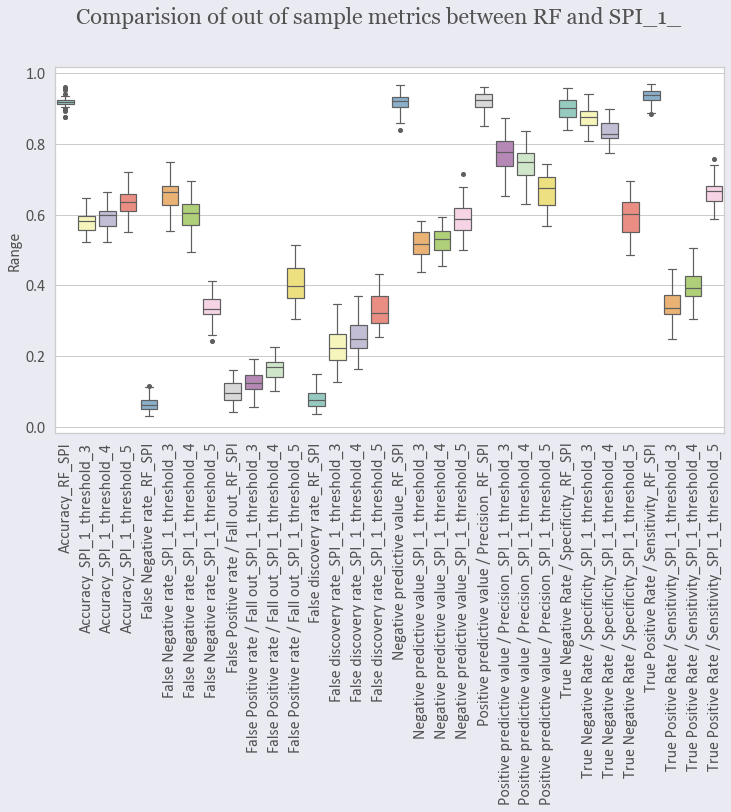

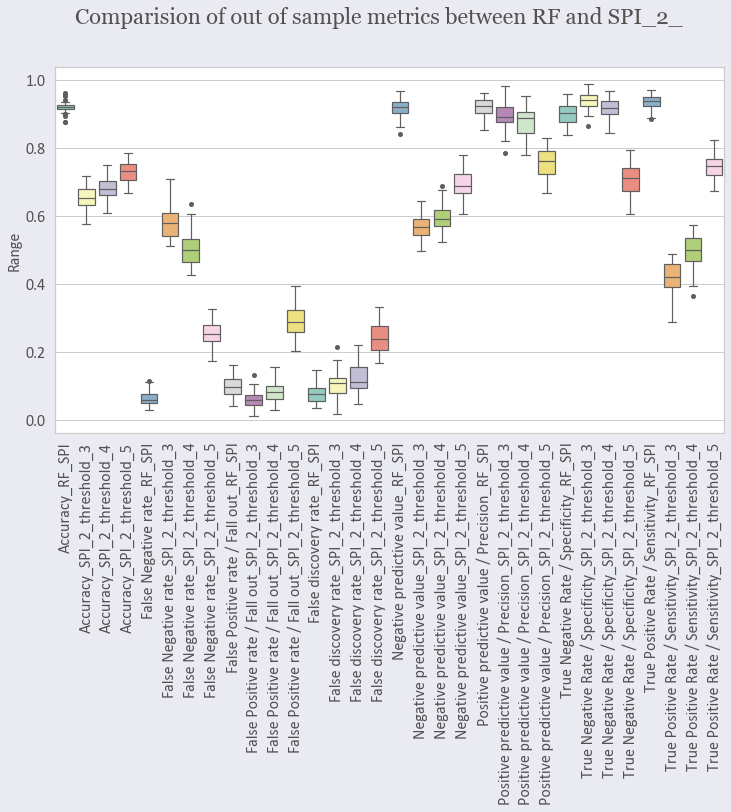

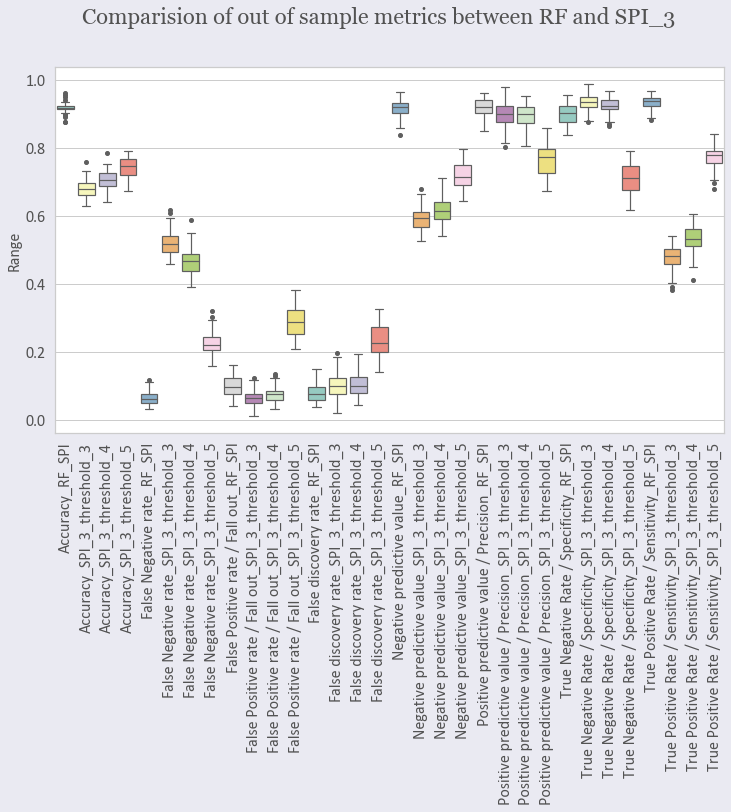

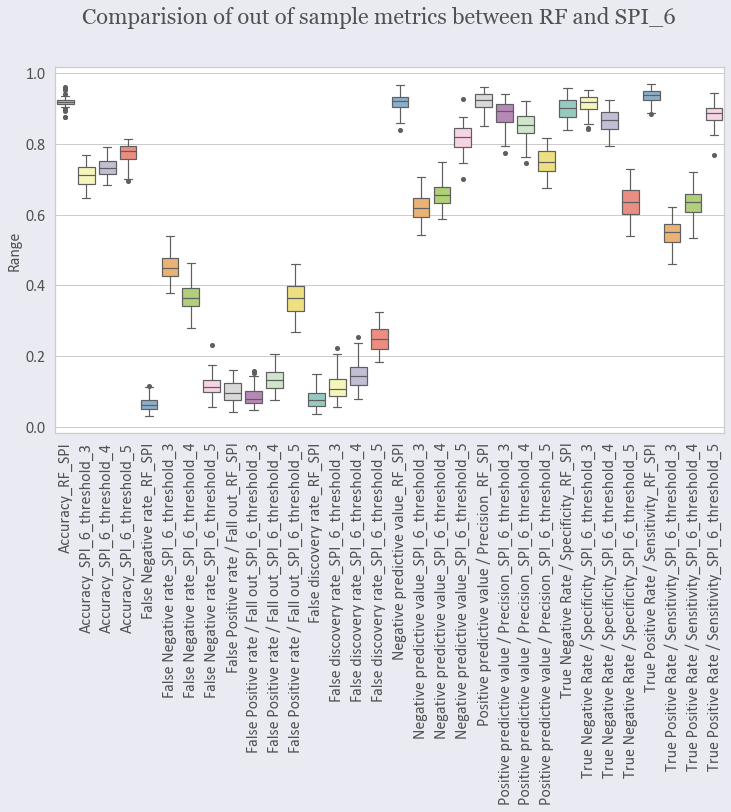

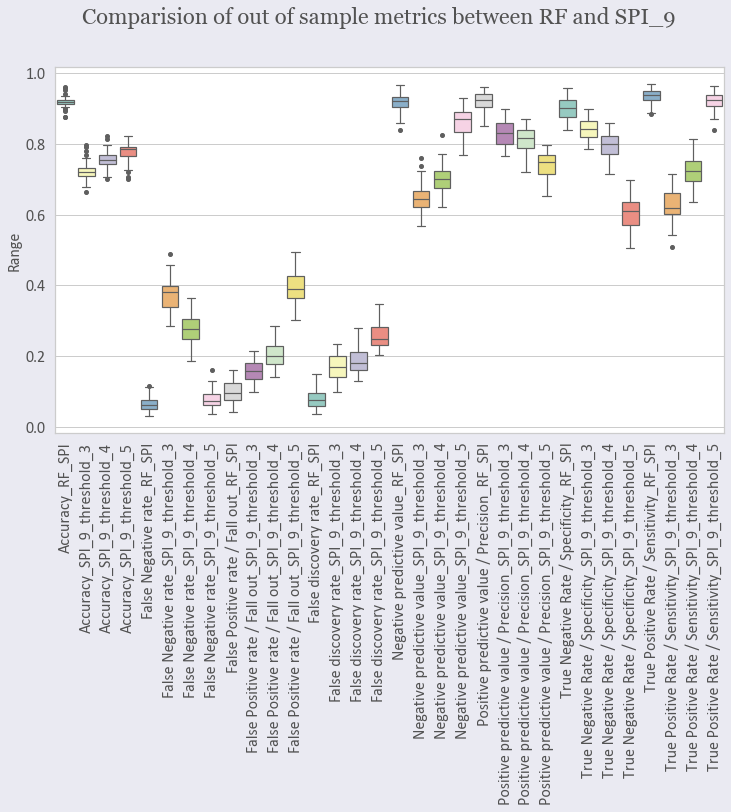

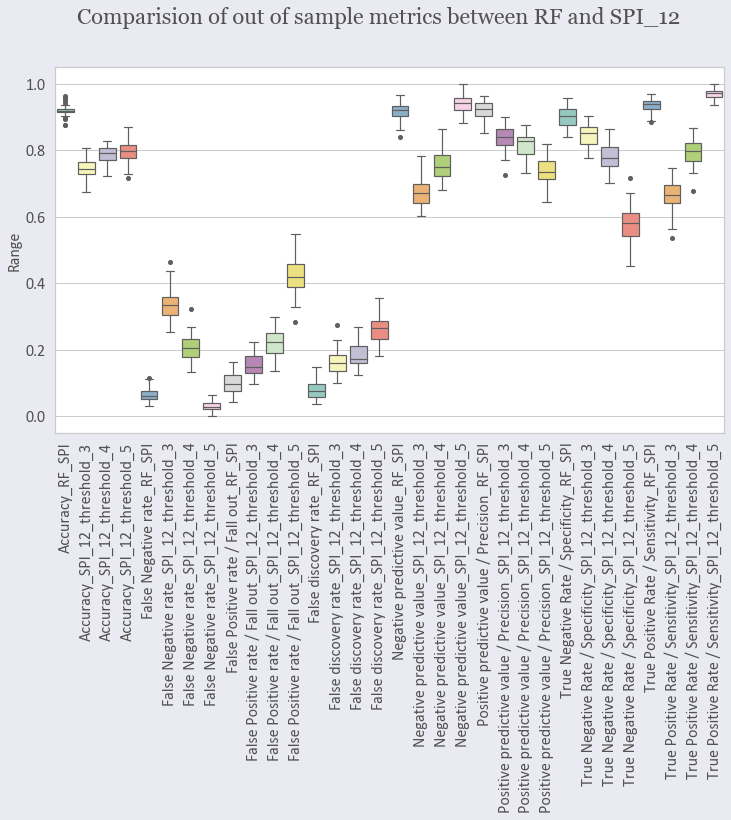

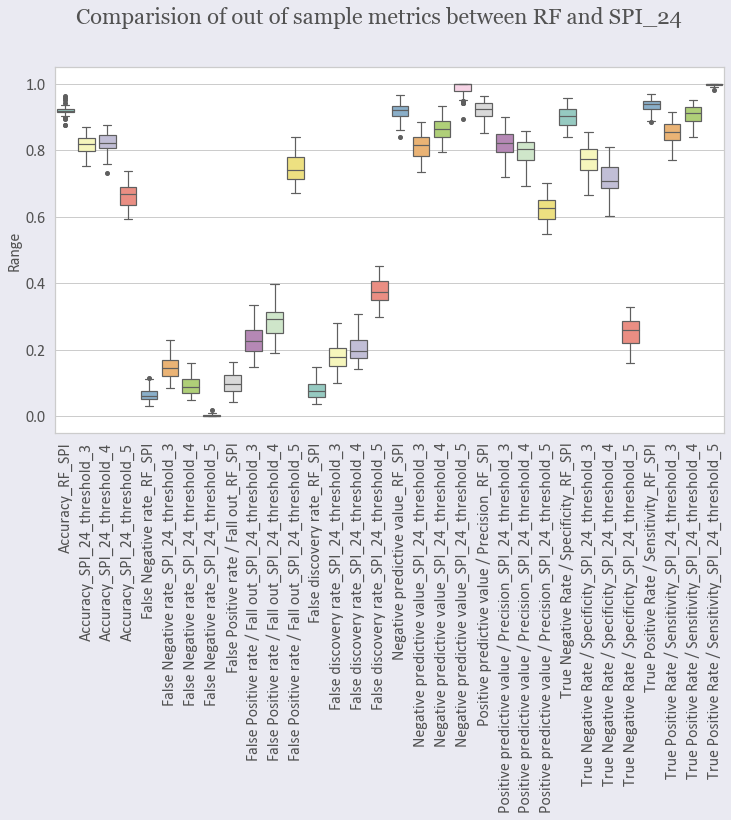

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for spi_name_value in column_names:
    # Reading in file and removing unnamed columns and overall accuracy
    spi_rf_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')
    # Getting a list of column names:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    # Making a tuple that has the start of the column name we want to remove
    unnamed_ov_acc_list = ('Unnamed:','Overall accuracy') #This is a tuple. startswith only takes a tuple of strings
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
    #print(all_unnamed)
    spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    # Now removing all of these
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    tn_fn_tp_fp_names = ('True Positive_SPI','False Positive_SPI','True Negative_SPI','False Negative_SPI','True Positive_RF','False Positive_RF','True Negative_RF','False Negative_RF')
    # creating a list of all the col names that start with Unnamed
    all_contains = [x for x in metrics_col_name_list if x.startswith(tn_fn_tp_fp_names)]
    spi_rf_metrics.drop(columns=all_contains,inplace=True)

    # Getting a list of column names in dataframe:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()

    # Creating tuple of SPI names in dataframe and removing the SPI value I want to plot
    c_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
    c_names.remove(spi_name_value) #https://www.studytonight.com/post/python-how-to-remove-a-specific-element-from-a-list-of-tuples
    print(c_names)

    for column_n in c_names:
        # creating a list of all the col names that contain the above
        all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
        spi_rf_metrics.drop(columns=all_contains,inplace=True)
        
    # Assigning it to a new db name
    rf_spi_db = spi_rf_metrics

    # Rearranging columns alphabetically
    # https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas
    # Creating a list of column names
    col_name = list(rf_spi_db.columns)
    # Sorting alphabetically
    col_name.sort()
    # Sorting columnas and reassigning to the dataframe
    rf_spi_db = rf_spi_db[col_name]

    # Creating figure
    sns.set(style='whitegrid')
    facecolor = '#eaeaf2'
    fig, ax = plt.subplots(figsize=(12, 7), facecolor=facecolor)

    # Create box plot:
    ax = sns.boxplot(data=rf_spi_db, 
                    palette='Set3', 
                    linewidth=1.2, 
                    fliersize=2,
                    flierprops=dict(marker='o', markersize=4))

    # Getting a list of all column names:
    Col_names = list(rf_spi_db.columns.values)

    # Rotating the x labels - Source: https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
    ax.set_xticklabels(labels=Col_names, rotation=90) 

    # Set labels font parameter
    font_color = '#525252'
    csfont = {'fontname':'Georgia'}
    hfont = {'fontname':'Calibri'}

    ax.set_ylabel('Range', fontsize=16, color=font_color, **hfont)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set(fontsize=16, color=font_color, **hfont)

    # Create title:
    title = 'Comparision of out of sample metrics between RF and '+ spi_name_value
    fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
    #subtitle = 'Random state: 0 to 50'
    #plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
    plt.subplots_adjust(top=0.85)

    # Set colour of outlier points: 
    for i, box in enumerate(ax.artists):
        col = box.get_facecolor()
        plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


    # But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
    # Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
    # Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
    # Will do it later:

    # Making sure that the x labels all fit in the saved figure: https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
    # Saving the figure:
    filename = 'sns-boxplot_RFvs'+ str(spi_name_value)
    plt.savefig(filename+'.png', facecolor=facecolor,bbox_inches = "tight")

## Testing

Checking if any extra index columns and dropping them

In [8]:
import pandas as pd
# Opening database with postcodes 935 points
db_SPI = pd.read_csv('SPI_0_and_SPI_0.8_and_SPI_min1_for24_Performance2022_10_09_15_30.csv')

db_SPI.drop(columns = ['Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.7','Unnamed: 0.6','Unnamed: 0.5','Unnamed: 0.4'],inplace=True)
db_SPI.head()
#db_SPI.info()
# Individual values 935

,Year,Month,Year_Month,Geographic Location,Location,Latitude,Longitude,Drought / No Drought,MYD13A3_061__1_km_monthly_EVI,MYD13A3_061__1_km_monthly_NDVI,...,precip_calculated_index,precip_scale_2_calculated_index,precip_scale_3_calculated_index,precip_scale_6_calculated_index,precip_scale_9_calculated_index,precip_scale_12_calculated_index,precip_scale_24_calculated_index,SPI_0_24month,SPI_-0.8_24month,SPI_-1_24month
0,2014,March,2014-03,Cobar,Cobar,-31.4980,145.8383,1,0.1664,0.3052,...,0.961742,0.940975,0.531992,-0.041809,-0.055392,0.098242,-0.730801,1,0,0
1,2014,February,2014-02,Cobar,Cobar,-31.4980,145.8383,1,0.1311,0.2351,...,0.789762,0.261653,0.284911,-0.342077,0.079966,0.068903,-0.560140,1,0,0
2,2014,January,2014-01,Cobar,Cobar,-31.4980,145.8383,1,0.1385,0.2365,...,-0.777240,-0.299197,-0.904306,-1.034412,-0.184868,-0.418143,-0.716573,1,0,0
3,2014,March,2014-03,Walgett,Walgett,-30.0167,148.1167,1,0.2209,0.3371,...,0.060530,-0.500640,-0.882839,-1.393406,-1.324914,-1.539705,-1.343596,1,1,1
4,2014,February,2014-02,Walgett,Walgett,-30.0167,148.1167,1,0.2091,0.3028,...,-0.381371,-0.885833,-1.228032,-1.180281,-1.444103,-0.980432,-1.288062,1,1,1


Checking which column is the drought non drought column

In [9]:
y = db_SPI.iloc[:,7].values #7ths column is drought and no drought
print(y)
X = db_SPI 
X.drop(['Drought / No Drought'],axis = 1,inplace=True)
#Convert to array
X.to_numpy()


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 

array([[2014, 'March', '2014-03', ..., 1, 0, 0],
       [2014, 'February', '2014-02', ..., 1, 0, 0],
       [2014, 'January', '2014-01', ..., 1, 0, 0],
       ...,
       [2021, 'January', '2021-01', ..., 0, 0, 0],
       [2021, 'February', '2021-02', ..., 0, 0, 0],
       [2021, 'March', '2021-03', ..., 0, 0, 0]], dtype=object)

Checking which columns to drop



In [11]:
# For dividing training and testing  
from sklearn.model_selection import train_test_split
#For training the model
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

# Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 

Checking the number of columns that need to be the true X_train and Y_train. ONly the predictors

In [12]:

# To remove the last 10 rows that include SPI values:
# df.iloc[row_start:row_end , col_start:col_end] 
# Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.

X_train = X_train.iloc[:,0:10]
X_test =  X_test.iloc[:,0:10]


Checking what values correspond to CDI0 CDI01 CDI012 etc


In [ ]:
def get_metrics_for_SPI(database_file_name, SPI_number):

    ## IMPORTING:
    # Importing numpy
    import numpy as np
    import pandas as pd
    # For plotting feature importance: 
    import matplotlib.pyplot as plt
    import time
    # For dividing training and testing  
    from sklearn.model_selection import train_test_split
    #For training the model
    from sklearn.ensemble import RandomForestClassifier
    # For metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    # For feature importance plots:
    from sklearn.inspection import permutation_importance

    # Assign variables:
    database_file_name = database_file_name
    SPI_number = SPI_number #This can be 0,1,2,3 or 4. USed for y_pred_0_test etc

    # Opening database with CDI values and CDI0,1234 values
    db_SPI = pd.read_csv(database_file_name + '.csv') #SPI_0_and_SPI_0.8_and_SPI_min1_for24_Performance2022_10_09_15_30.csv
    db_SPI.drop(columns = ['Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.7','Unnamed: 0.6','Unnamed: 0.5','Unnamed: 0.4'],inplace=True) 
    #This is specific to CDI file so make sure you have the correct one. 

    # Dividing data into predictors (X) and no drought/drought (y)
    y = db_SPI.iloc[:,7].values #All rows and only the 7th column (Drought no drought)
   
    X = db_SPI 
    X.drop(['Drought / No Drought'],axis = 1,inplace=True)
    #Convert to array
    X.to_numpy()

    # ----------------------------TRAINING AND RESULTS WITH DIFF RANDOM STATES---------------------------------------------------------------------------------------------------------------------------
    # Creating a dictionary called list_metrics
    acc_lm_SPI = []
    tp_lm_SPI = []
    tn_lm_SPI = []
    fp_lm_SPI = []
    fn_lm_SPI = []

    tpr_lm = []
    tnr_lm = []
    ppv_lm = []
    npv_lm = []
    fpr_lm =[]
    fnr_lm  = []
    fdr_lm = []
    acc_conf_lm = []

    for i in range(51): 
        # ----------------------------SPLITTING TRAINING AND TESTING DATASET--------------------------------------------
        #Dividing data into training and testing: 
        # from sklearn.model_selection import train_test_split
        # I put it above
    
        X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= i)
        
        # Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
        X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
        X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 
        
        # To remove the last 10 rows that include CDI values:
        # df.iloc[row_start:row_end , col_start:col_end] 
        # Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.
        X_train = X_train.iloc[:,0:10]
        X_test =  X_test.iloc[:,0:10]
        # Thus I took all rows and columns from 0 to 10 which means it deleted the last CDI rows. But I had to manually count them. 
        
        # --------------------------------TRAINING THE MODEL---------------------------------------------        
        # Training the model
        # from sklearn.ensemble import RandomForestClassifier # See above
        classifier = RandomForestClassifier(n_estimators=20, random_state=i)
        classifier.fit(X_train, y_train)
        y_pred_classifier = classifier.predict(X_test)
        
        # ----------------------------- GETTING PREDICTIONS------------------------
        #predictions for X_test
        predictions = classifier.predict_proba(X_test)
        # predictions # Col 1 is 0 and Col 2 is 1. We can
        prob_drought = predictions[:,1]
        # prob_drought
        X_test_all['ypred'] = prob_drought
        X_test_all['y_obs'] = y_test
        X_test_all.to_csv('X_test_all_'+ str(i) +'_SPI_9Oct.csv')

        # predictions for X_train to make sure it is correct. This helps to check if it is classifying D/no D correctly
        prediction_train = classifier.predict_proba(X_train)
        # prediction_train # Col 1 is 0 and Col 2 is 1. We can
        prob_drought_train = prediction_train[:,1]
        
        X_train_all['ypred'] = prob_drought_train
        X_train_all['y_obs'] = y_train
        X_train_all.to_csv('X_train_all_'+ str(i) +'_SPI_9Oct.csv')
        
        # ----------------------------GETTING METRICS-------------------------------------------------------
        # confusion matrix + other matrix
        # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
        # See above

        # For confusion matrix later: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
            
        # False Positives:
        # I got inspiration from this: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
        #mistakes = np.invert(y_pred_classifier == y_test)
        #count_fp = np.count_nonzero(mistakes)
        #fp_list_metrics = np.append(fp_list_metrics,count_fp)
        # I later found that it was just calculating mistakes and not false positive.

        # FOR SPI
        y_true_test = y_test #All rows and only the Drought/No drought col
        y_pred_SPI_test = X_test_all.iloc[:,-SPI_number].values #(-5 is 0 ,-4 is -0.8 and -3 is -1)
        #y_pred_08_test = X_test_all.iloc[:,-4].values
        #y_pred_1_test = X_test_all.iloc[:,-3].values

        y_true_train = y_train #All rows and only the Drought/No drought col
        y_pred_SPI_train = X_train_all.iloc[:,-SPI_number].values
        #y_pred_08_train = X_train_all.iloc[:,-4].values
        #y_pred_1_train = X_train_all.iloc[:,-3].values
        
        # Confusion matrix for CDI - true neg, false pos, false neg, true pos:
        tn_SPI, fp_SPI, fn_SPI, tp_SPI = confusion_matrix(y_true_test, y_pred_SPI_test, labels=[0, 1]).ravel()
        
        # I wanted to automatically calculate the rates as well. Source: https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
        fp_SPI = fp_SPI.astype(float)
        fn_SPI = fn_SPI.astype(float)
        tp_SPI = tp_SPI.astype(float)
        tn_SPI = tn_SPI.astype(float)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = tp_SPI/(tp_SPI+fn_SPI)
        # Specificity or true negative rate
        TNR = tn_SPI/(tn_SPI+fp_SPI) 
        # Precision or positive predictive value
        PPV = tp_SPI/(tp_SPI+fp_SPI)
        # Negative predictive value
        NPV = tn_SPI/(tn_SPI+fn_SPI)
        # Fall out or false positive rate
        FPR = fp_SPI/(fp_SPI+tn_SPI)
        # False negative rate
        FNR = fn_SPI/(tp_SPI+fn_SPI)
        # False discovery rate
        FDR = fp_SPI/(tp_SPI+fp_SPI)
        # Overall accuracy
        ACC_conf = (tp_SPI+tn_SPI)/(tp_SPI+fp_SPI+fn_SPI+tn_SPI)

        tn_lm_CDI = np.append(tn_lm_CDI,tn_SPI)
        fp_lm_CDI = np.append(fp_lm_CDI,fp_SPI)
        fn_lm_CDI = np.append(fn_lm_CDI,fn_SPI)
        tp_lm_CDI = np.append(tp_lm_CDI,tp_SPI)
        tpr_lm = np.append(tpr_lm, TPR)
        tnr_lm = np.append(tnr_lm, TNR)
        ppv_lm = np.append(ppv_lm, PPV)
        npv_lm = np.append(npv_lm, NPV)
        fpr_lm = np.append(fpr_lm, FPR)
        fnr_lm  = np.append(fnr_lm, FNR)
        fdr_lm = np.append(fdr_lm, FDR)
        acc_conf_lm = np.append(acc_conf_lm, ACC_conf)



        # Accuracy for CDI:
        acc_SPI = accuracy_score(y_true_test, y_pred_SPI_test)
        acc_lm_SPI= np.append(acc_lm_SPI,acc_SPI)

        ## CDI Classification report:
        # Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
        # Function
        def SPI_classification_report_csv(report,rd_state):
            report_data = []
            lines = report.split('\n')
            for line in lines[2:-5]:
                row = {}
                
                row_data = ' '.join(line.split())   
                row_data = row_data.split(' ')
                
                row['class'] = row_data[0]
                row['precision'] = float(row_data[1])
                row['recall'] = float(row_data[2])
                row['f1_score'] = float(row_data[3])
                row['support'] = float(row_data[4])
                report_data.append(row)
                # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

            dataframe = pd.DataFrame.from_dict(report_data)
            dataframe.to_csv('SPI_'+ str(SPI_number) +'_classification_report_test_9Oct2022_'+ str(rd_state) + '.csv', index = False)
        
        report = classification_report(y_true_test, y_pred_SPI_test)
        SPI_classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to.

        
    # It is cheaper to fill out a list than fill out a dataframe: https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
    # For CDI:
    
    df_acc_SPI = pd.DataFrame(acc_lm_SPI)
    df_acc_SPI.rename(columns = {"0":"Accuracy"}, inplace = True)
    df_acc_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_Acc_test_9Oct.csv')
        
    df_tn_SPI = pd.DataFrame(tn_lm_SPI)
    df_tn_SPI.rename(columns = {"0":"True Negative"}, inplace = True)
    df_tn_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_trueneg_test_9Oct.csv')

    df_fp_SPI = pd.DataFrame(fp_lm_SPI)
    df_fp_SPI.rename(columns = {"0":"False Positive"}, inplace = True)
    df_fp_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_falsepos_test_9Oct.csv')

    df_fn_SPI = pd.DataFrame(fn_lm_SPI)
    df_fn_SPI.rename(columns = {"0":"False Negative"}, inplace = True)

    df_fn_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_falseneg_test_9Oct.csv')

    df_tp_SPI = pd.DataFrame(tp_lm_SPI)
    df_tp_SPI.rename(columns = {"0":"True Positive"}, inplace = True)
    df_tp_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_truepos_test_9Oct.csv')

    tpr_lm_df = pd.DataFrame(tpr_lm)
    tpr_lm_df.rename(columns = {"0":"True Positive Rate / Sensitivity"}, inplace = True)
    tpr_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_tpr_9Oct.csv')

    tnr_lm_df = pd.DataFrame(tnr_lm)
    tnr_lm_df.rename(columns = {"0":"True Negative Rate / Specificity"}, inplace = True)
    tnr_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_tnr_9Oct.csv')
    
    ppv_lm_df = pd.DataFrame(ppv_lm)
    ppv_lm_df.rename(columns = {"0":"Positive predictive value / Precision"}, inplace = True)
    
    ppv_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_ppv_9Oct.csv')
    npv_lm_df = pd.DataFrame(npv_lm)
    npv_lm_df.rename(columns = {"0":"Negative predictive value"}, inplace = True)
    npv_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_npv_9Oct.csv')

    fpr_lm_df = pd.DataFrame(fpr_lm)
    fpr_lm_df.rename(columns = {"0":"False Positive rate / Fall out"}, inplace = True)
    fpr_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_fpr_9Oct.csv')

    fnr_lm_df = pd.DataFrame(fnr_lm)
    fnr_lm_df.rename(columns = {"0":"False Negative rate"}, inplace = True)
    fnr_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_fnr_9Oct.csv')

    fdr_lm_df = pd.DataFrame(fdr_lm)
    fdr_lm_df.rename(columns = {"0":"False discovery rate"}, inplace = True)
    fdr_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_fdr_9Oct.csv')

    acc_conf_lm_df = pd.DataFrame(acc_conf_lm)
    acc_conf_lm_df.rename(columns = {"0":"Overall accuracy (from conf m)"}, inplace = True)
    acc_conf_lm_df.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_acc_conf_9Oct.csv')

    # SPI
    ##Combining classification reports
    import glob
    import os
    ##Setting path of files and giving name
    files_SPI = os.path.join("SPI_"+ str(SPI_number) +"_classification_report_test_9Oct2022*.csv")
    ##List of merged files returned
    files_SPI = glob.glob(files_SPI)
    ## Join files with concat
    df_files_SPI = pd.concat(map(pd.read_csv, files_SPI), ignore_index=True)
    # print(df_files)
    ##Saving to csv
    df_files_SPI.to_csv('SPI_'+ str(SPI_number) +'_Random_state_0_to_50_Classification_Report_Final_9Oct.csv')

    # To just combine accuracy and confusion matrix    
    ## Combining Acc and Confusion Matrix: Source:https://www.statology.org/pandas-merge-multiple-dataframes/
    from functools import reduce

    #define list of DataFrames
    dfs = [df_acc_SPI, df_fp_SPI, df_fn_SPI, df_tp_SPI , df_tn_SPI, tpr_lm_df,tnr_lm_df,ppv_lm_df,npv_lm_df,fpr_lm_df,fnr_lm_df,fdr_lm_df,acc_conf_lm_df]

    #merge all DataFrames into one
    #final_df = reduce(lambda  left,right: pd.merge(left,right,how='left'), dfs)
    # Trying to merge on index singe the above merges it by attaching it below. 
    final_df = reduce(lambda  left,right: pd.merge(left,right,left_index = True,right_index=True, how='outer'), dfs)

    final_df.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_Rates_CDI'+ str(SPI_number) +'_0_to_50_test_5Oct.csv')


# Creating function to generate metrics
.

In [76]:
# Downloading database:
database_pred = pd.read_csv('SPI_1_and_SPI_0.8_and_SPI_min1_for24_Performance2022_09_01_15_08.csv')

# Creating dictionaries that will be used. 
acc_list_metrics = []
tp_list_metrics = []
tn_list_metrics = []
fp_list_metrics = []
fn_list_metrics = []

acc_lm_SPI0 = []
tp_lm_SPI0 = []
tn_lm_SPI0 = []
fp_lm_SPI0 = []
fn_lm_SPI0 = []

,Year,Month,Year_Month,Geographic Location,Location,Latitude,Longitude,Drought / No Drought,MYD13A3_061__1_km_monthly_EVI,MYD13A3_061__1_km_monthly_NDVI,...,precip_calculated_index,precip_scale_2_calculated_index,precip_scale_3_calculated_index,precip_scale_6_calculated_index,precip_scale_9_calculated_index,precip_scale_12_calculated_index,precip_scale_24_calculated_index,SPI_0_24month,SPI_-0.8_24month,SPI_-1_24month
0,2014,March,2014-03,Cobar,Cobar,-31.4980,145.8383,1,0.1664,0.3052,...,0.961742,0.940975,0.531992,-0.041809,-0.055392,0.098242,-0.730801,1,0,0
1,2014,February,2014-02,Cobar,Cobar,-31.4980,145.8383,1,0.1311,0.2351,...,0.789762,0.261653,0.284911,-0.342077,0.079966,0.068903,-0.560140,1,0,0
2,2014,January,2014-01,Cobar,Cobar,-31.4980,145.8383,1,0.1385,0.2365,...,-0.777240,-0.299197,-0.904306,-1.034412,-0.184868,-0.418143,-0.716573,1,0,0
3,2014,March,2014-03,Walgett,Walgett,-30.0167,148.1167,1,0.2209,0.3371,...,0.060530,-0.500640,-0.882839,-1.393406,-1.324914,-1.539705,-1.343596,1,1,1
4,2014,February,2014-02,Walgett,Walgett,-30.0167,148.1167,1,0.2091,0.3028,...,-0.381371,-0.885833,-1.228032,-1.180281,-1.444103,-0.980432,-1.288062,1,1,1


In [5]:
import pandas as pd

database_pred = pd.read_csv('SPI_1_and_SPI_0.8_and_SPI_min1_for24_Performance2022_09_01_15_08.csv')

database_pred.drop(['Unnamed: 0.7','Unnamed: 0.6','Unnamed: 0.5','Unnamed: 0.4','Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'],axis = 1,inplace=True)

y = database_pred.iloc[:,7].values #All rows and only the 4th column (Drought no drought)
X = database_pred 
X.drop(['Drought / No Drought'],axis = 1,inplace=True)
#Convert to array
X.to_numpy()

# For dividing training and testing  
from sklearn.model_selection import train_test_split

X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

# Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 
# To remove the last 10 rows that include SPI values:
# df.iloc[row_start:row_end , col_start:col_end] 
# Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.

X_train = X_train.iloc[:,0:-11] #(columns=X_train.columns[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10],inplace = True)
X_test =  X_test.iloc[:,0:-11] #X_test.drop(columns=X_test.columns[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10],inplace = True)
# Thus I took all rows and columns from 0 to -11 which means it deleted the last SPI rows. But I had to manually count them. 

In [89]:
X_train_all.head()

,Year,Month,Year_Month,Geographic Location,Location,Latitude,Longitude,MYD13A3_061__1_km_monthly_EVI,MYD13A3_061__1_km_monthly_NDVI,MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description,...,precip_calculated_index,precip_scale_2_calculated_index,precip_scale_3_calculated_index,precip_scale_6_calculated_index,precip_scale_9_calculated_index,precip_scale_12_calculated_index,precip_scale_24_calculated_index,SPI_0_24month,SPI_-0.8_24month,SPI_-1_24month
386,2019,March,2019-03,Coonabarabran,Coonabarabran,-31.2500,149.2667,0.1805,0.3290,['Lower quality'],...,0.867116,-0.257341,-0.477931,-0.629443,-0.972133,-1.361274,-1.847927,1,1,1
624,2019,January,2019-01,Wilcannia,Wilcannia,-31.5590,143.3785,0.1343,0.1982,['Highest quality'],...,0.013265,-0.287821,-0.324588,-0.542584,-1.315368,-1.505437,-1.603010,1,1,1
892,2014,May,2014-05,Coonamble,Coonamble,-30.9500,148.4000,0.2725,0.4030,['Lower quality'],...,-0.259716,-0.188521,0.394876,-0.389972,-1.002450,-0.874382,-1.299652,1,1,1
85,2019,June,2019-06,Pooncarie,Pooncarie,-33.3856,142.5702,0.2461,0.4150,['Lower quality'],...,-0.481514,0.363664,-0.305837,-1.052913,-0.604271,-1.037716,-1.127823,1,1,1
812,2020,November,2020-11,Bermagui,Bermagui,-36.4167,150.0667,0.1755,0.4522,['Highest quality'],...,-0.146733,1.127099,0.655991,1.544478,0.970189,0.588352,-0.473042,1,0,0


In [7]:
X_test_all.head()

,Year,Month,Year_Month,Geographic Location,Location,Latitude,Longitude,MYD13A3_061__1_km_monthly_EVI,MYD13A3_061__1_km_monthly_NDVI,MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description,...,precip_calculated_index,precip_scale_2_calculated_index,precip_scale_3_calculated_index,precip_scale_6_calculated_index,precip_scale_9_calculated_index,precip_scale_12_calculated_index,precip_scale_24_calculated_index,SPI_0_24month,SPI_-0.8_24month,SPI_-1_24month
689,2019,October,2019-10,Gongolgon,Gongolgon,-30.3495,146.8963,0.1305,0.1911,['Highest quality'],...,-1.978692,-2.262605,-2.746251,-2.900403,-2.487515,-1.904470,-1.520899,1,1,1
236,2021,January,2021-01,Oxley,Oxley,-34.1985,144.0993,0.1842,0.3114,['Highest quality'],...,0.666480,0.177824,-0.341958,0.788008,0.326512,0.570001,-0.212544,1,0,0
738,2019,March,2019-03,Menindee,Menindee,-32.4005,142.4116,0.1315,0.1890,['Highest quality'],...,0.466084,-0.087835,-0.474805,0.055943,-0.429558,-0.965296,-1.422283,1,1,1
766,2020,May,2020-05,Walgett,Walgett,-30.0167,148.1167,0.3107,0.4931,['Lower quality'],...,-0.839658,1.223037,1.129214,0.549958,0.036580,-0.421959,-1.022193,1,1,1
266,2020,January,2020-01,Blayney,Blayney,-33.5333,149.2500,0.2131,0.3071,['Highest quality'],...,0.013430,-1.139118,-1.180189,-1.269625,-1.206775,-1.386689,-1.415324,1,1,1


In [ ]:
# Importing numpy
import numpy as np
import pandas as pd
# For plotting feature importance: 
import matplotlib.pyplot as plt
import time
# For dividing training and testing  
from sklearn.model_selection import train_test_split
#For training the model
from sklearn.ensemble import RandomForestClassifier
# For metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# I ended up not using confusion matrix. But I could actually calculate it. 
# For feature importance plots:
from sklearn.inspection import permutation_importance

# Downloading database:
database_pred = pd.read_csv('SPI_1_and_SPI_0.8_and_SPI_min1_Performance2022_08_25_18_53.csv')
# Dropping unecessary columns -  removing IPO and NDVI and EVI
database_pred.drop(['Unnamed: 0','Unnamed: 0.1','Year_Month','Latitude','Longitude', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1,inplace=True)

# Dividing data into predictors (X) and no drought/drought (y)
y = database_pred.iloc[:,4].values #All rows and only the 4th column (Drought no drought)
X = database_pred 
X.drop(['Drought / No Drought'],axis = 1,inplace=True)
#Convert to array
X.to_numpy()

# ----------------------------TRAINING AND RESULTS WITH DIFF RANDOM STATES---------------------------------------------------------------------------------------------------------------------------
# Creating a dictionary called list_metrics
acc_list_metrics = []
tp_list_metrics = []
tn_list_metrics = []
fp_list_metrics = []
fn_list_metrics = []

acc_lm_SPI0 = []
tp_lm_SPI0 = []
tn_lm_SPI0 = []
fp_lm_SPI0 = []
fn_lm_SPI0 = []

for i in range(51): 
    # ----------------------------SPLITTING TRAINING AND TESTING DATASET--------------------------------------------
    #Dividing data into training and testing: 
    # from sklearn.model_selection import train_test_split
    # I put it above
 
    X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 0)

    # Then we create the real X_train and X_test by removing those columns. This allows us to more easily see which ones were an issue. 
    X_train = X_train_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location', 'MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1)
    X_test = X_test_all.drop(['Year_Month','Latitude','Longitude','Year','Month','Geographic Location','Location','MYD13A3_061__1_km_monthly_EVI','MYD13A3_061__1_km_monthly_NDVI','MYD13A3_061__1_km_monthly_VI_Quality_VI_Usefulness_Description','IPO_TPI'],axis = 1) 
    # To remove the last 10 rows that include SPI values:
    # df.iloc[row_start:row_end , col_start:col_end] 
    # Source: https://thispointer.com/pandas-delete-last-column-of-dataframe-in-python/#:~:text=Use%20drop()%20to%20remove,last%20column%20of%20pandas%20dataframe.

    X_train = X_train.iloc[:,0:-11] #(columns=X_train.columns[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10],inplace = True)
    X_test =  X_test.iloc[:,0:-11] #X_test.drop(columns=X_test.columns[-1,-2,-3,-4,-5,-6,-7,-8,-9,-10],inplace = True)
    # Thus I took all rows and columns from 0 to -11 which means it deleted the last SPI rows. But I had to manually count them. 
    
    # --------------------------------TRAINING THE MODEL---------------------------------------------        
    # Training the model
    # from sklearn.ensemble import RandomForestClassifier # See above
    classifier = RandomForestClassifier(n_estimators=20, random_state=i)
    classifier.fit(X_train, y_train)
    y_pred_classifier = classifier.predict(X_test)
    
    # ----------------------------- GETTING PREDICTIONS------------------------
    #predictions for X_test
    predictions = classifier.predict_proba(X_test)
    # predictions # Col 1 is 0 and Col 2 is 1. We can
    prob_drought = predictions[:,1]
    # prob_drought
    X_test_all['ypred'] = prob_drought
    X_test_all['y_obs'] = y_test
    #X_test_all.to_csv('X_test_all_'+ str(i) +'_17Aug.csv')

    # predictions for X_train to make sure it is correct. This helps to check if it is classifying D/no D correctly
    prediction_train = classifier.predict_proba(X_train)
    # prediction_train # Col 1 is 0 and Col 2 is 1. We can
    prob_drought_train = prediction_train[:,1]
    
    X_train_all['ypred'] = prob_drought_train
    X_train_all['y_obs'] = y_train
    #X_train_all.to_csv('X_train_all_'+ str(i) +'_17Aug.csv')
    
    # ----------------------------GETTING METRICS-------------------------------------------------------
    # confusion matrix + other matrix
    # from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
    # See above

    # For confusion matrix later: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
        
    # False Positives:
    # I got inspiration from this: https://datascience.stackexchange.com/questions/87654/is-there-a-flexible-way-to-get-the-original-data-indices-from-each-cell-of-a-con
    #mistakes = np.invert(y_pred_classifier == y_test)
    #count_fp = np.count_nonzero(mistakes)
    #fp_list_metrics = np.append(fp_list_metrics,count_fp)
    # I later found that it was just calculating mistakes and not false positive.

    # FOR SPI
    y_true_test = y_test #All rows and only the Drought/No drought col
    y_pred_0_test = X_test_all.iloc[:,-5].values
    y_pred_08_test = X_test_all.iloc[:,-4].values
    y_pred_1_test = X_test_all.iloc[:,-3].values

    y_true_train = y_train #All rows and only the Drought/No drought col
    y_pred_0_train = X_train_all.iloc[:,-5].values
    y_pred_08_train = X_train_all.iloc[:,-4].values
    y_pred_1_train = X_train_all.iloc[:,-3].values
    
    # Confusion matrix - true neg, false pos, false neg, true pos:
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classifier, labels=[0, 1]).ravel()

    tn_list_metrics = np.append(tn_list_metrics,tn)
    fp_list_metrics = np.append(fp_list_metrics,fp)
    fn_list_metrics = np.append(fn_list_metrics,fn)
    tp_list_metrics = np.append(tp_list_metrics,tp)

    # Confusion matrix for SPI - true neg, false pos, false neg, true pos:
    tn_SPI0, fp_SPI0, fn_SPI0, tp_SPI0 = confusion_matrix(y_true_test, y_pred_0_test, labels=[0, 1]).ravel()

    tn_lm_SPI0 = np.append(tn_lm_SPI0,tn_SPI0)
    fp_lm_SPI0 = np.append(fp_lm_SPI0,fp_SPI0)
    fn_lm_SPI0 = np.append(fn_lm_SPI0,fn_SPI0)
    tp_lm_SPI0 = np.append(tp_lm_SPI0,tp_SPI0)

    # Accuracy:
    acc = accuracy_score(y_test, y_pred_classifier)
    acc_list_metrics= np.append(acc_list_metrics,acc)

    # Accuracy for SPI:
    acc_SPI0 = accuracy_score(y_true_test, y_pred_0_test)
    acc_lm_SPI0= np.append(acc_lm_SPI0,acc_SPI0)

    # Classification report:
    # Source: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format
    # Function
    def classification_report_csv(report,rd_state):
        report_data = []
        lines = report.split('\n')
        for line in lines[2:-5]:
            row = {}
            
            row_data = ' '.join(line.split())   
            row_data = row_data.split(' ')
            
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
            # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv('classification_report_'+'25Aug2022_'+ str(rd_state) + '.csv', index = False)
    
    report = classification_report(y_test, y_pred_classifier)
    classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to. 

    ## SPI
    def SPI_classification_report_csv(report,rd_state):
        report_data = []
        lines = report.split('\n')
        for line in lines[2:-5]:
            row = {}
            
            row_data = ' '.join(line.split())   
            row_data = row_data.split(' ')
            
            row['class'] = row_data[0]
            row['precision'] = float(row_data[1])
            row['recall'] = float(row_data[2])
            row['f1_score'] = float(row_data[3])
            row['support'] = float(row_data[4])
            report_data.append(row)
            # return report_data #https://stackoverflow.com/questions/3052793/python-output-from-functions

        dataframe = pd.DataFrame.from_dict(report_data)
        dataframe.to_csv('SPI0_classification_report_'+'25Aug2022_'+ str(rd_state) + '.csv', index = False)
    
    report = classification_report(y_true_test, y_pred_0_test)
    SPI_classification_report_csv(report,i) # Previously I assigned it a variable but it returns a csv anyway so I dont need to.

    
# It is cheaper to fill out a list than fill out a dataframe: https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it
df_acc_metrics = pd.DataFrame(acc_list_metrics)
df_acc_metrics.to_csv('Random_state_0_to_50_Acc_25Aug.csv')
    
df_tn_metrics = pd.DataFrame(tn_list_metrics)
df_tn_metrics.to_csv('Random_state_0_to_50_trueneg_25Aug.csv')

df_fp_metrics = pd.DataFrame(fp_list_metrics)
df_fp_metrics.to_csv('Random_state_0_to_50_falsepos_25Aug.csv')

df_fn_metrics = pd.DataFrame(fn_list_metrics)
df_fn_metrics.to_csv('Random_state_0_to_50_falseneg_25Aug.csv')

df_tp_metrics = pd.DataFrame(tp_list_metrics)
df_tp_metrics.to_csv('Random_state_0_to_50_truepos_25Aug.csv')

# For SPI:
df_acc_SPI0 = pd.DataFrame(acc_lm_SPI0)
df_acc_SPI0.to_csv('SPI0_Random_state_0_to_50_Acc_25Aug.csv')
    
df_tn_SPI0 = pd.DataFrame(tn_lm_SPI0)
df_tn_SPI0.to_csv('SPI0_Random_state_0_to_50_trueneg_25Aug.csv')

df_fp_SPI0 = pd.DataFrame(fp_lm_SPI0)
df_fp_SPI0.to_csv('SPI0_Random_state_0_to_50_falsepos_25Aug.csv')

df_fn_SPI0 = pd.DataFrame(fn_lm_SPI0)
df_fn_SPI0.to_csv('SPI0_Random_state_0_to_50_falseneg_25Aug.csv')

df_tp_SPI0 = pd.DataFrame(tp_lm_SPI0)
df_tp_SPI0.to_csv('SPI0_Random_state_0_to_50_truepos_25Aug.csv')


##Combining classification reports
import glob
import os
##Setting path of files and giving name
files = os.path.join("classification_report_25Aug2022*.csv")
##List of merged files returned
files = glob.glob(files)
## Join files with concat
df_files = pd.concat(map(pd.read_csv, files), ignore_index=True)
# print(df_files)
##Saving to csv
df_files.to_csv('Random_state_0_to_50_Classification_Report_Final_25Aug.csv')

# SPI
##Setting path of files and giving name
files_SPI = os.path.join("SPI0_classification_report_25Aug2022*.csv")
##List of merged files returned
files_SPI = glob.glob(files_SPI)
## Join files with concat
df_files_SPI = pd.concat(map(pd.read_csv, files_SPI), ignore_index=True)
# print(df_files)
##Saving to csv
df_files_SPI.to_csv('SPI0_Random_state_0_to_50_Classification_Report_Final_25Aug.csv')




In [ ]:
# To just combine accuracy and confusion matrix
df_acc_metrics.rename(columns = {"0":"Accuracy"}, inplace = True)
df_fp_metrics.rename(columns = {"0":"False Positive"}, inplace = True)
df_fn_metrics.rename(columns = {"0":"False Negative"}, inplace = True)
df_tp_metrics.rename(columns = {"0":"True Positive"}, inplace = True)
df_tn_metrics.rename(columns = {"0":"True Negative"}, inplace = True)

# SPI
df_acc_SPI0.rename(columns = {"0":"Accuracy"}, inplace = True)
df_fp_SPI0.rename(columns = {"0":"False Positive"}, inplace = True)
df_fn_SPI0.rename(columns = {"0":"False Negative"}, inplace = True)
df_tp_SPI0.rename(columns = {"0":"True Positive"}, inplace = True)
df_tn_SPI0.rename(columns = {"0":"True Negative"}, inplace = True)

# Combining dataframes. 
comb_metrics = df_acc_metrics.join(df_tn_metrics,lsuffix='_left', rsuffix='_right') #https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
#comb_metrics.drop(comb_metrics.columns[[0,2]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fp_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[2]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fn_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[3]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tp_metrics,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[4]], axis = 1, inplace = True) #Dropping extra index that appear
## SPI
comb_metrics = comb_metrics.join(df_acc_SPI0,lsuffix='_left', rsuffix='_right') #https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
#comb_metrics.drop(comb_metrics.columns[[5]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fp_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[6]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_fn_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[7]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tp_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[8]], axis = 1, inplace = True) #Dropping extra index that appear
comb_metrics = comb_metrics.join(df_tn_SPI0,lsuffix='_left', rsuffix='_right')
#comb_metrics.drop(comb_metrics.columns[[9]], axis = 1, inplace = True) #Dropping extra index that appear

comb_metrics.to_csv('Combined_Metrics_Accuracy_Conf_Matrix_SPI_0_to_50_25Aug.csv')


# GGPLOT

In [3]:
import ggplot
import pandas

metrics_comb = pandas.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_SPI_0_to_50_25Aug.csv')
metrics_comb.info()

# Error: AttributeError: module 'pandas' has no attribute 'tslib'
# Solution: https://github.com/yhat/ggpy/issues/662
# I would prefer using seaborn instead

AttributeError: module 'pandas' has no attribute 'tslib'

In [28]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

metrics_comb = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_RATES_SPI_0_to_50_25Aug.csv')
metrics_comb.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     51 non-null     int64  
 1   Accuracy_RF    51 non-null     float64
 2   Accuracy_SPI0  51 non-null     float64
 3   TN_RF          51 non-null     int64  
 4   TN_SPI0        51 non-null     int64  
 5   FP_RF          51 non-null     int64  
 6   FP_SPI0        51 non-null     int64  
 7   FN_RF          51 non-null     int64  
 8   FN_SPI0        51 non-null     int64  
 9   TP_RF          51 non-null     int64  
 10  TP_SPI0        51 non-null     int64  
 11  FP_RF_Rate     51 non-null     float64
 12  FP_SPI0_Rate   51 non-null     float64
 13  FN_RF_Rate     51 non-null     float64
 14  FN_SPI0_Rate   51 non-null     float64
dtypes: float64(6), int64(9)
memory usage: 6.1 KB


In [29]:
metrics_comb.drop(columns=['Unnamed: 0','TN_RF','FP_RF','FN_RF','TP_RF','TN_SPI0','FP_SPI0','FN_SPI0','TP_SPI0'],inplace=True)
metrics_comb.head()

,Accuracy_RF,Accuracy_SPI0,FP_RF_Rate,FP_SPI0_Rate,FN_RF_Rate,FN_SPI0_Rate
0,0.925134,0.673797,0.042781,0.149733,0.032086,0.176471
1,0.925134,0.663102,0.042781,0.171123,0.032086,0.165775
2,0.919786,0.550802,0.042781,0.240642,0.037433,0.208556
3,0.914439,0.593583,0.042781,0.208556,0.042781,0.197861
4,0.925134,0.572193,0.042781,0.219251,0.032086,0.208556


AttributeError: 'list' object has no attribute 'artists'

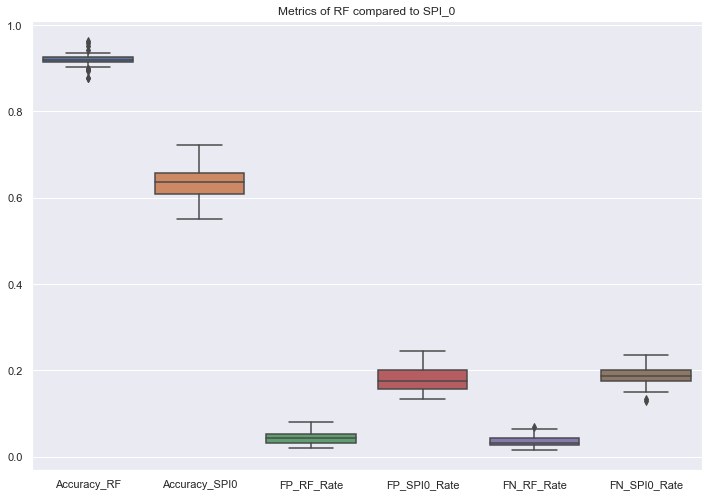

In [33]:
# Example: https://stackoverflow.com/questions/49554139/boxplot-of-multiple-columns-of-a-pandas-dataframe-on-the-same-figure-seaborn
# How to change length and colour - https://pythonbasics.org/seaborn-boxplot/
# Set figure size:
sns.set(rc={'figure.figsize':(12,8.27)}) #https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot

#Plotting
ax = sns.boxplot(data=metrics_comb).set(title='Metrics of RF compared to SPI_0') #https://www.statology.org/seaborn-title/
# Adding values to quartiles:
# Source: https://stackoverflow.com/questions/68473150/using-seaborn-how-to-show-the-value-of-quantiles-in-a-boxplot
# This did not work

# Error: AttributeError: 'list' object has no attribute 'artists'
# Fix: https://stackoverflow.com/questions/48376000/matplotlib-plotting-attributeerror-list-object-has-no-attribute-xaxis
# Did not use

# THis is a good link with sorting the columns: https://sharkcoder.com/data-visualization/seaborn-boxplot 
# Colour of outliers: 
for i, box in enumerate(ax.artists):
    col = box.get_facecolor()
    plt.setp(ax.lines[i*6+5], mfc=col, mec=col)
# Setting labels font parameter:
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='semibold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
    )
    

# Saving figure
# plt.savefig('RF_and_SPI0_Acc_n_FP_FN_Rate.png')

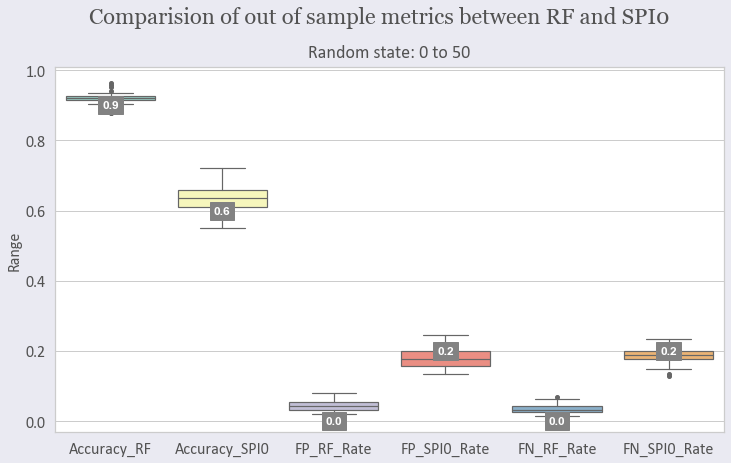

In [46]:
# Creating figure
sns.set(style='whitegrid')
facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(12, 7), facecolor=facecolor)

# Create box plot:
ax = sns.boxplot(data=metrics_comb, 
                 palette='Set3', 
                 linewidth=1.2, 
                 fliersize=2,
                 flierprops=dict(marker='o', markersize=4))

# Set labels font parameter
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

ax.set_ylabel('Range', fontsize=16, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

# Create title:
title = 'Comparision of out of sample metrics between RF and SPI0'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
subtitle = 'Random state: 0 to 50'
plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
plt.subplots_adjust(top=0.85)

# Set colour of outlier points: 
for i, box in enumerate(ax.artists):
    col = box.get_facecolor()
    plt.setp(ax.lines[i*6+5], mfc=col, mec=col)

# Set labels for median values:
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    y = round(lines[4+cat*6].get_ydata()[0],1) 
    ax.text(
        cat, 
        y, 
        f'{y}', 
        ha='center', 
        va='center', 
        fontweight='semibold', 
        size=12,
        color='white',
        bbox=dict(facecolor='#828282', edgecolor='#828282')
    )
# But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
# Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
# Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
# Will do it later:

filename = 'sns-boxplot_RFvsSPI0'
plt.savefig(filename+'.png', facecolor=facecolor)


In [44]:
y

0.2

# Getting location data 29/10/22

In [6]:
import pandas as pd
location_file = pd.read_csv('Database_All_AWRA_NDVI_MOf_and_3MPrecip_noWel_SPI_24month_data2022_09_01_11_45.csv', encoding = 'unicode_escape')
location_file.drop_duplicates(subset = ["Location"],inplace = True)
list_of_locations = location_file[['Location','Latitude','Longitude']]
list_of_locations
list_of_locations.to_csv('List_of_Locations_29_Oct_22.csv')

# Plotting

c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users

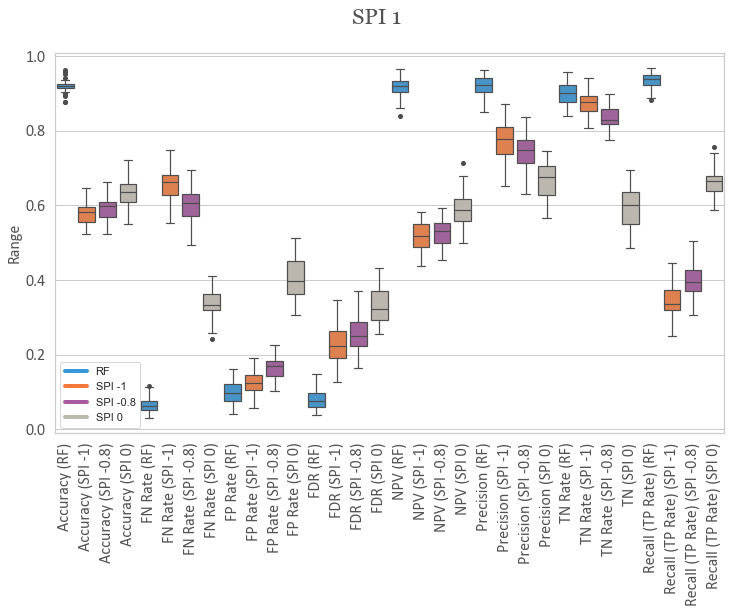

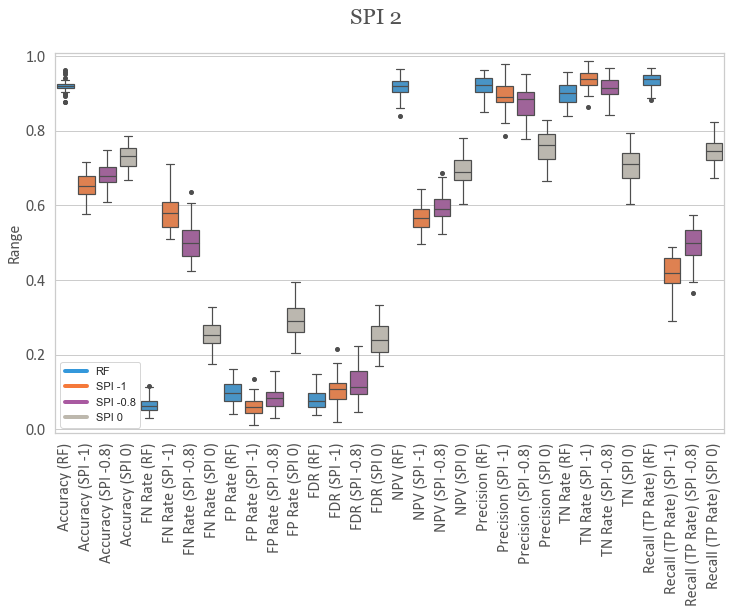

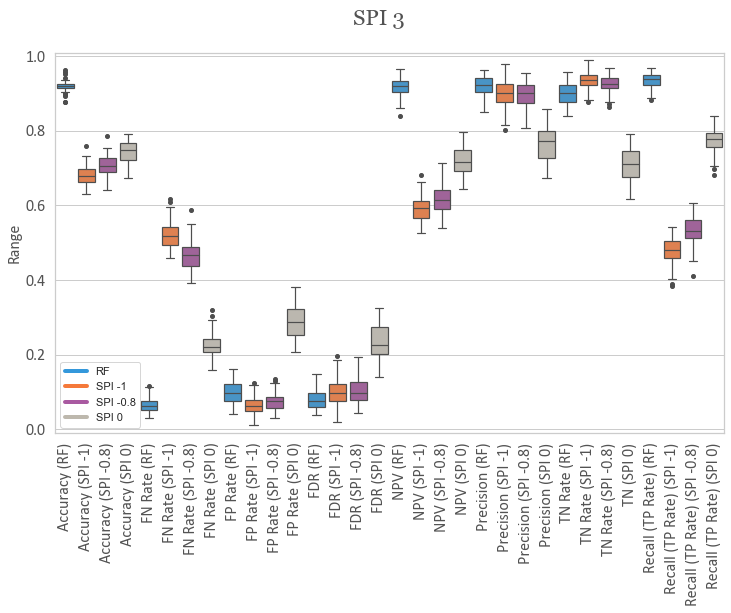

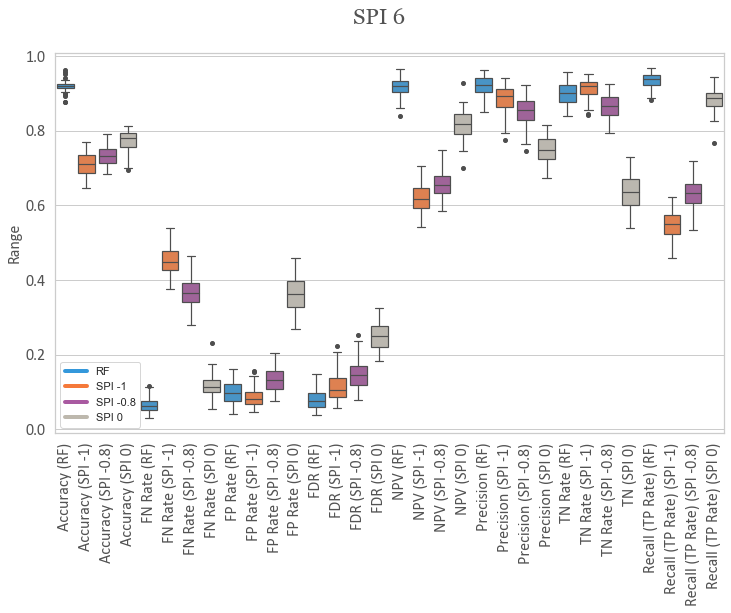

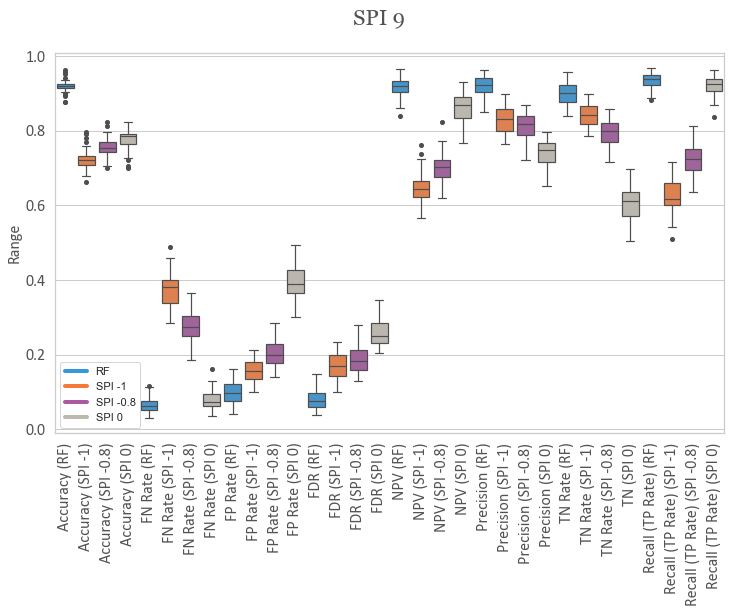

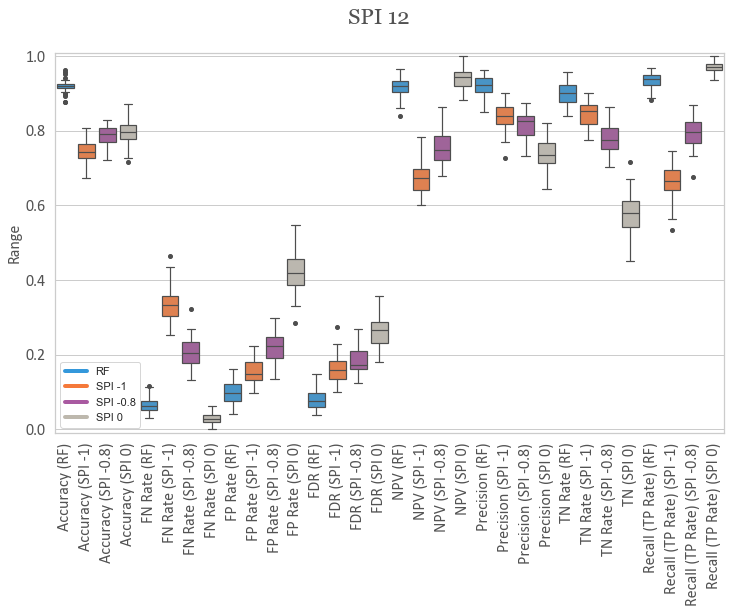

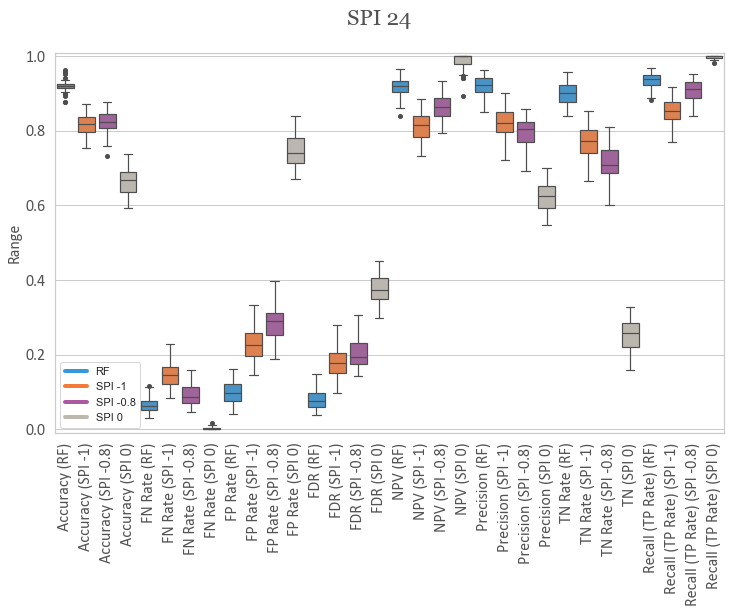

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for spi_name_value in column_names:
    # Reading in file and removing unnamed columns and overall accuracy
    spi_rf_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')
    # Getting a list of column names:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    # Making a tuple that has the start of the column name we want to remove
    unnamed_ov_acc_list = ('Unnamed:','Overall accuracy') #This is a tuple. startswith only takes a tuple of strings
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
    #print(all_unnamed)
    spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    # Now removing all of these
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    tn_fn_tp_fp_names = ('True Positive_SPI','False Positive_SPI','True Negative_SPI','False Negative_SPI','True Positive_RF','False Positive_RF','True Negative_RF','False Negative_RF')
    # creating a list of all the col names that start with Unnamed
    all_contains = [x for x in metrics_col_name_list if x.startswith(tn_fn_tp_fp_names)]
    spi_rf_metrics.drop(columns=all_contains,inplace=True)

    # Getting a list of column names in dataframe:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()

    # Creating tuple of SPI names in dataframe and removing the SPI value I want to plot
    c_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
    c_names.remove(spi_name_value) #https://www.studytonight.com/post/python-how-to-remove-a-specific-element-from-a-list-of-tuples
    #print(c_names)

    for column_n in c_names:
        # creating a list of all the col names that contain the above
        all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
        spi_rf_metrics.drop(columns=all_contains,inplace=True)
    
    # Preparing for title of figure
    # Remove under score and replace with space
    spi_title_str = spi_name_value.replace("_"," ") # https://stackoverflow.com/questions/70150389/how-to-replace-punctuation-with-space-python

    # Assigning it to a new db name
    rf_spi_db = spi_rf_metrics

    # Rearranging columns alphabetically
    # https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas
    # Creating a list of column names
    col_name = list(rf_spi_db.columns)
    # Sorting alphabetically
    col_name.sort()

    # Sorting columnas and reassigning to the dataframe
    rf_spi_db = rf_spi_db[col_name]
    # Renaming columns so the labels in the figures are shorter and only the title says what CDI it is
    rf_spi_db.columns = ['Accuracy (RF)', 'Accuracy (SPI -1)', 'Accuracy (SPI -0.8)', 'Accuracy (SPI 0)', 'FN Rate (RF)', 'FN Rate (SPI -1)', 'FN Rate (SPI -0.8)', 'FN Rate (SPI 0)', 'FP Rate (RF)', 'FP Rate (SPI -1)', 'FP Rate (SPI -0.8)', 'FP Rate (SPI 0)', 'FDR (RF)', 'FDR (SPI -1)', 'FDR (SPI -0.8)', 'FDR (SPI 0)', 'NPV (RF)', 'NPV (SPI -1)', 'NPV (SPI -0.8)', 'NPV (SPI 0)', 'Precision (RF)', 'Precision (SPI -1)', 'Precision (SPI -0.8)', 'Precision (SPI 0)', 'TN Rate (RF)', 'TN Rate (SPI -1)', 'TN Rate (SPI -0.8)', 'TN (SPI 0)', 'Recall (TP Rate) (RF)', 'Recall (TP Rate) (SPI -1)', 'Recall (TP Rate) (SPI -0.8)', 'Recall (TP Rate) (SPI 0)']

    # Creating figure
    sns.set(style='whitegrid')
    #facecolor = '#eaeaf2'
    fig, ax = plt.subplots(figsize=(12, 7)) #, facecolor=facecolor)

    # Specifying color of boxplot RF and CDI
    #create your own color array
    my_colors =['#3498db','#F5793A','#A95AA1','#BDB8AD'] # = ["#3498db","#ff6500","#ffa500","#ffe500"] 
    # Useful links: https://www.geeksforgeeks.org/how-to-use-seaborn-color-palette-to-color-boxplot/
    # If the color palette has fewer colours then it repeats themselves. This allows every two to be differet: https://www.geeksforgeeks.org/python-plotly-how-to-set-up-a-color-palette/ 

    # Create box plot:
    ax = sns.boxplot(data=rf_spi_db, 
                    palette= my_colors, 
                    linewidth=1.2, 
                    fliersize=2,
                    flierprops=dict(marker='o', markersize=4))

    # Getting a list of all column names:
    Col_names = list(rf_spi_db.columns.values)
    #print(Col_names)

    # Rotating the x labels - Source: https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
    ax.set_xticklabels(labels=Col_names, rotation=90) 

    # Set labels font parameter
    font_color = '#525252'
    csfont = {'fontname':'Georgia'}
    hfont = {'fontname':'Calibri'}

    ax.set_ylabel('Range', fontsize=16, color=font_color, **hfont)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set(fontsize=16, color=font_color, **hfont)

    # Setting the range of the y axis 
    ax.set(ylim=(-0.01, 1.01)) #https://stackoverflow.com/questions/33227473/how-to-set-the-range-of-y-axis-for-a-seaborn-boxplot

    # Create title:
    title = spi_title_str
    fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
    #subtitle = 'Random state: 0 to 50'
    #plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
    #plt.subplots_adjust(top=0.85)

    # Set colour of outlier points: 
    for i, box in enumerate(ax.artists):
        col = box.get_facecolor()
        plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


    # But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
    # Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
    # Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
    # Will do it later.

    # Adding a legend:
    custom_lines = [Line2D([0], [0], color='#3498db', lw=4),
                    Line2D([0], [0], color='#F5793A', lw=4),
                    Line2D([0], [0], color='#A95AA1', lw=4),
                    Line2D([0], [0], color='#BDB8AD', lw=4)]
                    
    ax.legend(custom_lines, ['RF', 'SPI -1','SPI -0.8','SPI 0']) # Source: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

    # Making sure that the x labels all fit in the saved figure: https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
    # Saving the figure:
    filename = 'sns-boxplot_RFvs'+ str(spi_name_value)
    plt.savefig(filename+'31_Oct_22.png',bbox_inches = "tight",dpi = 300)
        
    

In [18]:
print(spi_name_value.replace("_"," "))


SPI 24


In [9]:
c_names

['SPI_1_', 'SPI_2_', 'SPI_3', 'SPI_6', 'SPI_9', 'SPI_12']

In [8]:
spi_name_value = c_names.tr('_', ' ')

AttributeError: 'list' object has no attribute 'tr'

# Replotting without recall and precision

c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users

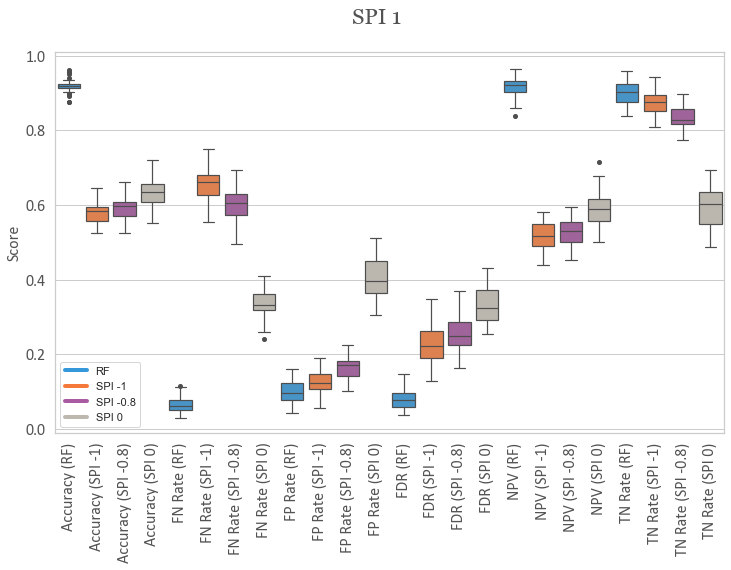

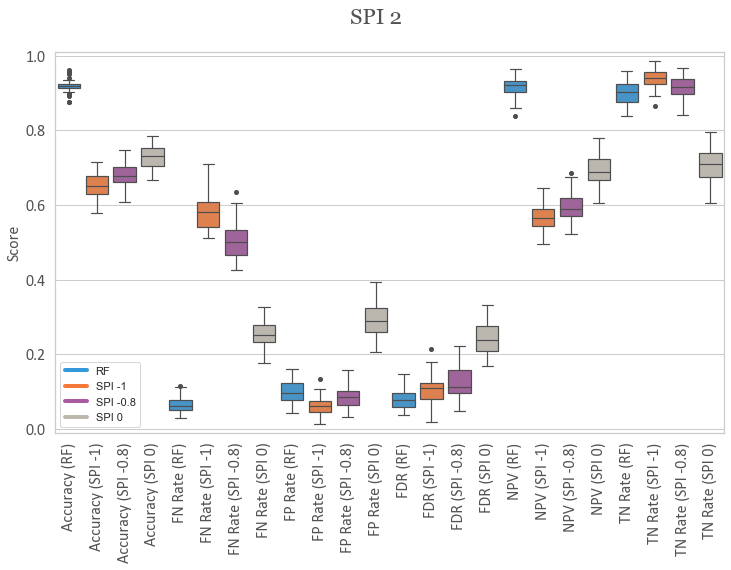

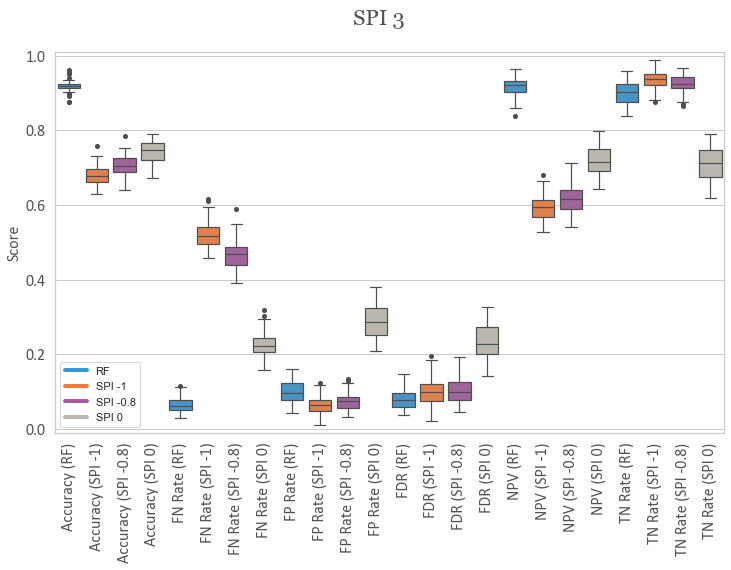

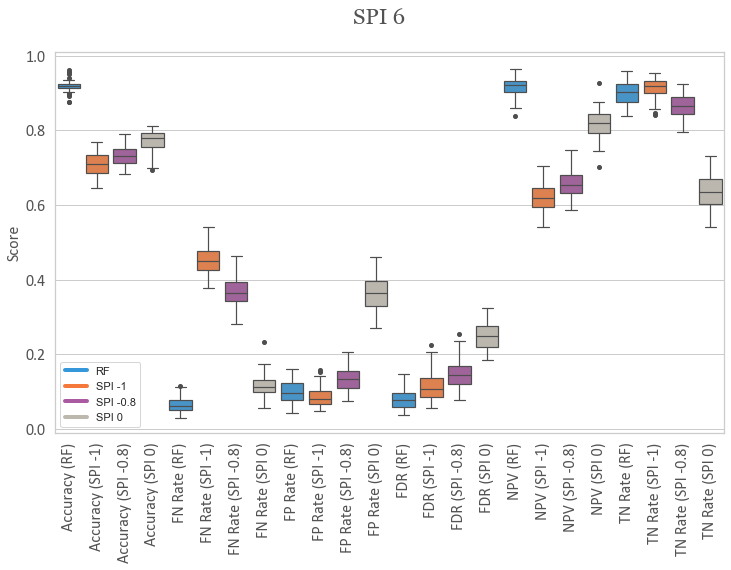

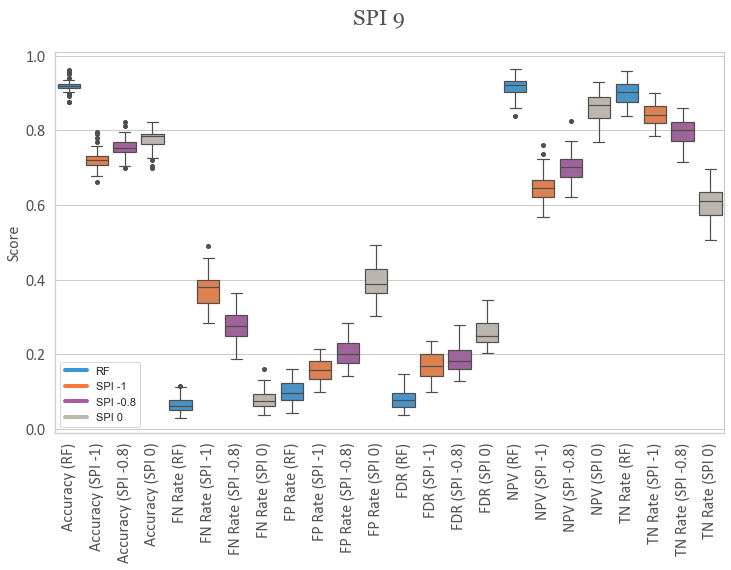

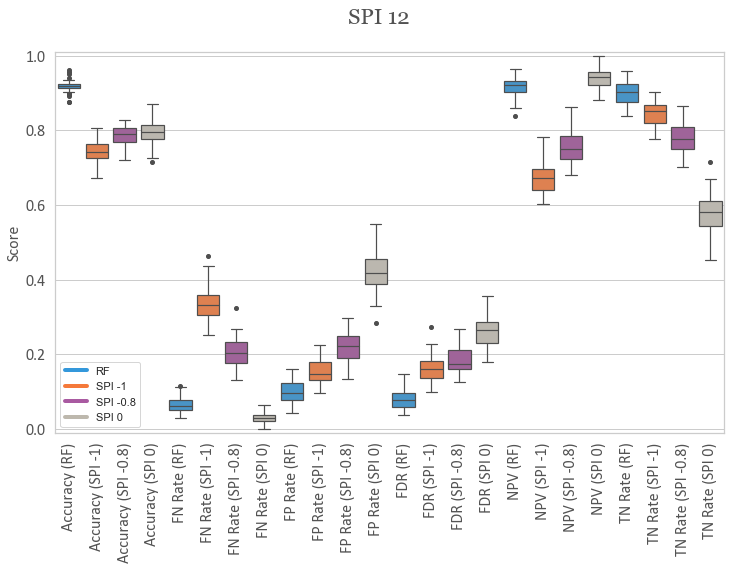

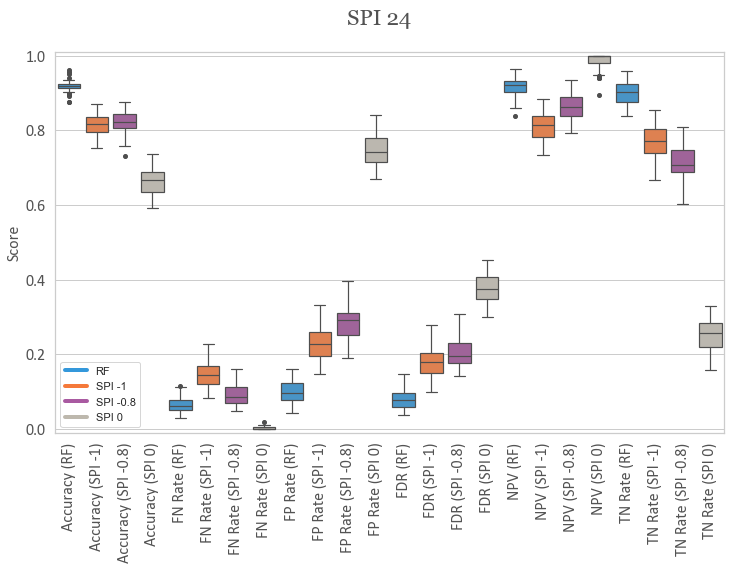

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for spi_name_value in column_names:
    # Reading in file and removing unnamed columns and overall accuracy
    spi_rf_metrics = pd.read_csv('Combined_Metrics_Accuracy_Conf_Matrix_for_SPI_and_RF_random_state_0_to_50_9Oct.csv')
    # Getting a list of column names:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    # Making a tuple that has the start of the column name we want to remove
    unnamed_ov_acc_list = ('Unnamed:','Overall accuracy') #This is a tuple. startswith only takes a tuple of strings
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
    #print(all_unnamed)
    spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    # Now removing all of these
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    tn_fn_tp_fp_names = ('True Positive_SPI','False Positive_SPI','True Negative_SPI','False Negative_SPI','True Positive_RF','False Positive_RF','True Negative_RF','False Negative_RF','True Positive Rate','Positive predictive value')
    # creating a list of all the col names that start with Unnamed
    all_contains = [x for x in metrics_col_name_list if x.startswith(tn_fn_tp_fp_names)]
    spi_rf_metrics.drop(columns=all_contains,inplace=True)

    # Getting a list of column names in dataframe:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()

    # Creating tuple of SPI names in dataframe and removing the SPI value I want to plot
    c_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
    c_names.remove(spi_name_value) #https://www.studytonight.com/post/python-how-to-remove-a-specific-element-from-a-list-of-tuples
    #print(c_names)

    for column_n in c_names:
        # creating a list of all the col names that contain the above
        all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
        spi_rf_metrics.drop(columns=all_contains,inplace=True)
    
    # Preparing for title of figure
    # Remove under score and replace with space
    spi_title_str = spi_name_value.replace("_"," ") # https://stackoverflow.com/questions/70150389/how-to-replace-punctuation-with-space-python

    # Assigning it to a new db name
    rf_spi_db = spi_rf_metrics

    # Rearranging columns alphabetically
    # https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas
    # Creating a list of column names
    col_name = list(rf_spi_db.columns)
    # Sorting alphabetically
    col_name.sort()

    # Sorting columnas and reassigning to the dataframe
    rf_spi_db = rf_spi_db[col_name]
    # Renaming columns so the labels in the figures are shorter and only the title says what CDI it is
    rf_spi_db.columns = ['Accuracy (RF)', 'Accuracy (SPI -1)', 'Accuracy (SPI -0.8)', 'Accuracy (SPI 0)', 'FN Rate (RF)', 'FN Rate (SPI -1)', 'FN Rate (SPI -0.8)', 'FN Rate (SPI 0)', 'FP Rate (RF)', 'FP Rate (SPI -1)', 'FP Rate (SPI -0.8)', 'FP Rate (SPI 0)', 'FDR (RF)', 'FDR (SPI -1)', 'FDR (SPI -0.8)', 'FDR (SPI 0)', 'NPV (RF)', 'NPV (SPI -1)', 'NPV (SPI -0.8)', 'NPV (SPI 0)', 'TN Rate (RF)', 'TN Rate (SPI -1)', 'TN Rate (SPI -0.8)', 'TN Rate (SPI 0)']

    # Creating figure
    sns.set(style='whitegrid')
    #facecolor = '#eaeaf2'
    fig, ax = plt.subplots(figsize=(12, 7)) #, facecolor=facecolor)

    # Specifying color of boxplot RF and CDI
    #create your own color array
    my_colors =['#3498db','#F5793A','#A95AA1','#BDB8AD'] # = ["#3498db","#ff6500","#ffa500","#ffe500"] 
    # my_colors = ['#984ea3', '#ff7f00', '#4daf4a',
    #              '#f781bf', '#a65628', '#377eb8'] #Palette from https://gist.github.com/thriveth/8560036
    # Useful links: https://www.geeksforgeeks.org/how-to-use-seaborn-color-palette-to-color-boxplot/
    # If the color palette has fewer colours then it repeats themselves. This allows every two to be differet: https://www.geeksforgeeks.org/python-plotly-how-to-set-up-a-color-palette/ 

    # Create box plot:
    ax = sns.boxplot(data=rf_spi_db, 
                    palette= my_colors, 
                    linewidth=1.2, 
                    fliersize=2,
                    flierprops=dict(marker='o', markersize=4))

    # Getting a list of all column names:
    Col_names = list(rf_spi_db.columns.values)
    #print(Col_names)

    # Rotating the x labels - Source: https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
    ax.set_xticklabels(labels=Col_names, rotation=90) 

    # Set labels font parameter
    font_color = '#525252'
    csfont = {'fontname':'Georgia'}
    hfont = {'fontname':'Calibri'}

    ax.set_ylabel('Score', fontsize=16, color=font_color, **hfont)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set(fontsize=16, color=font_color, **hfont)

    # Setting the range of the y axis 
    ax.set(ylim=(-0.01, 1.01)) #https://stackoverflow.com/questions/33227473/how-to-set-the-range-of-y-axis-for-a-seaborn-boxplot

    # Create title:
    title = spi_title_str
    fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
    #subtitle = 'Random state: 0 to 50'
    #plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
    #plt.subplots_adjust(top=0.85)

    # Set colour of outlier points: 
    for i, box in enumerate(ax.artists):
        col = box.get_facecolor()
        plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


    # But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
    # Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
    # Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
    # Will do it later.

    # Adding a legend:
    custom_lines = [Line2D([0], [0], color='#3498db', lw=4),
                    Line2D([0], [0], color='#F5793A', lw=4),
                    Line2D([0], [0], color='#A95AA1', lw=4),
                    Line2D([0], [0], color='#BDB8AD', lw=4)]
                    
    ax.legend(custom_lines, ['RF', 'SPI -1','SPI -0.8','SPI 0']) # Source: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

    # Making sure that the x labels all fit in the saved figure: https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
    # Saving the figure:
    filename = 'sns-boxplot_RFvs'+ str(spi_name_value)
    plt.savefig(filename+'7_Nov_22.png',bbox_inches = "tight",dpi = 300)
        
    

## Precision Recall F1 score chart

In [43]:
# SPI
##Combining all final classification reports into one
import glob
import os
import pandas as pd
##Setting path of files and giving name
# example of file: SPI_9_threshold_4_Random_state_0_to_50_Classification_Report_Final_9Oct
files_CDI = os.path.join("*Random_state_0_to_50_Classification_Report_Final_9Oct.csv") # Put * before to get the files ending in the above https://stackoverflow.com/questions/44886581/how-to-search-for-all-files-that-end-a-certain-way-in-windows 
##List of merged files returned
files_CDI = glob.glob(files_CDI)
print(files_CDI)
## Reading all files into individual dataframes and combining them: https://www.geeksforgeeks.org/how-to-read-multiple-data-files-into-pandas/
main_dataframe = pd.DataFrame(pd.read_csv(files_CDI[0]))
name = [files_CDI[:18] for files_CDI in files_CDI[0].split()]
name = name [0]
main_dataframe.columns = ['Unnamed: 0','class','precision_'+name,'recall_'+name,'f1_score_'+name,'support']
  
for i in range(1,len(files_CDI)):
    data = pd.read_csv(files_CDI[i])
    df = pd.DataFrame(data)
    name_2 = [files_CDI[:18] for files_CDI in files_CDI[i].split()]
    name_2 = name_2[0]
    print(name_2)
    df.columns = ['Unnamed: 0','class','precision_'+str(name_2),'recall_'+str(name_2),'f1_score_'+str(name_2),'support']
    main_dataframe = pd.concat([main_dataframe,df],join='outer',axis=1)
#main_dataframe

# Combining to the RF
df_RF = pd.read_csv('Random_state_0_to_50_Classification_Report_Final_9Oct_RF_SPI.csv')
df_RF.columns = ['Unnamed: 0','class','precision_RF','recall_RF','f1_score_RF','support']
main_dataframe = pd.concat([main_dataframe,df_RF],join='outer',axis=1)

##Saving to csv
main_dataframe.to_csv('Precision_Recall_F1_score_combined_RF_and_SPI_2_Nov_22.csv')

['SPI_12_threshold_3_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_12_threshold_4_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_12_threshold_5_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_1_threshold_3_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_1_threshold_4_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_1_threshold_5_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_24_threshold_3_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_24_threshold_4_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_24_threshold_5_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_2_threshold_3_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_2_threshold_4_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_2_threshold_5_Random_state_0_to_50_Classification_Report_Final_9Oct.csv', 'SPI_3_threshold_3_Random_state_0_to_50_Class

In [27]:
x= [files_CDI[:6] for files_CDI in files_CDI[0].split()]
x[0]

'SPI_12'

In [35]:
name_2 = [files_CDI[:6] for files_CDI in files_CDI[2].split()]
name_2 = name_2[0]
name_2

'SPI_12'

In [42]:
main_dataframe

,Unnamed: 0,class,precision_SPI_12,recall_SPI_12,f1_score_SPI_12,support,Unnamed: 0,class,precision_SPI_12,recall_SPI_12,...,precision_SPI_9_,recall_SPI_9_,f1_score_SPI_9_,support,Unnamed: 0,class,precision_RF,recall_RF,f1_score_RF,support
0,0,0,0.68,0.86,0.76,80.0,0,0,0.77,0.81,...,0.87,0.60,0.71,80.0,0,0,0.92,0.90,0.91,80.0
1,1,1,0.87,0.69,0.77,107.0,1,1,0.85,0.82,...,0.76,0.93,0.84,107.0,1,1,0.93,0.94,0.94,107.0
2,2,0,0.66,0.79,0.72,84.0,2,0,0.75,0.70,...,0.83,0.57,0.68,84.0,2,0,0.91,0.95,0.93,82.0
3,3,1,0.79,0.67,0.73,103.0,3,1,0.77,0.81,...,0.72,0.90,0.80,103.0,3,1,0.96,0.92,0.94,105.0
4,4,0,0.65,0.83,0.73,82.0,4,0,0.73,0.74,...,0.84,0.62,0.71,82.0,4,0,0.92,0.89,0.90,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,1,0.83,0.65,0.73,110.0,97,1,0.83,0.79,...,0.78,0.92,0.85,110.0,97,1,0.91,0.95,0.93,110.0
98,98,0,0.73,0.87,0.79,85.0,98,0,0.80,0.82,...,0.91,0.61,0.73,85.0,98,0,0.95,0.91,0.93,85.0
99,99,1,0.87,0.73,0.79,102.0,99,1,0.85,0.82,...,0.75,0.95,0.84,102.0,99,1,0.92,0.96,0.94,102.0
100,100,0,0.62,0.85,0.72,75.0,100,0,0.71,0.77,...,0.85,0.63,0.72,75.0,100,0,0.87,0.92,0.90,75.0


['precision_SPI_12_threshold_3', 'recall_SPI_12_threshold_3', 'f1_score_SPI_12_threshold_3', 'precision_SPI_12_threshold_4', 'recall_SPI_12_threshold_4', 'f1_score_SPI_12_threshold_4', 'precision_SPI_12_threshold_5', 'recall_SPI_12_threshold_5', 'f1_score_SPI_12_threshold_5', 'precision_SPI_1_threshold_3_', 'recall_SPI_1_threshold_3_', 'f1_score_SPI_1_threshold_3_', 'precision_SPI_1_threshold_4_', 'recall_SPI_1_threshold_4_', 'f1_score_SPI_1_threshold_4_', 'precision_SPI_1_threshold_5_', 'recall_SPI_1_threshold_5_', 'f1_score_SPI_1_threshold_5_', 'precision_SPI_24_threshold_3', 'recall_SPI_24_threshold_3', 'f1_score_SPI_24_threshold_3', 'precision_SPI_24_threshold_4', 'recall_SPI_24_threshold_4', 'f1_score_SPI_24_threshold_4', 'precision_SPI_24_threshold_5', 'recall_SPI_24_threshold_5', 'f1_score_SPI_24_threshold_5', 'precision_SPI_2_threshold_3_', 'recall_SPI_2_threshold_3_', 'f1_score_SPI_2_threshold_3_', 'precision_SPI_2_threshold_4_', 'recall_SPI_2_threshold_4_', 'f1_score_SPI_2_th

c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_12_threshold_3', 'f1_score_SPI_12_threshold_4', 'f1_score_SPI_12_threshold_5', 'f1_score_SPI_1_threshold_3_', 'f1_score_SPI_1_threshold_4_', 'f1_score_SPI_1_threshold_5_', 'f1_score_SPI_24_threshold_3', 'f1_score_SPI_24_threshold_4', 'f1_score_SPI_24_threshold_5', 'f1_score_SPI_2_threshold_3_', 'f1_score_SPI_2_threshold_4_', 'f1_score_SPI_2_threshold_5_', 'f1_score_SPI_3_threshold_3_', 'f1_score_SPI_3_threshold_4_', 'f1_score_SPI_3_threshold_5_', 'f1_score_SPI_6_threshold_3_', 'f1_score_SPI_6_threshold_4_', 'f1_score_SPI_6_threshold_5_', 'f1_score_SPI_9_threshold_3_', 'f1_score_SPI_9_threshold_4_', 'f1_score_SPI_9_threshold_5_', 'precision_RF', 'precision_SPI_12_threshold_3', 'precision_SPI_12_threshold_4', 'precision_SPI_12_threshold_5', 'precision_SPI_1_threshold_3_', 'precision_SPI_1_threshold_4_', 'precision_SPI_1_threshold_5_', 'precision_SPI_24_threshold_3', 'precision_SPI_24_threshold_4', 'precision_SPI_24_threshold_5', 'precision_SPI_2_threshold_3_

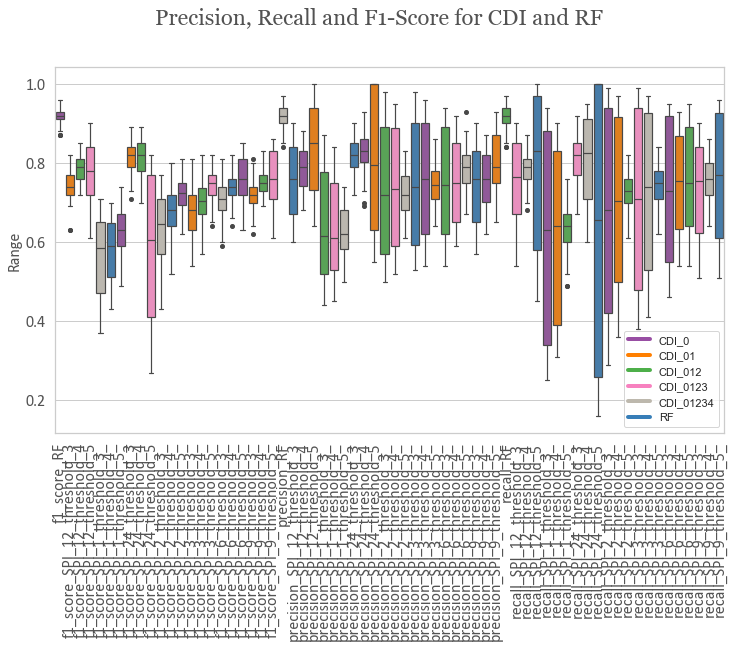

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_1_','SPI_2_','SPI_3_','SPI_6_','SPI_9_','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str

# Reading in file and removing unnamed columns and overall accuracy
cdi_rf_metrics = pd.read_csv('Precision_Recall_F1_score_combined_RF_and_SPI_2_Nov_22.csv')
# Getting a list of column names:
metrics_col_name_list = cdi_rf_metrics.columns.tolist()
# Making a tuple that has the start of the column name we want to remove
unnamed_ov_acc_list = ('Unnamed: 0','support','class') #This is a tuple. startswith only takes a tuple of strings
#metrics_col_name_list
# creating a list of all the col names that start with Unnamed
all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
#print(all_unnamed)
cdi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    
# Assigning it to a new db name
rf_cdi_db = cdi_rf_metrics

# Rearranging columns alphabetically
# https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas
# Creating a list of column names
col_name = list(rf_cdi_db.columns)
print(col_name)
# Sorting alphabetically
col_name.sort()

# Sorting columnas and reassigning to the dataframe
rf_cdi_db = rf_cdi_db[col_name]
# Renaming columns so the labels in the figures are shorter and only the title says what CDI it is
# Example of what one is: [[['f1_score_CDI0', 'f1_score_CDI_01', 'f1_score_CDI_012', 'f1_score_CDI_0123', 'f1_score_CDI_01234', 'f1_score_RF', 'precision_CDI0', 'precision_CDI_01', 'precision_CDI_012', 'precision_CDI_0123', 'precision_CDI_01234', 'precision_RF', 'recall_CDI0', 'recall_CDI_01', 'recall_CDI_012', 'recall_CDI_0123', 'recall_CDI_01234', 'recall_RF']]
#rf_cdi_db.columns =['F1 score (CDI_0)', 'F1 score (CDI_01)', 'F1 score (CDI_012)', 'F1 score (CDI_0123)', 'F1 score (CDI_01234)', 'F1 score (RF)', 'Precision (CDI_0)', 'Precision (CDI_01)', 'Precision (CDI_012)',
 #                   'Precision (CDI_0123)', 'Precision (CDI_01234)', 'Precision (RF)', 'Recall (CDI_0)', 'Recall (CDI_01)', 'Recall (CDI_012)', 'Recall (CDI_0123)', 'Recall (CDI_01234)', 'Recall (RF)']
#rf_cdi_db.columns =['F1 score', 'F1 score', 'F1 score', 'F1 score', 'F1 score', 'F1 score', 'Precision', 'Precision', 'Precision', 'Precision', 'Precision', 'Precision', 'Recall', 'Recall', 'Recall', 'Recall', 'Recall', 'Recall']

# Creating figure
sns.set(style='whitegrid')
#facecolor = '#eaeaf2'
fig, ax = plt.subplots(figsize=(12, 7))#, facecolor=facecolor)

# Specifying color of boxplot RF and CDI
#create your own color array
my_colors = ['#984ea3', '#ff7f00', '#4daf4a',
                  '#f781bf', '#BDB8AD', '#377eb8'] #Palette from https://gist.github.com/thriveth/8560036 - replaced a65628 with BDB8AD
# Useful links: https://www.geeksforgeeks.org/how-to-use-seaborn-color-palette-to-color-boxplot/
# If the color palette has fewer colours then it repeats themselves. This allows every two to be differet: https://www.geeksforgeeks.org/python-plotly-how-to-set-up-a-color-palette/ 

# Create box plot:
ax = sns.boxplot(data=rf_cdi_db, 
                palette= my_colors, 
                linewidth=1.2, 
                fliersize=2,
                flierprops=dict(marker='o', markersize=4)) 

# Getting a list of all column names:
Col_names = list(rf_cdi_db.columns.values)
print(Col_names)

# Rotating the x labels - Source: https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
ax.set_xticklabels(labels=Col_names, rotation=90) 

# Set labels font parameter
font_color = '#525252'
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Calibri'}

ax.set_ylabel('Range', fontsize=16, color=font_color, **hfont)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set(fontsize=16, color=font_color, **hfont)

# Setting the range of the y axis 
#ax.set(ylim=(0, 1)) #https://stackoverflow.com/questions/33227473/how-to-set-the-range-of-y-axis-for-a-seaborn-boxplot

# Create title:
title = 'Precision, Recall and F1-Score for CDI and RF'
fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
#subtitle = 'Random state: 0 to 50'
#plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
plt.subplots_adjust(top=0.85)

# Set colour of outlier points: 
for i, box in enumerate(ax.artists):
    col = box.get_facecolor()
    plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


# But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
# Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
# Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
# Will do it later.

# Adding legend:
#handles, _ = ax.get_legend_handles_labels()
#ax.legend(handles,['CDI','RF'],loc = 'best') # https://stackoverflow.com/questions/62069967/adding-a-legend-to-a-boxplot-in-matplotlib-seaborn
custom_lines = [Line2D([0], [0], color='#984ea3', lw=4),
                 Line2D([0], [0], color='#ff7f00', lw=4),
                 Line2D([0], [0], color='#4daf4a', lw=4),
                 Line2D([0], [0], color='#f781bf', lw=4),
                 Line2D([0], [0], color='#BDB8AD', lw=4),
                 Line2D([0], [0], color='#377eb8', lw=4)]
                
ax.legend(custom_lines, ['CDI_0','CDI_01','CDI_012','CDI_0123','CDI_01234', 'RF']) # Source: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

# Making sure that the x labels all fit in the saved figure: https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
# Saving the figure:
filename = 'sns-boxplot_RFvsSDI_f1_score_P_R'
plt.savefig(filename+'2_Nov_22.png',bbox_inches = "tight")


['f1_score_RF', 'f1_score_SPI_1_threshold_3_', 'f1_score_SPI_1_threshold_4_', 'f1_score_SPI_1_threshold_5_', 'precision_RF', 'precision_SPI_1_threshold_3_', 'precision_SPI_1_threshold_4_', 'precision_SPI_1_threshold_5_', 'recall_RF', 'recall_SPI_1_threshold_3_', 'recall_SPI_1_threshold_4_', 'recall_SPI_1_threshold_5_']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_2_threshold_3_', 'f1_score_SPI_2_threshold_4_', 'f1_score_SPI_2_threshold_5_', 'precision_RF', 'precision_SPI_2_threshold_3_', 'precision_SPI_2_threshold_4_', 'precision_SPI_2_threshold_5_', 'recall_RF', 'recall_SPI_2_threshold_3_', 'recall_SPI_2_threshold_4_', 'recall_SPI_2_threshold_5_']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_3_threshold_3_', 'f1_score_SPI_3_threshold_4_', 'f1_score_SPI_3_threshold_5_', 'precision_RF', 'precision_SPI_3_threshold_3_', 'precision_SPI_3_threshold_4_', 'precision_SPI_3_threshold_5_', 'recall_RF', 'recall_SPI_3_threshold_3_', 'recall_SPI_3_threshold_4_', 'recall_SPI_3_threshold_5_']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_6_threshold_3_', 'f1_score_SPI_6_threshold_4_', 'f1_score_SPI_6_threshold_5_', 'precision_RF', 'precision_SPI_6_threshold_3_', 'precision_SPI_6_threshold_4_', 'precision_SPI_6_threshold_5_', 'recall_RF', 'recall_SPI_6_threshold_3_', 'recall_SPI_6_threshold_4_', 'recall_SPI_6_threshold_5_']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_9_threshold_3_', 'f1_score_SPI_9_threshold_4_', 'f1_score_SPI_9_threshold_5_', 'precision_RF', 'precision_SPI_9_threshold_3_', 'precision_SPI_9_threshold_4_', 'precision_SPI_9_threshold_5_', 'recall_RF', 'recall_SPI_9_threshold_3_', 'recall_SPI_9_threshold_4_', 'recall_SPI_9_threshold_5_']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_12_threshold_3', 'f1_score_SPI_12_threshold_4', 'f1_score_SPI_12_threshold_5', 'precision_RF', 'precision_SPI_12_threshold_3', 'precision_SPI_12_threshold_4', 'precision_SPI_12_threshold_5', 'recall_RF', 'recall_SPI_12_threshold_3', 'recall_SPI_12_threshold_4', 'recall_SPI_12_threshold_5']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


['f1_score_RF', 'f1_score_SPI_24_threshold_3', 'f1_score_SPI_24_threshold_4', 'f1_score_SPI_24_threshold_5', 'precision_RF', 'precision_SPI_24_threshold_3', 'precision_SPI_24_threshold_4', 'precision_SPI_24_threshold_5', 'recall_RF', 'recall_SPI_24_threshold_3', 'recall_SPI_24_threshold_4', 'recall_SPI_24_threshold_5']


c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


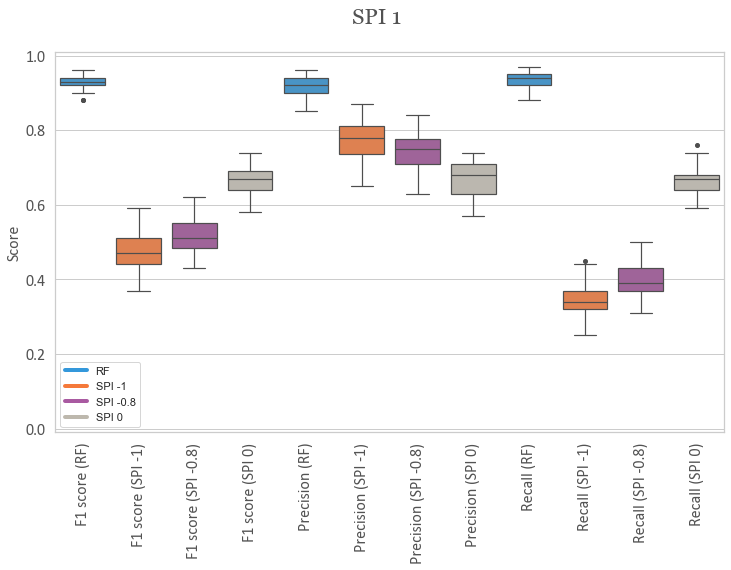

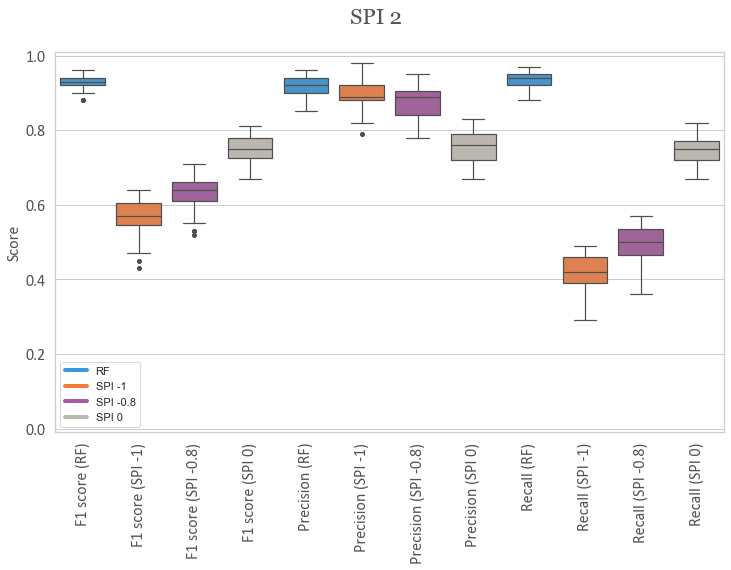

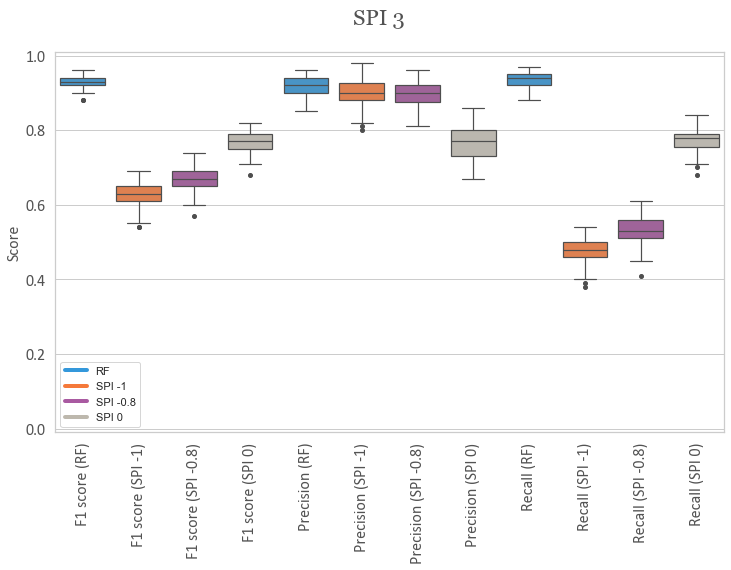

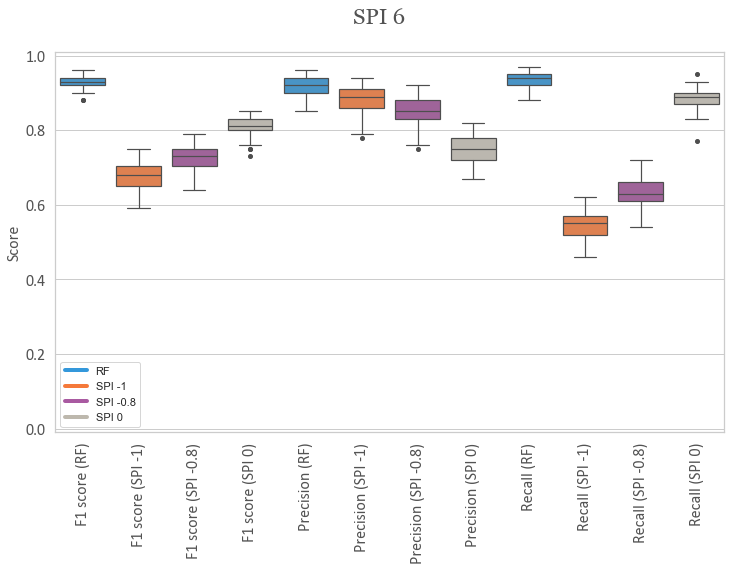

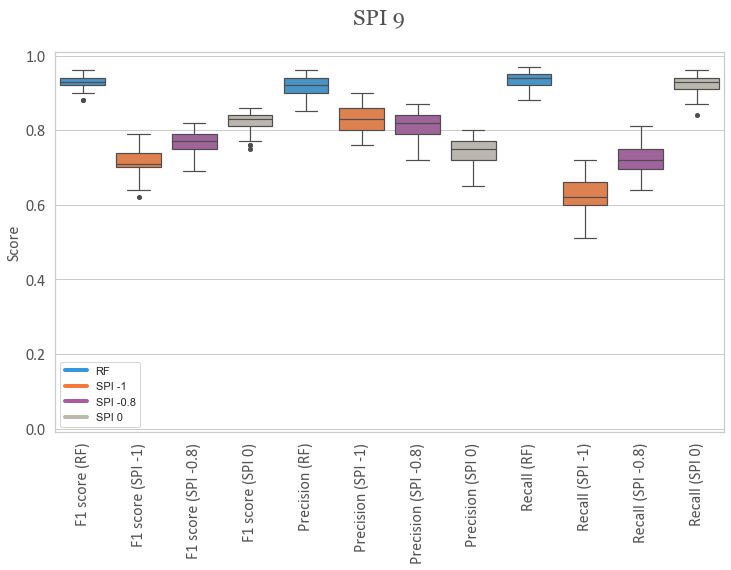

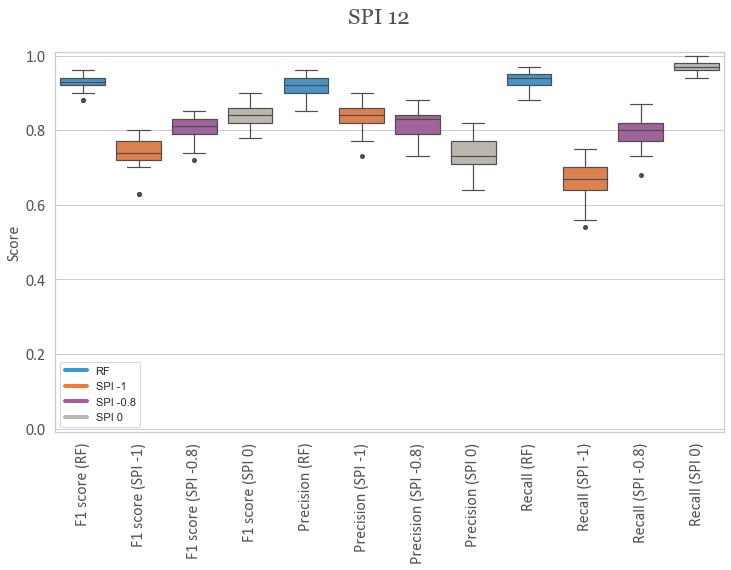

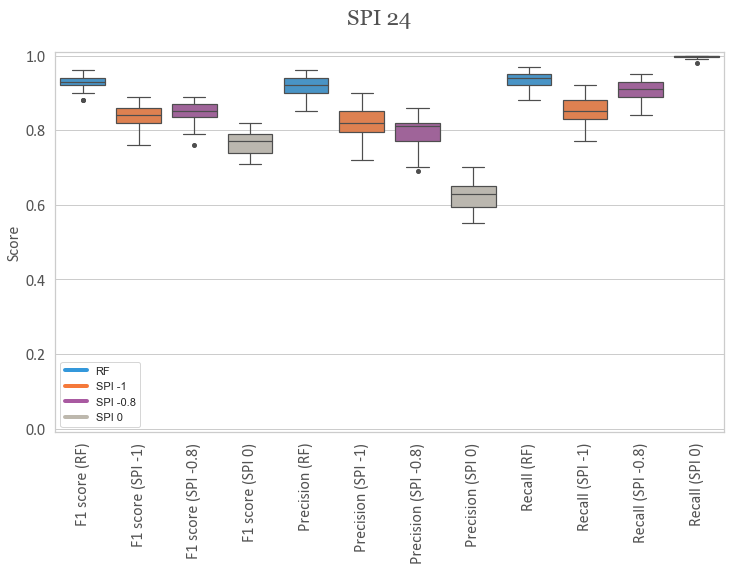

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for spi_name_value in column_names:
    # Reading in file and removing unnamed columns and overall accuracy
    spi_rf_metrics = pd.read_csv('Precision_Recall_F1_score_combined_RF_and_SPI_2_Nov_22.csv')
    # Dropping all class 0 and keeping class 1: (https://www.golinuxcloud.com/pandas-drop-rows-examples/)
    spi_rf_metrics = spi_rf_metrics.drop(spi_rf_metrics[spi_rf_metrics['class'] == 0].index)
    #  Getting a list of column names:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    # Making a tuple that has the start of the column name we want to remove
    unnamed_ov_acc_list =  ('Unnamed: 0','support','class') #This is a tuple. startswith only takes a tuple of strings
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
    #print(all_unnamed)
    spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    

    # Getting a list of column names in dataframe:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()

    # Creating tuple of SPI names in dataframe and removing the SPI value I want to plot
    c_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
    c_names.remove(spi_name_value) #https://www.studytonight.com/post/python-how-to-remove-a-specific-element-from-a-list-of-tuples
    #print(c_names)

    for column_n in c_names:
        # creating a list of all the col names that contain the above
        all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
        spi_rf_metrics.drop(columns=all_contains,inplace=True)
    
    # Preparing for title of figure
    # Remove under score and replace with space
    spi_title_str = spi_name_value.replace("_"," ") # https://stackoverflow.com/questions/70150389/how-to-replace-punctuation-with-space-python

    # Assigning it to a new db name
    rf_spi_db = spi_rf_metrics

    # Rearranging columns alphabetically
    # https://iqcode.com/code/python/how-to-sort-columns-alphabetically-in-pandas
    # Creating a list of column names
    col_name = list(rf_spi_db.columns)
    # Sorting alphabetically
    col_name.sort()
    print(col_name)

    # Sorting columnas and reassigning to the dataframe
    rf_spi_db = rf_spi_db[col_name]
    # Renaming columns so the labels in the figures are shorter and only the title says what CDI it is
    rf_spi_db.columns = ['F1 score (RF)', 'F1 score (SPI -1)', 'F1 score (SPI -0.8)', 'F1 score (SPI 0)', 'Precision (RF)', 'Precision (SPI -1)', 'Precision (SPI -0.8)', 'Precision (SPI 0)', 'Recall (RF)', 'Recall (SPI -1)', 'Recall (SPI -0.8)', 'Recall (SPI 0)']

    # Creating figure
    sns.set(style='whitegrid')
    #facecolor = '#eaeaf2'
    fig, ax = plt.subplots(figsize=(12, 7)) #, facecolor=facecolor)

    # Specifying color of boxplot RF and CDI
    #create your own color array
    my_colors =['#3498db','#F5793A','#A95AA1','#BDB8AD'] # = ["#3498db","#ff6500","#ffa500","#ffe500"] 
    #my_colors = ['#984ea3', '#ff7f00', '#4daf4a',
     #             '#f781bf', '#a65628', '#377eb8'] #Palette from https://gist.github.com/thriveth/8560036
    # Useful links: https://www.geeksforgeeks.org/how-to-use-seaborn-color-palette-to-color-boxplot/
    # If the color palette has fewer colours then it repeats themselves. This allows every two to be differet: https://www.geeksforgeeks.org/python-plotly-how-to-set-up-a-color-palette/ 

    # Create box plot:
    ax = sns.boxplot(data=rf_spi_db, 
                    palette= my_colors, 
                    linewidth=1.2, 
                    fliersize=2,
                    flierprops=dict(marker='o', markersize=4))

    # Getting a list of all column names:
    Col_names = list(rf_spi_db.columns.values)
    #print(Col_names)

    # Rotating the x labels - Source: https://www.geeksforgeeks.org/rotate-axis-tick-labels-in-seaborn-and-matplotlib/
    ax.set_xticklabels(labels=Col_names, rotation=90) 

    # Set labels font parameter
    font_color = '#525252'
    csfont = {'fontname':'Georgia'}
    hfont = {'fontname':'Calibri'}

    ax.set_ylabel('Score', fontsize=16, color=font_color, **hfont)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set(fontsize=16, color=font_color, **hfont)

    # Setting the range of the y axis 
    ax.set(ylim=(-0.01, 1.01)) #https://stackoverflow.com/questions/33227473/how-to-set-the-range-of-y-axis-for-a-seaborn-boxplot

    # Create title:
    title = spi_title_str
    fig.suptitle(title, y=.97, fontsize=22, color=font_color, **csfont)
    #subtitle = 'Random state: 0 to 50'
    #plt.title(subtitle, fontsize=18, pad=10, color=font_color, **hfont)
    #plt.subplots_adjust(top=0.85)

    # Set colour of outlier points: 
    for i, box in enumerate(ax.artists):
        col = box.get_facecolor()
        plt.setp(ax.lines[i*6+5], mfc=col, mec=col)


    # But there are values at 0 which are not 0. I want to have more than 0.0 but 3 dec places. 
    # Potential other way: https://pyquestions.com/labeling-boxplot-in-seaborn-with-median-value 
    # Interesting plotting: https://stackoverflow.com/questions/60995546/box-plot-with-divisor-in-seaborn-python
    # Will do it later.

    # Adding a legend:
    custom_lines = [Line2D([0], [0], color='#3498db', lw=4),
                    Line2D([0], [0], color='#F5793A', lw=4),
                    Line2D([0], [0], color='#A95AA1', lw=4),
                    Line2D([0], [0], color='#BDB8AD', lw=4)]
                    
    ax.legend(custom_lines, ['RF', 'SPI -1','SPI -0.8','SPI 0'],loc ='lower left' ) # Source: https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html

    # Making sure that the x labels all fit in the saved figure: https://stackoverflow.com/questions/45239261/matplotlib-savefig-text-chopped-off
    # Saving the figure:
    filename = 'sns-boxplot_F1_score_P_and_R_RFvs'+ str(spi_name_value)
    plt.savefig(filename+'7_Nov_22.png',bbox_inches = "tight", dpi = 300)


        

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Looping through 
# Making a tuple that has the values in the column name we want to remove
column_names = ['SPI_6'] #This is a tuple. startswith only takes a tuple of strings
# __contains only takes one str
for spi_name_value in column_names:
    # Reading in file and removing unnamed columns and overall accuracy
    spi_rf_metrics = pd.read_csv('Precision_Recall_F1_score_combined_RF_and_SPI_2_Nov_22.csv')
    # Dropping all class 0 and keeping class 1: (https://www.golinuxcloud.com/pandas-drop-rows-examples/)
    spi_rf_metrics = spi_rf_metrics.drop(spi_rf_metrics[spi_rf_metrics['class'] == 0].index)
    # Getting a list of column names:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()
    # Making a tuple that has the start of the column name we want to remove
    unnamed_ov_acc_list =  ('Unnamed: 0','support','class') #This is a tuple. startswith only takes a tuple of strings
    #metrics_col_name_list
    # creating a list of all the col names that start with Unnamed
    all_unnamed = [x for x in metrics_col_name_list if x.startswith(unnamed_ov_acc_list)]
    #print(all_unnamed)
    spi_rf_metrics.drop(columns=all_unnamed,inplace=True)
    

    # Getting a list of column names in dataframe:
    metrics_col_name_list = spi_rf_metrics.columns.tolist()

    # Creating tuple of SPI names in dataframe and removing the SPI value I want to plot
    c_names = ['SPI_1_','SPI_2_','SPI_3','SPI_6','SPI_9','SPI_12','SPI_24'] #This is a tuple. startswith only takes a tuple of strings
    c_names.remove(spi_name_value) #https://www.studytonight.com/post/python-how-to-remove-a-specific-element-from-a-list-of-tuples
    #print(c_names)

    for column_n in c_names:
        # creating a list of all the col names that contain the above
        all_contains = [x for x in metrics_col_name_list if x.__contains__(column_n)]
        spi_rf_metrics.drop(columns=all_contains,inplace=True)
    
    # Preparing for title of figure
    # Remove under score and replace with space
    spi_title_str = spi_name_value.replace("_"," ") # https://stackoverflow.com/questions/70150389/how-to-replace-punctuation-with-space-python

    # Assigning it to a new db name
    rf_spi_db = spi_rf_metrics

rf_spi_db

c:\Users\sy6sh\Anaconda3\envs\Honours_2022\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


,precision_SPI_6_threshold_3_,recall_SPI_6_threshold_3_,f1_score_SPI_6_threshold_3_,precision_SPI_6_threshold_4_,recall_SPI_6_threshold_4_,f1_score_SPI_6_threshold_4_,precision_SPI_6_threshold_5_,recall_SPI_6_threshold_5_,f1_score_SPI_6_threshold_5_,precision_RF,recall_RF,f1_score_RF
0,0.64,0.91,0.75,0.68,0.88,0.77,0.83,0.68,0.74,0.92,0.90,0.91
1,0.90,0.62,0.73,0.88,0.69,0.77,0.79,0.90,0.84,0.93,0.94,0.94
2,0.65,0.92,0.76,0.64,0.82,0.72,0.81,0.55,0.65,0.91,0.95,0.93
3,0.90,0.59,0.71,0.81,0.63,0.71,0.71,0.89,0.79,0.96,0.92,0.94
4,0.60,0.93,0.73,0.65,0.88,0.75,0.78,0.63,0.70,0.92,0.89,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.85,0.56,0.68,0.84,0.65,0.73,0.79,0.90,0.84,0.91,0.95,0.93
98,0.65,0.95,0.77,0.68,0.91,0.78,0.88,0.66,0.75,0.95,0.91,0.93
99,0.94,0.57,0.71,0.89,0.65,0.75,0.76,0.92,0.84,0.92,0.96,0.94
100,0.57,0.92,0.71,0.61,0.87,0.71,0.78,0.65,0.71,0.87,0.92,0.90


In [20]:
spi_rf_metrics = pd.read_csv('Precision_Recall_F1_score_combined_RF_and_SPI_2_Nov_22.csv')
spi_rf_metrics

,Unnamed: 0.22,Unnamed: 0,class,precision_SPI_12_threshold_3,recall_SPI_12_threshold_3,f1_score_SPI_12_threshold_3,support,Unnamed: 0.1,class.1,precision_SPI_12_threshold_4,...,precision_SPI_9_threshold_5_,recall_SPI_9_threshold_5_,f1_score_SPI_9_threshold_5_,support.20,Unnamed: 0.21,class.21,precision_RF,recall_RF,f1_score_RF,support.21
0,0,0,0,0.68,0.86,0.76,80.0,0,0,0.77,...,0.87,0.60,0.71,80.0,0,0,0.92,0.90,0.91,80.0
1,1,1,1,0.87,0.69,0.77,107.0,1,1,0.85,...,0.76,0.93,0.84,107.0,1,1,0.93,0.94,0.94,107.0
2,2,2,0,0.66,0.79,0.72,84.0,2,0,0.75,...,0.83,0.57,0.68,84.0,2,0,0.91,0.95,0.93,82.0
3,3,3,1,0.79,0.67,0.73,103.0,3,1,0.77,...,0.72,0.90,0.80,103.0,3,1,0.96,0.92,0.94,105.0
4,4,4,0,0.65,0.83,0.73,82.0,4,0,0.73,...,0.84,0.62,0.71,82.0,4,0,0.92,0.89,0.90,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,97,1,0.83,0.65,0.73,110.0,97,1,0.83,...,0.78,0.92,0.85,110.0,97,1,0.91,0.95,0.93,110.0
98,98,98,0,0.73,0.87,0.79,85.0,98,0,0.80,...,0.91,0.61,0.73,85.0,98,0,0.95,0.91,0.93,85.0
99,99,99,1,0.87,0.73,0.79,102.0,99,1,0.85,...,0.75,0.95,0.84,102.0,99,1,0.92,0.96,0.94,102.0
100,100,100,0,0.62,0.85,0.72,75.0,100,0,0.71,...,0.85,0.63,0.72,75.0,100,0,0.87,0.92,0.90,75.0


In [23]:
    # Dropping all class 0 and keeping class 1:
value = [0]
spi_rf_metrics = spi_rf_metrics.drop(spi_rf_metrics[spi_rf_metrics['class'] == 0].index)

In [24]:
spi_rf_metrics

,Unnamed: 0.22,Unnamed: 0,class,precision_SPI_12_threshold_3,recall_SPI_12_threshold_3,f1_score_SPI_12_threshold_3,support,Unnamed: 0.1,class.1,precision_SPI_12_threshold_4,...,precision_SPI_9_threshold_5_,recall_SPI_9_threshold_5_,f1_score_SPI_9_threshold_5_,support.20,Unnamed: 0.21,class.21,precision_RF,recall_RF,f1_score_RF,support.21
1,1,1,1,0.87,0.69,0.77,107.0,1,1,0.85,...,0.76,0.93,0.84,107.0,1,1,0.93,0.94,0.94,107.0
3,3,3,1,0.79,0.67,0.73,103.0,3,1,0.77,...,0.72,0.90,0.80,103.0,3,1,0.96,0.92,0.94,105.0
5,5,5,1,0.83,0.65,0.73,105.0,5,1,0.80,...,0.75,0.90,0.82,105.0,5,1,0.92,0.94,0.93,108.0
7,7,7,1,0.82,0.60,0.70,108.0,7,1,0.84,...,0.77,0.91,0.83,108.0,7,1,0.95,0.92,0.93,106.0
9,9,9,1,0.86,0.65,0.74,106.0,9,1,0.84,...,0.78,0.89,0.83,106.0,9,1,0.96,0.95,0.95,113.0
11,11,11,1,0.83,0.66,0.74,113.0,11,1,0.83,...,0.77,0.94,0.84,113.0,11,1,0.95,0.90,0.92,108.0
13,13,13,1,0.86,0.61,0.71,108.0,13,1,0.82,...,0.78,0.90,0.83,108.0,13,1,0.96,0.92,0.94,98.0
15,15,15,1,0.86,0.65,0.74,98.0,15,1,0.87,...,0.77,0.91,0.83,98.0,15,1,0.93,0.88,0.91,112.0
17,17,17,1,0.86,0.71,0.77,112.0,17,1,0.85,...,0.75,0.95,0.84,112.0,17,1,0.94,0.93,0.93,108.0
19,19,19,1,0.85,0.63,0.72,108.0,19,1,0.85,...,0.80,0.91,0.85,108.0,19,1,0.92,0.95,0.94,107.0
